Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d



In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
Version = "v4" # Clipping a control with an outlier

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 5
    Num_boost_round=10000
    Early_stopping_rounds=20
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

In [7]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

# Training Utils

In [8]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str, ctr):
    
    target = train_targets_scored[target_col]
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    
    X_train = pd.concat([trt, ctr], axis=0).reset_index(drop=True)
    y_train = X_train["target"]
    
    X_train = X_train.drop(["sig_id", "target", "cp_type"], axis=1)
    X_test = test.drop(["sig_id", "cp_type"], axis=1)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(X_train),))
    score = 0
    
    logger.info(f'len(trt) : {len(trt)}')
    
    for fold_, (train_index, valid_index) in enumerate(cv.split(X_train, y_train)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = X_train.loc[train_index, :]
        X_val = X_train.loc[valid_index, :]
        y_tr = y_train[train_index]
        y_val = y_train[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        logger.info(f"================================= {fold_+1}fold lightgbm =================================")

        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=20,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)


        y_pred = model.predict(X_test, num_iteration=model.best_iteration)

        y_preds.append(y_pred)
        models.append(model)
    
    score = log_loss(y_train, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")

    return sum(y_preds) / len(y_preds), score, models, 

In [9]:
def show_feature_importance(feature_importance_df):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:100].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 30))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [10]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [11]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [12]:
train, test = label_encoding(train, test, ['cp_type', 'cp_dose'])

In [13]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,1,24,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,1,72,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,1,48,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,1,48,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,1,72,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [14]:
# Select control data
ctl = train[(train.cp_type==0)]
ctl

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
25,id_0054388ec,0,48,0,-0.6696,-0.2718,-1.2230,-0.6226,-0.7220,0.1588,...,0.6171,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050
38,id_0079af0fb,0,24,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-0.3880,-0.6828,-0.6594,-0.2043,0.3571,-0.1319,0.2187,0.0737,0.6498,-1.4820
40,id_007bfbb91,0,24,1,-1.3200,-1.7340,-0.0741,1.5440,-1.8290,-0.0951,...,0.7412,1.0340,0.7393,1.1020,0.3786,0.2636,-0.5751,0.3362,0.8543,0.9180
47,id_008a986b7,0,48,1,0.4860,0.1430,0.5281,-0.0022,-0.2334,-0.6607,...,-0.3085,-0.1866,0.7629,0.3288,-0.9915,-0.3694,-0.4979,0.5281,-0.9245,-0.9367
63,id_009d8340f,0,24,1,0.4471,-0.0839,-0.3864,0.3196,0.2584,-0.3156,...,0.4795,0.3939,0.7665,0.7932,-0.6804,-0.0435,0.0949,0.2000,-0.4326,0.9364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23729,id_ff1f9e5fc,0,24,0,0.0465,0.6430,-0.2453,0.3521,0.6195,-0.6659,...,0.6085,0.1621,-0.2065,0.8314,-0.1891,-0.0074,0.2131,-0.1419,-0.2422,0.0457
23747,id_ff469c482,0,72,0,-0.6204,-1.3800,-1.1880,-0.6573,-0.8408,-0.2447,...,0.8209,0.7366,0.5468,1.1450,0.5254,0.6224,-0.9630,0.8872,-0.0742,-0.6777
23768,id_ff89331ca,0,72,1,-0.1051,0.4335,0.3648,-0.0525,-0.3632,-0.3228,...,-0.1219,0.4885,0.4963,0.9434,-0.4779,0.6951,0.9517,-0.8110,-0.1748,-0.3626
23793,id_ffd26f361,0,48,1,0.6008,0.2781,-0.3319,-0.8782,0.9281,0.7535,...,1.2470,0.9569,-0.2065,-0.4918,0.7863,0.0504,0.8813,0.7757,-0.5272,0.7082


In [15]:
# clipping

def outlaier_clip(df):
    df = df.copy()
    clipping = df.columns[4:]
    for col in clipping:
        upper, lower = np.percentile(df[col], [25, 75])
        df[col] = np.clip(df[col], upper, lower)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlaier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl],axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0054388ec,0,48,0,-0.6270,-0.27180,-0.58865,-0.45390,-0.72200,0.15880,...,0.6171,0.6405,0.5429,0.3562,0.93025,0.55730,0.74050,0.55340,0.81245,0.8726
1,id_01b05de6c,0,48,0,-0.3176,0.10895,-0.37730,0.39935,-0.48770,0.34130,...,0.2189,-0.1276,0.6085,0.3389,0.74370,0.75145,0.24060,0.50570,0.80170,0.8726
2,id_020ba48d9,0,48,0,0.3816,-0.33390,0.48285,-0.41920,0.37315,-0.28450,...,-0.1108,-0.1276,-0.1729,0.0557,0.07095,-0.07055,-0.23255,-0.12535,0.36020,0.0694
3,id_02c93b4a5,0,48,0,-0.0884,-0.92410,0.48285,0.39935,-0.16830,0.72705,...,-0.1108,0.4766,0.6085,0.4613,0.89570,0.75145,0.74050,0.72090,0.65420,0.0694
4,id_03bc6d412,0,48,0,0.3816,0.09310,-0.09580,-0.43370,0.37315,-0.28450,...,-0.1108,-0.1276,-0.1729,0.0349,0.12700,0.35110,0.12330,-0.12535,0.17670,0.1153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,id_fbb620181,0,72,1,-0.3490,0.66460,-0.99870,-0.37690,0.75160,-0.85350,...,-0.4281,-0.3502,-0.4369,-0.0243,-0.33600,0.49600,-0.35950,-0.33270,-0.09990,-0.1274
1862,id_fbba92030,0,72,1,-0.4403,0.66460,0.26810,0.54390,-0.45970,-0.84690,...,0.4625,0.4804,0.4609,0.6027,0.51180,0.49600,0.55890,-0.03440,-0.01860,0.5173
1863,id_fbc0849ad,0,72,1,-0.2948,0.21960,-0.32520,-0.20840,-0.45970,0.30020,...,0.4625,0.4804,0.4609,0.4560,-0.33600,-0.30710,0.55890,0.51620,0.59960,0.4504
1864,id_fd93fa37d,0,72,1,-0.2984,-0.47880,-0.99870,-0.37690,0.75160,0.30020,...,0.0308,-0.3502,-0.4369,-0.2440,-0.33600,0.41030,0.44620,-0.33270,-0.09990,0.1925


In [16]:
ctl_df["target"] = 0

In [17]:
ctl_df.cp_type = ctl_df.cp_type.astype('int64')
ctl_df.cp_time = ctl_df.cp_time.astype('int64')
ctl_df.cp_dose = ctl_df.cp_dose.astype('int64')
ctl_df.dtypes

sig_id      object
cp_type      int64
cp_time      int64
cp_dose      int64
g-0        float64
            ...   
c-96       float64
c-97       float64
c-98       float64
c-99       float64
target       int64
Length: 877, dtype: object

# Modeling

In [18]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'num_leaves': 24,
    'max_depth': 5,
    'objective': 'binary',
    'learning_rate': Learning_rate
}

categorical_cols = ['cp_time', 'cp_dose']
feature_importance_df = pd.DataFrame()
models = []
scores = []

In [19]:
for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models,  = run_lgbm(target_col, ctl_df)

    sub[target_col] = _preds
    scores.append(_score)
        
    for model in models:
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = train.columns[2:]
        _importance_df["importance"] = model.feature_importance(importance_type='gain')
        feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)

len(trt) : 17
len(train_index) : 941
len(valid_index) : 942
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0127329	valid_1's binary_logloss: 0.025536
[40]	training's binary_logloss: 0.00647319	valid_1's binary_logloss: 0.0197212
[60]	training's binary_logloss: 0.00351071	valid_1's binary_logloss: 0.017282
[80]	training's binary_logloss: 0.00194887	valid_1's binary_logloss: 0.0161099
[100]	training's binary_logloss: 0.00110228	valid_1's binary_logloss: 0.0155468
[120]	training's binary_logloss: 0.000630162	valid_1's binary_logloss: 0.0152941
[140]	training's binary_logloss: 0.000362912	valid_1's binary_logloss: 0.0150606


len(train_index) : 942
len(valid_index) : 941
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[139]	training's binary_logloss: 0.000373289	valid_1's binary_logloss: 0.0149756
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0141527	valid_1's binary_logloss: 0.0320084
[40]	training's binary_logloss: 0.00714112	valid_1's binary_logloss: 0.027153
[60]	training's binary_logloss: 0.00381644	valid_1's binary_logloss: 0.0242997
[80]	training's binary_logloss: 0.00209915	valid_1's binary_logloss: 0.023018
[100]	training's binary_logloss: 0.00117389	valid_1's binary_logloss: 0.0221573
[120]	training's binary_logloss: 0.00066198	valid_1's binary_logloss: 0.0216313
[140]	training's binary_logloss: 0.000375256	valid_1's binary_logloss: 0.0211131


5-alpha_reductase_inhibitor logloss: 0.017965523638020304
len(trt) : 18
len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[139]	training's binary_logloss: 0.000386069	valid_1's binary_logloss: 0.0209586
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0144702	valid_1's binary_logloss: 0.0359091
[40]	training's binary_logloss: 0.00744248	valid_1's binary_logloss: 0.0308459
[60]	training's binary_logloss: 0.00407033	valid_1's binary_logloss: 0.0276842
[80]	training's binary_logloss: 0.00226445	valid_1's binary_logloss: 0.0255835


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


[100]	training's binary_logloss: 0.00128141	valid_1's binary_logloss: 0.0250362
Early stopping, best iteration is:
[91]	training's binary_logloss: 0.0016543	valid_1's binary_logloss: 0.024943
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0144488	valid_1's binary_logloss: 0.0305704
[40]	training's binary_logloss: 0.00732943	valid_1's binary_logloss: 0.0249553
[60]	training's binary_logloss: 0.00399579	valid_1's binary_logloss: 0.0227724
[80]	training's binary_logloss: 0.00223559	valid_1's binary_logloss: 0.0216605
[100]	training's binary_logloss: 0.00126429	valid_1's binary_logloss: 0.0210081
[120]	training's binary_logloss: 0.000719766	valid_1's binary_logloss: 0.0204033


11-beta-hsd1_inhibitor logloss: 0.022579089166345476
len(trt) : 24
len(train_index) : 945
len(valid_index) : 945
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[127]	training's binary_logloss: 0.000591163	valid_1's binary_logloss: 0.0202152
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0211763	valid_1's binary_logloss: 0.0546339
[40]	training's binary_logloss: 0.0109268	valid_1's binary_logloss: 0.0533097
[60]	training's binary_logloss: 0.00601952	valid_1's binary_logloss: 0.0532787


len(train_index) : 945
len(valid_index) : 945
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[58]	training's binary_logloss: 0.0063757	valid_1's binary_logloss: 0.0531008
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0222807	valid_1's binary_logloss: 0.0557061
[40]	training's binary_logloss: 0.011566	valid_1's binary_logloss: 0.0533692


acat_inhibitor logloss: 0.05321603432977849
len(trt) : 190
len(train_index) : 1028
len(valid_index) : 1028
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[39]	training's binary_logloss: 0.0119181	valid_1's binary_logloss: 0.0533312
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.123859	valid_1's binary_logloss: 0.168877
[40]	training's binary_logloss: 0.066071	valid_1's binary_logloss: 0.118823
[60]	training's binary_logloss: 0.0368776	valid_1's binary_logloss: 0.0917994
[80]	training's binary_logloss: 0.0210901	valid_1's binary_logloss: 0.0756761
[100]	training's binary_logloss: 0.01216	valid_1's binary_logloss: 0.0654887
[120]	training's binary_logloss: 0.00707572	valid_1's binary_logloss: 0.0592863
[140]	training's binary_logloss: 0.00411063	valid_1's binary_logloss: 0.0555437
[160]	training's binary_logloss: 0.00240068	valid_1's binary_logloss: 0.0535113
[180]	training's binary_logloss: 0.00139635	valid_1's binary_logloss: 0.0524091
[200]	training's binary_logloss: 0.000813508	valid_1's binary_logloss: 0.051711
[220]	training's binary_logloss: 0.000477

len(train_index) : 1028
len(valid_index) : 1028
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[228]	training's binary_logloss: 0.000385236	valid_1's binary_logloss: 0.0507857
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.128611	valid_1's binary_logloss: 0.172601
[40]	training's binary_logloss: 0.0698443	valid_1's binary_logloss: 0.120124
[60]	training's binary_logloss: 0.0397973	valid_1's binary_logloss: 0.08856
[80]	training's binary_logloss: 0.0228668	valid_1's binary_logloss: 0.0709532
[100]	training's binary_logloss: 0.0133716	valid_1's binary_logloss: 0.0590616
[120]	training's binary_logloss: 0.00798487	valid_1's binary_logloss: 0.0517763
[140]	training's binary_logloss: 0.0047811	valid_1's binary_logloss: 0.0475949
[160]	training's binary_logloss: 0.00287582	valid_1's binary_logloss: 0.0445002
[180]	training's binary_logloss: 0.00172506	valid_1's binary_logloss: 0.0422459
[200]	training's binary_logloss: 0.00104003	valid_1's binary_logloss: 0.041683
[220]	training's binary_logloss: 0.0006

acetylcholine_receptor_agonist logloss: 0.04555857439191136
len(trt) : 301
len(train_index) : 1083
len(valid_index) : 1084
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[244]	training's binary_logloss: 0.000342174	valid_1's binary_logloss: 0.0403314
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.166131	valid_1's binary_logloss: 0.192204
[40]	training's binary_logloss: 0.0863078	valid_1's binary_logloss: 0.118652
[60]	training's binary_logloss: 0.0473545	valid_1's binary_logloss: 0.0809207
[80]	training's binary_logloss: 0.0267418	valid_1's binary_logloss: 0.0605825
[100]	training's binary_logloss: 0.0151673	valid_1's binary_logloss: 0.0465512
[120]	training's binary_logloss: 0.00868004	valid_1's binary_logloss: 0.0372986
[140]	training's binary_logloss: 0.0049555	valid_1's binary_logloss: 0.031381
[160]	training's binary_logloss: 0.00284456	valid_1's binary_logloss: 0.0281965
[180]	training's binary_logloss: 0.00163745	valid_1's binary_logloss: 0.0258739
[200]	training's binary_logloss: 0.000942277	valid_1's binary_logloss: 0.0240433
[220]	training's binary_logloss: 0.0

len(train_index) : 1084
len(valid_index) : 1083
================================= 2fold lightgbm =================================


[280]	training's binary_logloss: 0.000104194	valid_1's binary_logloss: 0.0210725
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.000126203	valid_1's binary_logloss: 0.021044
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.173886	valid_1's binary_logloss: 0.192117
[40]	training's binary_logloss: 0.0931803	valid_1's binary_logloss: 0.116653
[60]	training's binary_logloss: 0.0518236	valid_1's binary_logloss: 0.0761474
[80]	training's binary_logloss: 0.0297439	valid_1's binary_logloss: 0.0534037
[100]	training's binary_logloss: 0.0172707	valid_1's binary_logloss: 0.0394504
[120]	training's binary_logloss: 0.0100474	valid_1's binary_logloss: 0.0304119
[140]	training's binary_logloss: 0.00592181	valid_1's binary_logloss: 0.0245902
[160]	training's binary_logloss: 0.00347976	valid_1's binary_logloss: 0.0203508
[180]	training's binary_logloss: 0.00206105	valid_1's binary_logloss: 0.0173508
[200]	training's binary_logloss: 0.0

acetylcholine_receptor_antagonist logloss: 0.013320547545008624
len(trt) : 73
len(train_index) : 969
len(valid_index) : 970
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.054136	valid_1's binary_logloss: 0.0853856
[40]	training's binary_logloss: 0.0290439	valid_1's binary_logloss: 0.065619
[60]	training's binary_logloss: 0.0165487	valid_1's binary_logloss: 0.0554527
[80]	training's binary_logloss: 0.00950461	valid_1's binary_logloss: 0.0481939
[100]	training's binary_logloss: 0.00556389	valid_1's binary_logloss: 0.0444394
[120]	training's binary_logloss: 0.00326151	valid_1's binary_logloss: 0.0418918
[140]	training's binary_logloss: 0.00192241	valid_1's binary_logloss: 0.0394947
[160]	training's binary_logloss: 0.00113617	valid_1's binary_logloss: 0.0378868
[180]	training's binary_logloss: 0.000674079	valid_1's binary_logloss: 0.0367231


len(train_index) : 970
len(valid_index) : 969
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[180]	training's binary_logloss: 0.000674079	valid_1's binary_logloss: 0.0367231
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0547408	valid_1's binary_logloss: 0.0830404
[40]	training's binary_logloss: 0.0286672	valid_1's binary_logloss: 0.0631002
[60]	training's binary_logloss: 0.0161388	valid_1's binary_logloss: 0.0525335
[80]	training's binary_logloss: 0.00926942	valid_1's binary_logloss: 0.0468025
[100]	training's binary_logloss: 0.00539443	valid_1's binary_logloss: 0.0441505
[120]	training's binary_logloss: 0.00312724	valid_1's binary_logloss: 0.0424987
[140]	training's binary_logloss: 0.00181557	valid_1's binary_logloss: 0.0417214
[160]	training's binary_logloss: 0.00107417	valid_1's binary_logloss: 0.0412975


acetylcholinesterase_inhibitor logloss: 0.03893476703889938
len(trt) : 54
len(train_index) : 960
len(valid_index) : 960
================================= 1fold lightgbm =================================


[180]	training's binary_logloss: 0.000633243	valid_1's binary_logloss: 0.0413863
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.000822528	valid_1's binary_logloss: 0.0411487
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0455753	valid_1's binary_logloss: 0.0874941
[40]	training's binary_logloss: 0.0247538	valid_1's binary_logloss: 0.0727627
[60]	training's binary_logloss: 0.0140257	valid_1's binary_logloss: 0.0635953
[80]	training's binary_logloss: 0.00815848	valid_1's binary_logloss: 0.0593259
[100]	training's binary_logloss: 0.00482378	valid_1's binary_logloss: 0.0578011


len(train_index) : 960
len(valid_index) : 960
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[100]	training's binary_logloss: 0.00482378	valid_1's binary_logloss: 0.0578011
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0443016	valid_1's binary_logloss: 0.0884592
[40]	training's binary_logloss: 0.0236046	valid_1's binary_logloss: 0.0771937
[60]	training's binary_logloss: 0.0133025	valid_1's binary_logloss: 0.0727525
[80]	training's binary_logloss: 0.00769572	valid_1's binary_logloss: 0.071617
Early stopping, best iteration is:
[76]	training's binary_logloss: 0.00858094	valid_1's binary_logloss: 0.0714028


adenosine_receptor_agonist logloss: 0.06460195302283062
len(trt) : 96
len(train_index) : 981
len(valid_index) : 981
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0705055	valid_1's binary_logloss: 0.109868
[40]	training's binary_logloss: 0.0373635	valid_1's binary_logloss: 0.0833104
[60]	training's binary_logloss: 0.0206737	valid_1's binary_logloss: 0.0676168
[80]	training's binary_logloss: 0.0116703	valid_1's binary_logloss: 0.0588186
[100]	training's binary_logloss: 0.00665819	valid_1's binary_logloss: 0.0551136
[120]	training's binary_logloss: 0.00384035	valid_1's binary_logloss: 0.0526733
[140]	training's binary_logloss: 0.00222356	valid_1's binary_logloss: 0.0521873
Early stopping, best iteration is:
[138]	training's binary_logloss: 0.00235106	valid_1's binary_logloss: 0.0520836


len(train_index) : 981
len(valid_index) : 981
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0712437	valid_1's binary_logloss: 0.100442
[40]	training's binary_logloss: 0.0372706	valid_1's binary_logloss: 0.0764655
[60]	training's binary_logloss: 0.0206443	valid_1's binary_logloss: 0.0643568
[80]	training's binary_logloss: 0.0116034	valid_1's binary_logloss: 0.0575696
[100]	training's binary_logloss: 0.00662995	valid_1's binary_logloss: 0.0536643
[120]	training's binary_logloss: 0.00379911	valid_1's binary_logloss: 0.0521018


adenosine_receptor_antagonist logloss: 0.05192013455014018
len(trt) : 12
len(train_index) : 939
len(valid_index) : 939
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[123]	training's binary_logloss: 0.00349594	valid_1's binary_logloss: 0.0517567
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00984315	valid_1's binary_logloss: 0.0225381
[40]	training's binary_logloss: 0.00496294	valid_1's binary_logloss: 0.0213716


len(train_index) : 939
len(valid_index) : 939
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[45]	training's binary_logloss: 0.00424585	valid_1's binary_logloss: 0.0211762
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00936195	valid_1's binary_logloss: 0.0263607
[40]	training's binary_logloss: 0.00469422	valid_1's binary_logloss: 0.0241234
[60]	training's binary_logloss: 0.00251679	valid_1's binary_logloss: 0.0227756


adenylyl_cyclase_activator logloss: 0.021725674482650836
len(trt) : 270
len(train_index) : 1068
len(valid_index) : 1068
================================= 1fold lightgbm =================================


[80]	training's binary_logloss: 0.00138238	valid_1's binary_logloss: 0.022586
Early stopping, best iteration is:
[71]	training's binary_logloss: 0.00180706	valid_1's binary_logloss: 0.0222752
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.157685	valid_1's binary_logloss: 0.178344
[40]	training's binary_logloss: 0.0835906	valid_1's binary_logloss: 0.110484
[60]	training's binary_logloss: 0.0469944	valid_1's binary_logloss: 0.0757872
[80]	training's binary_logloss: 0.0267418	valid_1's binary_logloss: 0.0553364
[100]	training's binary_logloss: 0.0154201	valid_1's binary_logloss: 0.0429203
[120]	training's binary_logloss: 0.00892666	valid_1's binary_logloss: 0.035306
[140]	training's binary_logloss: 0.00518506	valid_1's binary_logloss: 0.0312843
[160]	training's binary_logloss: 0.00303276	valid_1's binary_logloss: 0.029484
[180]	training's binary_logloss: 0.00177033	valid_1's binary_logloss: 0.0281699
[200]	training's binary_logloss: 0.001039

len(train_index) : 1068
len(valid_index) : 1068
================================= 2fold lightgbm =================================


[320]	training's binary_logloss: 4.09792e-05	valid_1's binary_logloss: 0.0243026
Early stopping, best iteration is:
[313]	training's binary_logloss: 4.93142e-05	valid_1's binary_logloss: 0.0242056
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.157855	valid_1's binary_logloss: 0.203751
[40]	training's binary_logloss: 0.0844769	valid_1's binary_logloss: 0.142617
[60]	training's binary_logloss: 0.0477612	valid_1's binary_logloss: 0.107108
[80]	training's binary_logloss: 0.0273274	valid_1's binary_logloss: 0.0829229
[100]	training's binary_logloss: 0.0157746	valid_1's binary_logloss: 0.0677665
[120]	training's binary_logloss: 0.00914797	valid_1's binary_logloss: 0.0563113
[140]	training's binary_logloss: 0.00532152	valid_1's binary_logloss: 0.0496775
[160]	training's binary_logloss: 0.00311418	valid_1's binary_logloss: 0.0456269
[180]	training's binary_logloss: 0.00181843	valid_1's binary_logloss: 0.0427365
[200]	training's binary_logloss: 0.

adrenergic_receptor_agonist logloss: 0.026313460187128566
len(trt) : 360
len(train_index) : 1113
len(valid_index) : 1113
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.192173	valid_1's binary_logloss: 0.233039
[40]	training's binary_logloss: 0.103488	valid_1's binary_logloss: 0.157055
[60]	training's binary_logloss: 0.0580985	valid_1's binary_logloss: 0.113962
[80]	training's binary_logloss: 0.0332504	valid_1's binary_logloss: 0.0894135
[100]	training's binary_logloss: 0.0193242	valid_1's binary_logloss: 0.0750076
[120]	training's binary_logloss: 0.0112937	valid_1's binary_logloss: 0.0660459
[140]	training's binary_logloss: 0.00661748	valid_1's binary_logloss: 0.0586746
[160]	training's binary_logloss: 0.00389621	valid_1's binary_logloss: 0.0546744
[180]	training's binary_logloss: 0.00229717	valid_1's binary_logloss: 0.0519811
[200]	training's binary_logloss: 0.00135709	valid_1's binary_logloss: 0.0498208
[220]	training's binary_logloss: 0.000802945	valid_1's binary_logloss: 0.0481426
[240]	training's binary_logloss: 0.000473406	valid_1's binary_logloss: 0.

len(train_index) : 1113
len(valid_index) : 1113
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.192042	valid_1's binary_logloss: 0.215633
[40]	training's binary_logloss: 0.103065	valid_1's binary_logloss: 0.13243
[60]	training's binary_logloss: 0.0582934	valid_1's binary_logloss: 0.0888831
[80]	training's binary_logloss: 0.0336789	valid_1's binary_logloss: 0.063418
[100]	training's binary_logloss: 0.0196775	valid_1's binary_logloss: 0.0478619
[120]	training's binary_logloss: 0.0115872	valid_1's binary_logloss: 0.0377049
[140]	training's binary_logloss: 0.00689425	valid_1's binary_logloss: 0.0312006
[160]	training's binary_logloss: 0.0040699	valid_1's binary_logloss: 0.0270739
[180]	training's binary_logloss: 0.00241269	valid_1's binary_logloss: 0.0238735
[200]	training's binary_logloss: 0.00143479	valid_1's binary_logloss: 0.0219066
[220]	training's binary_logloss: 0.000855153	valid_1's binary_logloss: 0.0206071
[240]	training's binary_logloss: 0.000510166	valid_1's binary_logloss: 0.02

adrenergic_receptor_antagonist logloss: 0.032142502967458145
len(trt) : 66
len(train_index) : 966
len(valid_index) : 966
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0459456	valid_1's binary_logloss: 0.0762237
[40]	training's binary_logloss: 0.0233333	valid_1's binary_logloss: 0.0589156
[60]	training's binary_logloss: 0.0125941	valid_1's binary_logloss: 0.0512809
[80]	training's binary_logloss: 0.00697142	valid_1's binary_logloss: 0.0474426
[100]	training's binary_logloss: 0.00390796	valid_1's binary_logloss: 0.0459281
[120]	training's binary_logloss: 0.00220483	valid_1's binary_logloss: 0.0443967
[140]	training's binary_logloss: 0.00125008	valid_1's binary_logloss: 0.0432687


len(train_index) : 966
len(valid_index) : 966
================================= 2fold lightgbm =================================


[160]	training's binary_logloss: 0.000709847	valid_1's binary_logloss: 0.0431389
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.000944087	valid_1's binary_logloss: 0.0427572
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0462226	valid_1's binary_logloss: 0.0666056
[40]	training's binary_logloss: 0.0236837	valid_1's binary_logloss: 0.0509792
[60]	training's binary_logloss: 0.0129332	valid_1's binary_logloss: 0.0433942
[80]	training's binary_logloss: 0.00719971	valid_1's binary_logloss: 0.041194
[100]	training's binary_logloss: 0.00403777	valid_1's binary_logloss: 0.0399693


akt_inhibitor logloss: 0.041120070235164265
len(trt) : 7
len(train_index) : 936
len(valid_index) : 937
================================= 1fold lightgbm =================================


[120]	training's binary_logloss: 0.00227157	valid_1's binary_logloss: 0.0397976
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.00277432	valid_1's binary_logloss: 0.0394829
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00548479	valid_1's binary_logloss: 0.0146449
[40]	training's binary_logloss: 0.00271639	valid_1's binary_logloss: 0.0116485
[60]	training's binary_logloss: 0.00146308	valid_1's binary_logloss: 0.0104354


len(train_index) : 937
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[66]	training's binary_logloss: 0.00122708	valid_1's binary_logloss: 0.00984137
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00678818	valid_1's binary_logloss: 0.00792488
[40]	training's binary_logloss: 0.00339036	valid_1's binary_logloss: 0.0055578
[60]	training's binary_logloss: 0.00181546	valid_1's binary_logloss: 0.00437431
[80]	training's binary_logloss: 0.000998562	valid_1's binary_logloss: 0.00351688
[100]	training's binary_logloss: 0.000555736	valid_1's binary_logloss: 0.00315927
[120]	training's binary_logloss: 0.000310998	valid_1's binary_logloss: 0.00292643


aldehyde_dehydrogenase_inhibitor logloss: 0.006285582737304305
len(trt) : 42
len(train_index) : 954
len(valid_index) : 954
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[124]	training's binary_logloss: 0.000277176	valid_1's binary_logloss: 0.002726
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0332121	valid_1's binary_logloss: 0.0676824
[40]	training's binary_logloss: 0.0168766	valid_1's binary_logloss: 0.057248
[60]	training's binary_logloss: 0.00900892	valid_1's binary_logloss: 0.0538783
[80]	training's binary_logloss: 0.00498735	valid_1's binary_logloss: 0.0521699
[100]	training's binary_logloss: 0.00283238	valid_1's binary_logloss: 0.0500691
[120]	training's binary_logloss: 0.00162304	valid_1's binary_logloss: 0.0493969
Early stopping, best iteration is:
[118]	training's binary_logloss: 0.00171844	valid_1's binary_logloss: 0.0491931


len(train_index) : 954
len(valid_index) : 954
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0339964	valid_1's binary_logloss: 0.053354
[40]	training's binary_logloss: 0.0176115	valid_1's binary_logloss: 0.0415344
[60]	training's binary_logloss: 0.00976398	valid_1's binary_logloss: 0.0361343
[80]	training's binary_logloss: 0.00554306	valid_1's binary_logloss: 0.0333428
[100]	training's binary_logloss: 0.00318137	valid_1's binary_logloss: 0.0312479
[120]	training's binary_logloss: 0.00183621	valid_1's binary_logloss: 0.0305459


alk_inhibitor logloss: 0.03974128128591717
len(trt) : 12
len(train_index) : 939
len(valid_index) : 939
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[124]	training's binary_logloss: 0.00164971	valid_1's binary_logloss: 0.0302895
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0105065	valid_1's binary_logloss: 0.0309607
[40]	training's binary_logloss: 0.00539883	valid_1's binary_logloss: 0.0305431


len(train_index) : 939
len(valid_index) : 939
================================= 2fold lightgbm =================================


[60]	training's binary_logloss: 0.00297224	valid_1's binary_logloss: 0.0310496
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.00376399	valid_1's binary_logloss: 0.0303114
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0103165	valid_1's binary_logloss: 0.0336086


ampk_activator logloss: 0.03170110185349635


[40]	training's binary_logloss: 0.00545266	valid_1's binary_logloss: 0.0331848
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.00613635	valid_1's binary_logloss: 0.0330908


len(trt) : 12
len(train_index) : 939
len(valid_index) : 939
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0105433	valid_1's binary_logloss: 0.0313766


len(train_index) : 939
len(valid_index) : 939
================================= 2fold lightgbm =================================


[40]	training's binary_logloss: 0.00553895	valid_1's binary_logloss: 0.031347
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.00754643	valid_1's binary_logloss: 0.0310261
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.010113	valid_1's binary_logloss: 0.0257558


analgesic logloss: 0.027970890849867976
len(trt) : 48
len(train_index) : 957
len(valid_index) : 957
================================= 1fold lightgbm =================================


[40]	training's binary_logloss: 0.00521256	valid_1's binary_logloss: 0.0251646
Early stopping, best iteration is:
[31]	training's binary_logloss: 0.0069482	valid_1's binary_logloss: 0.0249157
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.040561	valid_1's binary_logloss: 0.0661962
[40]	training's binary_logloss: 0.0209611	valid_1's binary_logloss: 0.0531118
[60]	training's binary_logloss: 0.0115635	valid_1's binary_logloss: 0.0452473
[80]	training's binary_logloss: 0.00660013	valid_1's binary_logloss: 0.0412454
[100]	training's binary_logloss: 0.00380312	valid_1's binary_logloss: 0.0403599


len(train_index) : 957
len(valid_index) : 957
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[103]	training's binary_logloss: 0.003509	valid_1's binary_logloss: 0.0397907
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0411462	valid_1's binary_logloss: 0.0723335
[40]	training's binary_logloss: 0.0215899	valid_1's binary_logloss: 0.060717
[60]	training's binary_logloss: 0.0121405	valid_1's binary_logloss: 0.0549323
[80]	training's binary_logloss: 0.00697684	valid_1's binary_logloss: 0.052408
Early stopping, best iteration is:
[77]	training's binary_logloss: 0.00757121	valid_1's binary_logloss: 0.0522555


androgen_receptor_agonist logloss: 0.04602312019037998
len(trt) : 89
len(train_index) : 977
len(valid_index) : 978
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0648704	valid_1's binary_logloss: 0.0994889
[40]	training's binary_logloss: 0.0341039	valid_1's binary_logloss: 0.0753394
[60]	training's binary_logloss: 0.0191396	valid_1's binary_logloss: 0.0636323
[80]	training's binary_logloss: 0.0108218	valid_1's binary_logloss: 0.0577233
[100]	training's binary_logloss: 0.00621073	valid_1's binary_logloss: 0.0543607
[120]	training's binary_logloss: 0.00359893	valid_1's binary_logloss: 0.0525772


len(train_index) : 978
len(valid_index) : 977
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[129]	training's binary_logloss: 0.00281682	valid_1's binary_logloss: 0.0521788
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0669001	valid_1's binary_logloss: 0.0970193
[40]	training's binary_logloss: 0.0354949	valid_1's binary_logloss: 0.0764148
[60]	training's binary_logloss: 0.0196836	valid_1's binary_logloss: 0.0648965
[80]	training's binary_logloss: 0.011122	valid_1's binary_logloss: 0.0568247
[100]	training's binary_logloss: 0.00637969	valid_1's binary_logloss: 0.0520693
[120]	training's binary_logloss: 0.00367915	valid_1's binary_logloss: 0.0496236
[140]	training's binary_logloss: 0.00213093	valid_1's binary_logloss: 0.0480296
[160]	training's binary_logloss: 0.00123622	valid_1's binary_logloss: 0.0473563
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.00137733	valid_1's binary_logloss: 0.0472996


androgen_receptor_antagonist logloss: 0.04974045058961784
len(trt) : 80
len(train_index) : 973
len(valid_index) : 973
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0598936	valid_1's binary_logloss: 0.0980184
[40]	training's binary_logloss: 0.0310757	valid_1's binary_logloss: 0.0725618
[60]	training's binary_logloss: 0.0171404	valid_1's binary_logloss: 0.0598877
[80]	training's binary_logloss: 0.00958658	valid_1's binary_logloss: 0.0521147
[100]	training's binary_logloss: 0.00542321	valid_1's binary_logloss: 0.0468326
[120]	training's binary_logloss: 0.00307619	valid_1's binary_logloss: 0.0437126
[140]	training's binary_logloss: 0.00176436	valid_1's binary_logloss: 0.0411766
[160]	training's binary_logloss: 0.00101527	valid_1's binary_logloss: 0.0395643


len(train_index) : 973
len(valid_index) : 973
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[161]	training's binary_logloss: 0.000987013	valid_1's binary_logloss: 0.0393716
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0583555	valid_1's binary_logloss: 0.0920588
[40]	training's binary_logloss: 0.0303879	valid_1's binary_logloss: 0.0688413
[60]	training's binary_logloss: 0.0166808	valid_1's binary_logloss: 0.0593648
[80]	training's binary_logloss: 0.00941068	valid_1's binary_logloss: 0.0547274
[100]	training's binary_logloss: 0.00534396	valid_1's binary_logloss: 0.0519885
[120]	training's binary_logloss: 0.00307372	valid_1's binary_logloss: 0.0493187
[140]	training's binary_logloss: 0.00176734	valid_1's binary_logloss: 0.0477758
[160]	training's binary_logloss: 0.00100834	valid_1's binary_logloss: 0.047345
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.00112954	valid_1's binary_logloss: 0.0472594


anesthetic_-_local logloss: 0.043315528953261705
len(trt) : 36
len(train_index) : 951
len(valid_index) : 951
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0308509	valid_1's binary_logloss: 0.0682937
[40]	training's binary_logloss: 0.0162684	valid_1's binary_logloss: 0.0595056
[60]	training's binary_logloss: 0.00911493	valid_1's binary_logloss: 0.0571684


len(train_index) : 951
len(valid_index) : 951
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[67]	training's binary_logloss: 0.00750592	valid_1's binary_logloss: 0.056736
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0312206	valid_1's binary_logloss: 0.0629504
[40]	training's binary_logloss: 0.016477	valid_1's binary_logloss: 0.0554642
[60]	training's binary_logloss: 0.00932918	valid_1's binary_logloss: 0.0518098


angiogenesis_inhibitor logloss: 0.054041170886842085


[80]	training's binary_logloss: 0.00535211	valid_1's binary_logloss: 0.0520329
Early stopping, best iteration is:
[75]	training's binary_logloss: 0.00616076	valid_1's binary_logloss: 0.0513464


len(trt) : 37
len(train_index) : 951
len(valid_index) : 952
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0308246	valid_1's binary_logloss: 0.054547
[40]	training's binary_logloss: 0.0164863	valid_1's binary_logloss: 0.0449158
[60]	training's binary_logloss: 0.00918738	valid_1's binary_logloss: 0.0402251
[80]	training's binary_logloss: 0.00518738	valid_1's binary_logloss: 0.0378769


len(train_index) : 952
len(valid_index) : 951
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[85]	training's binary_logloss: 0.00450982	valid_1's binary_logloss: 0.0376579
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0315393	valid_1's binary_logloss: 0.0545554
[40]	training's binary_logloss: 0.0163291	valid_1's binary_logloss: 0.046516
[60]	training's binary_logloss: 0.00890651	valid_1's binary_logloss: 0.0417671
[80]	training's binary_logloss: 0.0049967	valid_1's binary_logloss: 0.0397565
[100]	training's binary_logloss: 0.00284575	valid_1's binary_logloss: 0.0394102


angiotensin_receptor_antagonist logloss: 0.03839783794696592
len(trt) : 73
len(train_index) : 969
len(valid_index) : 970
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[104]	training's binary_logloss: 0.00254749	valid_1's binary_logloss: 0.0391386
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0541393	valid_1's binary_logloss: 0.0777918
[40]	training's binary_logloss: 0.0285748	valid_1's binary_logloss: 0.060581
[60]	training's binary_logloss: 0.0158868	valid_1's binary_logloss: 0.0529492
[80]	training's binary_logloss: 0.00903584	valid_1's binary_logloss: 0.0488212
[100]	training's binary_logloss: 0.00524818	valid_1's binary_logloss: 0.0461311
[120]	training's binary_logloss: 0.0030849	valid_1's binary_logloss: 0.0447339


len(train_index) : 970
len(valid_index) : 969
================================= 2fold lightgbm =================================


[140]	training's binary_logloss: 0.00180539	valid_1's binary_logloss: 0.0438359
Early stopping, best iteration is:
[134]	training's binary_logloss: 0.00212653	valid_1's binary_logloss: 0.0435864
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0550846	valid_1's binary_logloss: 0.08401
[40]	training's binary_logloss: 0.0285455	valid_1's binary_logloss: 0.0671004
[60]	training's binary_logloss: 0.01566	valid_1's binary_logloss: 0.0581013
[80]	training's binary_logloss: 0.00878691	valid_1's binary_logloss: 0.0518499
[100]	training's binary_logloss: 0.00503544	valid_1's binary_logloss: 0.0491316


anti-inflammatory logloss: 0.045998839878187994
len(trt) : 6
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[109]	training's binary_logloss: 0.00393082	valid_1's binary_logloss: 0.0484138
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00524028	valid_1's binary_logloss: 0.0182809


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[28]	training's binary_logloss: 0.00389283	valid_1's binary_logloss: 0.0177961
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00513231	valid_1's binary_logloss: 0.0147804
[40]	training's binary_logloss: 0.00255369	valid_1's binary_logloss: 0.0136558


antiarrhythmic logloss: 0.015662493784286118
len(trt) : 43
len(train_index) : 954
len(valid_index) : 955


[60]	training's binary_logloss: 0.00136959	valid_1's binary_logloss: 0.0136196
Early stopping, best iteration is:
[54]	training's binary_logloss: 0.00164309	valid_1's binary_logloss: 0.0135289


================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0361401	valid_1's binary_logloss: 0.072129
[40]	training's binary_logloss: 0.0192832	valid_1's binary_logloss: 0.0610486
[60]	training's binary_logloss: 0.0109607	valid_1's binary_logloss: 0.0563983
[80]	training's binary_logloss: 0.00635785	valid_1's binary_logloss: 0.0540152
[100]	training's binary_logloss: 0.00372543	valid_1's binary_logloss: 0.0533079


len(train_index) : 955
len(valid_index) : 954
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[103]	training's binary_logloss: 0.00344412	valid_1's binary_logloss: 0.0531131
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0389445	valid_1's binary_logloss: 0.0723685
[40]	training's binary_logloss: 0.0205055	valid_1's binary_logloss: 0.0628628
[60]	training's binary_logloss: 0.0114864	valid_1's binary_logloss: 0.0587901
[80]	training's binary_logloss: 0.00660041	valid_1's binary_logloss: 0.0568569


antibiotic logloss: 0.05486713597641626
len(trt) : 12
len(train_index) : 939
len(valid_index) : 939
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[87]	training's binary_logloss: 0.0054312	valid_1's binary_logloss: 0.056623
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00928087	valid_1's binary_logloss: 0.0291942


len(train_index) : 939
len(valid_index) : 939
================================= 2fold lightgbm =================================


[40]	training's binary_logloss: 0.00470854	valid_1's binary_logloss: 0.0282839
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.00535665	valid_1's binary_logloss: 0.0281152
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00940356	valid_1's binary_logloss: 0.025114
[40]	training's binary_logloss: 0.00480279	valid_1's binary_logloss: 0.0230952
[60]	training's binary_logloss: 0.00259971	valid_1's binary_logloss: 0.0224417


anticonvulsant logloss: 0.025260268720646514
len(trt) : 13
len(train_index) : 939
len(valid_index) : 940
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[66]	training's binary_logloss: 0.00217336	valid_1's binary_logloss: 0.0224054
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00959892	valid_1's binary_logloss: 0.0242057
[40]	training's binary_logloss: 0.00493811	valid_1's binary_logloss: 0.0221013
[60]	training's binary_logloss: 0.00270381	valid_1's binary_logloss: 0.0217706


len(train_index) : 940
len(valid_index) : 939
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[62]	training's binary_logloss: 0.00254875	valid_1's binary_logloss: 0.0216117
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0110002	valid_1's binary_logloss: 0.0217205
[40]	training's binary_logloss: 0.0056064	valid_1's binary_logloss: 0.0187581
[60]	training's binary_logloss: 0.00305095	valid_1's binary_logloss: 0.0180719


antifungal logloss: 0.019621697154691073
len(trt) : 12
len(train_index) : 939
len(valid_index) : 939
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[69]	training's binary_logloss: 0.00234311	valid_1's binary_logloss: 0.0176295
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0103512	valid_1's binary_logloss: 0.0340258


len(train_index) : 939
len(valid_index) : 939
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[29]	training's binary_logloss: 0.00755562	valid_1's binary_logloss: 0.0334053
Training until validation scores don't improve for 10 rounds


antihistamine logloss: 0.03520398038346468
len(trt) : 18
len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[4]	training's binary_logloss: 0.0225116	valid_1's binary_logloss: 0.0370027
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0156785	valid_1's binary_logloss: 0.0384983
[40]	training's binary_logloss: 0.00820528	valid_1's binary_logloss: 0.035188
[60]	training's binary_logloss: 0.00453716	valid_1's binary_logloss: 0.0343062


len(train_index) : 942
len(valid_index) : 942


Early stopping, best iteration is:
[58]	training's binary_logloss: 0.00481966	valid_1's binary_logloss: 0.0342294


================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0152895	valid_1's binary_logloss: 0.0359168
[40]	training's binary_logloss: 0.00797455	valid_1's binary_logloss: 0.0329248
[60]	training's binary_logloss: 0.00436908	valid_1's binary_logloss: 0.0314512


antimalarial logloss: 0.03256726410922148


[80]	training's binary_logloss: 0.0024623	valid_1's binary_logloss: 0.0315137
Early stopping, best iteration is:
[72]	training's binary_logloss: 0.00309002	valid_1's binary_logloss: 0.0309052


len(trt) : 73
len(train_index) : 969
len(valid_index) : 970
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0543548	valid_1's binary_logloss: 0.0844137
[40]	training's binary_logloss: 0.0282969	valid_1's binary_logloss: 0.0654189
[60]	training's binary_logloss: 0.0156539	valid_1's binary_logloss: 0.0578417
[80]	training's binary_logloss: 0.00893404	valid_1's binary_logloss: 0.0539521
[100]	training's binary_logloss: 0.00515749	valid_1's binary_logloss: 0.0524645


len(train_index) : 970
len(valid_index) : 969
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[100]	training's binary_logloss: 0.00515749	valid_1's binary_logloss: 0.0524645
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0562473	valid_1's binary_logloss: 0.0815709
[40]	training's binary_logloss: 0.0292773	valid_1's binary_logloss: 0.0645201
[60]	training's binary_logloss: 0.0160943	valid_1's binary_logloss: 0.0551578
[80]	training's binary_logloss: 0.00907016	valid_1's binary_logloss: 0.0482354
[100]	training's binary_logloss: 0.00518554	valid_1's binary_logloss: 0.0438353
[120]	training's binary_logloss: 0.00298743	valid_1's binary_logloss: 0.0418105
[140]	training's binary_logloss: 0.00172859	valid_1's binary_logloss: 0.0403704
[160]	training's binary_logloss: 0.00099958	valid_1's binary_logloss: 0.0389163
[180]	training's binary_logloss: 0.000582335	valid_1's binary_logloss: 0.0380256
[200]	training's binary_logloss: 0.000341108	valid_1's binary_logloss: 0.0373818
[220]	training's binary_loglo

antioxidant logloss: 0.044391470833437974
len(trt) : 36
len(train_index) : 951
len(valid_index) : 951
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.000117159	valid_1's binary_logloss: 0.0363101
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0299056	valid_1's binary_logloss: 0.0656429
[40]	training's binary_logloss: 0.0156411	valid_1's binary_logloss: 0.0578088
[60]	training's binary_logloss: 0.00871684	valid_1's binary_logloss: 0.0539536
[80]	training's binary_logloss: 0.00489879	valid_1's binary_logloss: 0.0525096


len(train_index) : 951
len(valid_index) : 951
================================= 2fold lightgbm =================================


[100]	training's binary_logloss: 0.00280779	valid_1's binary_logloss: 0.0525797
Early stopping, best iteration is:
[91]	training's binary_logloss: 0.00360568	valid_1's binary_logloss: 0.0522054
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0312376	valid_1's binary_logloss: 0.0612122
[40]	training's binary_logloss: 0.0163311	valid_1's binary_logloss: 0.0543865
[60]	training's binary_logloss: 0.00910984	valid_1's binary_logloss: 0.05227


antiprotozoal logloss: 0.05199236700362859
len(trt) : 23
len(train_index) : 944
len(valid_index) : 945
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[65]	training's binary_logloss: 0.00791885	valid_1's binary_logloss: 0.0517793
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0184507	valid_1's binary_logloss: 0.0509401
[40]	training's binary_logloss: 0.00948551	valid_1's binary_logloss: 0.0455119


len(train_index) : 945
len(valid_index) : 944
================================= 2fold lightgbm =================================


[60]	training's binary_logloss: 0.00520124	valid_1's binary_logloss: 0.0447898
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.00700079	valid_1's binary_logloss: 0.0442907
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0198894	valid_1's binary_logloss: 0.0444499
[40]	training's binary_logloss: 0.0103454	valid_1's binary_logloss: 0.0390096
[60]	training's binary_logloss: 0.00571733	valid_1's binary_logloss: 0.0371719
[80]	training's binary_logloss: 0.00325105	valid_1's binary_logloss: 0.0367038
Early stopping, best iteration is:
[74]	training's binary_logloss: 0.00384826	valid_1's binary_logloss: 0.0365304


antiviral logloss: 0.04041262190597891
len(trt) : 49
len(train_index) : 957
len(valid_index) : 958
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0401979	valid_1's binary_logloss: 0.0741608
[40]	training's binary_logloss: 0.0215147	valid_1's binary_logloss: 0.0629523
[60]	training's binary_logloss: 0.0122498	valid_1's binary_logloss: 0.0571702
[80]	training's binary_logloss: 0.00716952	valid_1's binary_logloss: 0.053527
[100]	training's binary_logloss: 0.00422228	valid_1's binary_logloss: 0.0506033
[120]	training's binary_logloss: 0.00249967	valid_1's binary_logloss: 0.0488855
[140]	training's binary_logloss: 0.00149533	valid_1's binary_logloss: 0.0479911
Early stopping, best iteration is:
[139]	training's binary_logloss: 0.00153293	valid_1's binary_logloss: 0.0477836


len(train_index) : 958
len(valid_index) : 957
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0428232	valid_1's binary_logloss: 0.0727743
[40]	training's binary_logloss: 0.0226514	valid_1's binary_logloss: 0.0607615
[60]	training's binary_logloss: 0.0127257	valid_1's binary_logloss: 0.0552882
[80]	training's binary_logloss: 0.00739549	valid_1's binary_logloss: 0.0529663
[100]	training's binary_logloss: 0.00431405	valid_1's binary_logloss: 0.0522113


apoptosis_stimulant logloss: 0.04984903995143181
len(trt) : 47
len(train_index) : 956
len(valid_index) : 957


[120]	training's binary_logloss: 0.0025348	valid_1's binary_logloss: 0.0525577
Early stopping, best iteration is:
[112]	training's binary_logloss: 0.00314419	valid_1's binary_logloss: 0.0519166


================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.038142	valid_1's binary_logloss: 0.0816634
[40]	training's binary_logloss: 0.0203421	valid_1's binary_logloss: 0.0722164
[60]	training's binary_logloss: 0.011483	valid_1's binary_logloss: 0.0685946
[80]	training's binary_logloss: 0.00657502	valid_1's binary_logloss: 0.0675974
[100]	training's binary_logloss: 0.00382215	valid_1's binary_logloss: 0.0672747
Early stopping, best iteration is:
[95]	training's binary_logloss: 0.00436558	valid_1's binary_logloss: 0.067128


len(train_index) : 957
len(valid_index) : 956
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.041432	valid_1's binary_logloss: 0.0760785
[40]	training's binary_logloss: 0.0219845	valid_1's binary_logloss: 0.0680505
[60]	training's binary_logloss: 0.0124406	valid_1's binary_logloss: 0.0621725
[80]	training's binary_logloss: 0.00724723	valid_1's binary_logloss: 0.0594811


aromatase_inhibitor logloss: 0.06316806138815169
len(trt) : 6
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[82]	training's binary_logloss: 0.00687612	valid_1's binary_logloss: 0.059204
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00526345	valid_1's binary_logloss: 0.0171666
[40]	training's binary_logloss: 0.00260704	valid_1's binary_logloss: 0.0161684


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[49]	training's binary_logloss: 0.00195929	valid_1's binary_logloss: 0.0158272
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00526446	valid_1's binary_logloss: 0.0111173
[40]	training's binary_logloss: 0.00259588	valid_1's binary_logloss: 0.00998542
[60]	training's binary_logloss: 0.00139262	valid_1's binary_logloss: 0.00957862


atm_kinase_inhibitor logloss: 0.012640928329724216
len(trt) : 1
len(train_index) : 933
len(valid_index) : 934
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[62]	training's binary_logloss: 0.00131059	valid_1's binary_logloss: 0.00945469


len(train_index) : 934
len(valid_index) : 933
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0	valid_1's binary_logloss: 0.0369794
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00191255	valid_1's binary_logloss: 0.000892083
[40]	training's binary_logloss: 0.000955369	valid_1's binary_logloss: 0.000527003
[60]	training's binary_logloss: 0.000515709	valid_1's binary_logloss: 0.000305375
[80]	training's binary_logloss: 0.0002865	valid_1's binary_logloss: 0.000175506
[100]	training's binary_logloss: 0.000161075	valid_1's binary_logloss: 0.000101028
[120]	training's binary_logloss: 9.12448e-05	valid_1's binary_logloss: 5.836e-05
[140]	training's binary_logloss: 5.23703e-05	valid_1's binary_logloss: 3.38573e-05
[160]	training's binary_logloss: 3.01146e-05	valid_1's binary_logloss: 1.96566e-05
[180]	training's binary_logloss: 1.73384e-05	valid_1's binary_logloss: 1.14574e-05
[200]	training's binary_logloss: 9.9

atp-sensitive_potassium_channel_antagonist logloss: 0.018500346369821605
len(trt) : 12
len(train_index) : 939
len(valid_index) : 939
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00976621	valid_1's binary_logloss: 0.0131263
[40]	training's binary_logloss: 0.00483904	valid_1's binary_logloss: 0.00789341
[60]	training's binary_logloss: 0.00257945	valid_1's binary_logloss: 0.00504635
[80]	training's binary_logloss: 0.00141471	valid_1's binary_logloss: 0.00348253
[100]	training's binary_logloss: 0.00078172	valid_1's binary_logloss: 0.00240094
[120]	training's binary_logloss: 0.000434364	valid_1's binary_logloss: 0.00161536
[140]	training's binary_logloss: 0.00024232	valid_1's binary_logloss: 0.00121889
[160]	training's binary_logloss: 0.000135713	valid_1's binary_logloss: 0.000818426
[180]	training's binary_logloss: 7.60533e-05	valid_1's binary_logloss: 0.000574127
[200]	training's binary_logloss: 4.35707e-05	valid_1's binary_logloss: 0.000403653
[220]	training's binary_logloss: 2.51452e-05	valid_1's binary_logloss: 0.000260569
[240]	training's binary_logloss: 1.45265e-05

len(train_index) : 939
len(valid_index) : 939
================================= 2fold lightgbm =================================


[300]	training's binary_logloss: 2.83461e-06	valid_1's binary_logloss: 5.26518e-05
[320]	training's binary_logloss: 2.10665e-06	valid_1's binary_logloss: 4.21653e-05
Early stopping, best iteration is:
[312]	training's binary_logloss: 2.10665e-06	valid_1's binary_logloss: 4.21653e-05
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00980598	valid_1's binary_logloss: 0.0131402
[40]	training's binary_logloss: 0.00486142	valid_1's binary_logloss: 0.00844212
[60]	training's binary_logloss: 0.00258893	valid_1's binary_logloss: 0.00564564
[80]	training's binary_logloss: 0.00141616	valid_1's binary_logloss: 0.00380667
[100]	training's binary_logloss: 0.000783211	valid_1's binary_logloss: 0.00277551
[120]	training's binary_logloss: 0.000436387	valid_1's binary_logloss: 0.00192968
[140]	training's binary_logloss: 0.000243498	valid_1's binary_logloss: 0.00136109
[160]	training's binary_logloss: 0.000136288	valid_1's binary_logloss: 0.0010026
[180]	tra

atp_synthase_inhibitor logloss: 5.59906131203129e-05


[300]	training's binary_logloss: 2.84053e-06	valid_1's binary_logloss: 8.28056e-05
[320]	training's binary_logloss: 2.10998e-06	valid_1's binary_logloss: 6.98159e-05
Early stopping, best iteration is:
[312]	training's binary_logloss: 2.10998e-06	valid_1's binary_logloss: 6.98159e-05


len(trt) : 97
len(train_index) : 981
len(valid_index) : 982
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0682012	valid_1's binary_logloss: 0.100258
[40]	training's binary_logloss: 0.0354468	valid_1's binary_logloss: 0.0723657
[60]	training's binary_logloss: 0.0195663	valid_1's binary_logloss: 0.0572674
[80]	training's binary_logloss: 0.0110058	valid_1's binary_logloss: 0.0485547
[100]	training's binary_logloss: 0.00628834	valid_1's binary_logloss: 0.0454283
[120]	training's binary_logloss: 0.00360135	valid_1's binary_logloss: 0.0432603
[140]	training's binary_logloss: 0.00207564	valid_1's binary_logloss: 0.041922
[160]	training's binary_logloss: 0.00120432	valid_1's binary_logloss: 0.0415243
[180]	training's binary_logloss: 0.000688584	valid_1's binary_logloss: 0.0396712
[200]	training's binary_logloss: 0.000392849	valid_1's binary_logloss: 0.0378682
[220]	training's binary_logloss: 0.000223936	valid_1's binary_logloss: 0.0371284
[240]	training's binary_logloss: 0.000127702	valid_1's binary_logl

len(train_index) : 982
len(valid_index) : 981
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0697024	valid_1's binary_logloss: 0.0976014
[40]	training's binary_logloss: 0.0366232	valid_1's binary_logloss: 0.0729905
[60]	training's binary_logloss: 0.0202935	valid_1's binary_logloss: 0.0600666
[80]	training's binary_logloss: 0.0114096	valid_1's binary_logloss: 0.052024
[100]	training's binary_logloss: 0.0064655	valid_1's binary_logloss: 0.0467788
[120]	training's binary_logloss: 0.00369151	valid_1's binary_logloss: 0.0439048
[140]	training's binary_logloss: 0.00211214	valid_1's binary_logloss: 0.0415999
[160]	training's binary_logloss: 0.00121384	valid_1's binary_logloss: 0.0393811


atpase_inhibitor logloss: 0.037527040796813904
len(trt) : 19
len(train_index) : 942
len(valid_index) : 943
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[165]	training's binary_logloss: 0.00105737	valid_1's binary_logloss: 0.0391058
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0134821	valid_1's binary_logloss: 0.023146
[40]	training's binary_logloss: 0.00686008	valid_1's binary_logloss: 0.0170808
[60]	training's binary_logloss: 0.00372516	valid_1's binary_logloss: 0.013892
[80]	training's binary_logloss: 0.00207655	valid_1's binary_logloss: 0.0122497
[100]	training's binary_logloss: 0.00116612	valid_1's binary_logloss: 0.0111072
[120]	training's binary_logloss: 0.000657814	valid_1's binary_logloss: 0.0103599
[140]	training's binary_logloss: 0.000371727	valid_1's binary_logloss: 0.0099964
Early stopping, best iteration is:
[136]	training's binary_logloss: 0.000416931	valid_1's binary_logloss: 0.00982596


len(train_index) : 943
len(valid_index) : 942
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0146042	valid_1's binary_logloss: 0.0289699
[40]	training's binary_logloss: 0.00734561	valid_1's binary_logloss: 0.0238215
[60]	training's binary_logloss: 0.00393295	valid_1's binary_logloss: 0.0219191
[80]	training's binary_logloss: 0.00215562	valid_1's binary_logloss: 0.0204373
[100]	training's binary_logloss: 0.00119498	valid_1's binary_logloss: 0.0199925


atr_kinase_inhibitor logloss: 0.014748744818831913
len(trt) : 96
len(train_index) : 981
len(valid_index) : 981


[120]	training's binary_logloss: 0.000666459	valid_1's binary_logloss: 0.0199513
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.000793662	valid_1's binary_logloss: 0.0196768


================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0641975	valid_1's binary_logloss: 0.0831591
[40]	training's binary_logloss: 0.0326883	valid_1's binary_logloss: 0.0577277
[60]	training's binary_logloss: 0.0176251	valid_1's binary_logloss: 0.0473331
[80]	training's binary_logloss: 0.00963009	valid_1's binary_logloss: 0.0394495
[100]	training's binary_logloss: 0.00529949	valid_1's binary_logloss: 0.0331558
[120]	training's binary_logloss: 0.00294038	valid_1's binary_logloss: 0.0296663
[140]	training's binary_logloss: 0.00163665	valid_1's binary_logloss: 0.0275189
[160]	training's binary_logloss: 0.00091325	valid_1's binary_logloss: 0.0257334
[180]	training's binary_logloss: 0.000510513	valid_1's binary_logloss: 0.0247494
[200]	training's binary_logloss: 0.00028704	valid_1's binary_logloss: 0.0240911


len(train_index) : 981
len(valid_index) : 981
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[208]	training's binary_logloss: 0.000228259	valid_1's binary_logloss: 0.0236233
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0643912	valid_1's binary_logloss: 0.0775115
[40]	training's binary_logloss: 0.0330702	valid_1's binary_logloss: 0.0504092
[60]	training's binary_logloss: 0.0180623	valid_1's binary_logloss: 0.0371919
[80]	training's binary_logloss: 0.0100977	valid_1's binary_logloss: 0.0306091
[100]	training's binary_logloss: 0.00565963	valid_1's binary_logloss: 0.0274655
[120]	training's binary_logloss: 0.0032108	valid_1's binary_logloss: 0.0257811
[140]	training's binary_logloss: 0.00182297	valid_1's binary_logloss: 0.0252675


aurora_kinase_inhibitor logloss: 0.024445392642251436
len(trt) : 6
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[140]	training's binary_logloss: 0.00182297	valid_1's binary_logloss: 0.0252675
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0050412	valid_1's binary_logloss: 0.0174707
[40]	training's binary_logloss: 0.00252264	valid_1's binary_logloss: 0.0166144


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[42]	training's binary_logloss: 0.00236572	valid_1's binary_logloss: 0.0165046
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0051477	valid_1's binary_logloss: 0.0182758


autotaxin_inhibitor logloss: 0.017257008596966418
len(trt) : 60
len(train_index) : 963
len(valid_index) : 963
================================= 1fold lightgbm =================================


[40]	training's binary_logloss: 0.00255362	valid_1's binary_logloss: 0.018243
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.00321796	valid_1's binary_logloss: 0.0180094
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.04851	valid_1's binary_logloss: 0.095933
[40]	training's binary_logloss: 0.0254451	valid_1's binary_logloss: 0.0809205
[60]	training's binary_logloss: 0.0141665	valid_1's binary_logloss: 0.0733085
[80]	training's binary_logloss: 0.00800793	valid_1's binary_logloss: 0.068326
[100]	training's binary_logloss: 0.00460969	valid_1's binary_logloss: 0.066547


len(train_index) : 963
len(valid_index) : 963
================================= 2fold lightgbm =================================


[120]	training's binary_logloss: 0.00268015	valid_1's binary_logloss: 0.0666119
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.00315056	valid_1's binary_logloss: 0.0661921
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0459033	valid_1's binary_logloss: 0.0927829
[40]	training's binary_logloss: 0.0240948	valid_1's binary_logloss: 0.0831852
[60]	training's binary_logloss: 0.0133165	valid_1's binary_logloss: 0.0804379
[80]	training's binary_logloss: 0.00757153	valid_1's binary_logloss: 0.0778776
[100]	training's binary_logloss: 0.00435375	valid_1's binary_logloss: 0.077271
Early stopping, best iteration is:
[98]	training's binary_logloss: 0.00459651	valid_1's binary_logloss: 0.0772387


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.0717153840680506
len(trt) : 80
len(train_index) : 973
len(valid_index) : 973
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0575311	valid_1's binary_logloss: 0.102645
[40]	training's binary_logloss: 0.0298025	valid_1's binary_logloss: 0.0849331
[60]	training's binary_logloss: 0.0164622	valid_1's binary_logloss: 0.075818
[80]	training's binary_logloss: 0.00928855	valid_1's binary_logloss: 0.0711261
[100]	training's binary_logloss: 0.00530811	valid_1's binary_logloss: 0.0693061


len(train_index) : 973
len(valid_index) : 973
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[108]	training's binary_logloss: 0.00424476	valid_1's binary_logloss: 0.0688126
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0619344	valid_1's binary_logloss: 0.0877039
[40]	training's binary_logloss: 0.0332143	valid_1's binary_logloss: 0.0685013
[60]	training's binary_logloss: 0.0187019	valid_1's binary_logloss: 0.0590213
[80]	training's binary_logloss: 0.0108437	valid_1's binary_logloss: 0.0532662
[100]	training's binary_logloss: 0.00633777	valid_1's binary_logloss: 0.0511453
[120]	training's binary_logloss: 0.00372832	valid_1's binary_logloss: 0.0489823
[140]	training's binary_logloss: 0.00219546	valid_1's binary_logloss: 0.0474104
[160]	training's binary_logloss: 0.00128708	valid_1's binary_logloss: 0.0469084
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.00143462	valid_1's binary_logloss: 0.0464828


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.057647702994231866
len(trt) : 36
len(train_index) : 951
len(valid_index) : 951
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.029576	valid_1's binary_logloss: 0.0531881
[40]	training's binary_logloss: 0.0150649	valid_1's binary_logloss: 0.0413491
[60]	training's binary_logloss: 0.00825431	valid_1's binary_logloss: 0.0354473
[80]	training's binary_logloss: 0.00465866	valid_1's binary_logloss: 0.0330341
[100]	training's binary_logloss: 0.0026625	valid_1's binary_logloss: 0.032151
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.00314933	valid_1's binary_logloss: 0.0321083


len(train_index) : 951
len(valid_index) : 951
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0286734	valid_1's binary_logloss: 0.0546125
[40]	training's binary_logloss: 0.014777	valid_1's binary_logloss: 0.0466561
[60]	training's binary_logloss: 0.00810909	valid_1's binary_logloss: 0.0446392


bacterial_antifolate logloss: 0.03807292801851837
len(trt) : 192
len(train_index) : 1029
len(valid_index) : 1029
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[68]	training's binary_logloss: 0.00642265	valid_1's binary_logloss: 0.0440376
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.12087	valid_1's binary_logloss: 0.155853
[40]	training's binary_logloss: 0.0646795	valid_1's binary_logloss: 0.112338
[60]	training's binary_logloss: 0.03568	valid_1's binary_logloss: 0.0885281
[80]	training's binary_logloss: 0.0201621	valid_1's binary_logloss: 0.0762644
[100]	training's binary_logloss: 0.0114604	valid_1's binary_logloss: 0.0697027
[120]	training's binary_logloss: 0.00657232	valid_1's binary_logloss: 0.0653754
[140]	training's binary_logloss: 0.00376533	valid_1's binary_logloss: 0.0625955
[160]	training's binary_logloss: 0.0021715	valid_1's binary_logloss: 0.0620794


len(train_index) : 1029
len(valid_index) : 1029
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[163]	training's binary_logloss: 0.00199872	valid_1's binary_logloss: 0.061802
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.123621	valid_1's binary_logloss: 0.155738
[40]	training's binary_logloss: 0.0659171	valid_1's binary_logloss: 0.105859
[60]	training's binary_logloss: 0.0369094	valid_1's binary_logloss: 0.078685
[80]	training's binary_logloss: 0.0210396	valid_1's binary_logloss: 0.0609999
[100]	training's binary_logloss: 0.0122302	valid_1's binary_logloss: 0.0507231
[120]	training's binary_logloss: 0.00710105	valid_1's binary_logloss: 0.0447473
[140]	training's binary_logloss: 0.00413341	valid_1's binary_logloss: 0.0410029
[160]	training's binary_logloss: 0.00239479	valid_1's binary_logloss: 0.0375907
[180]	training's binary_logloss: 0.00139507	valid_1's binary_logloss: 0.0358174
[200]	training's binary_logloss: 0.000812896	valid_1's binary_logloss: 0.0337656
[220]	training's binary_logloss: 0.00

bacterial_cell_wall_synthesis_inhibitor logloss: 0.04600778231544378
len(trt) : 89
len(train_index) : 977
len(valid_index) : 978
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[282]	training's binary_logloss: 8.70412e-05	valid_1's binary_logloss: 0.0302136
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.067482	valid_1's binary_logloss: 0.107122
[40]	training's binary_logloss: 0.0358187	valid_1's binary_logloss: 0.0824867
[60]	training's binary_logloss: 0.0199507	valid_1's binary_logloss: 0.0660924
[80]	training's binary_logloss: 0.0113802	valid_1's binary_logloss: 0.0584897
[100]	training's binary_logloss: 0.00655837	valid_1's binary_logloss: 0.052668
[120]	training's binary_logloss: 0.00382139	valid_1's binary_logloss: 0.0490315
[140]	training's binary_logloss: 0.00223401	valid_1's binary_logloss: 0.0461901
[160]	training's binary_logloss: 0.00131149	valid_1's binary_logloss: 0.0439792
[180]	training's binary_logloss: 0.000770875	valid_1's binary_logloss: 0.0427175


len(train_index) : 978
len(valid_index) : 977
================================= 2fold lightgbm =================================


[200]	training's binary_logloss: 0.000452498	valid_1's binary_logloss: 0.041542
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.000589674	valid_1's binary_logloss: 0.0414035
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0649636	valid_1's binary_logloss: 0.102381
[40]	training's binary_logloss: 0.0338256	valid_1's binary_logloss: 0.0810013
[60]	training's binary_logloss: 0.0186336	valid_1's binary_logloss: 0.0672643
[80]	training's binary_logloss: 0.0105299	valid_1's binary_logloss: 0.0598897
[100]	training's binary_logloss: 0.00601459	valid_1's binary_logloss: 0.0560088
[120]	training's binary_logloss: 0.0034583	valid_1's binary_logloss: 0.0538553
[140]	training's binary_logloss: 0.00199924	valid_1's binary_logloss: 0.0524386
[160]	training's binary_logloss: 0.00115665	valid_1's binary_logloss: 0.0514132


bacterial_dna_gyrase_inhibitor logloss: 0.04640581355091809
len(trt) : 115
len(train_index) : 990
len(valid_index) : 991
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[160]	training's binary_logloss: 0.00115665	valid_1's binary_logloss: 0.0514132
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.082688	valid_1's binary_logloss: 0.109228
[40]	training's binary_logloss: 0.0436528	valid_1's binary_logloss: 0.0764644
[60]	training's binary_logloss: 0.0243978	valid_1's binary_logloss: 0.0596472
[80]	training's binary_logloss: 0.0140015	valid_1's binary_logloss: 0.0489572
[100]	training's binary_logloss: 0.00813395	valid_1's binary_logloss: 0.0421127
[120]	training's binary_logloss: 0.00475471	valid_1's binary_logloss: 0.0380851
[140]	training's binary_logloss: 0.00280349	valid_1's binary_logloss: 0.0356538
[160]	training's binary_logloss: 0.00165327	valid_1's binary_logloss: 0.0337854
[180]	training's binary_logloss: 0.000977779	valid_1's binary_logloss: 0.0328795
[200]	training's binary_logloss: 0.000578226	valid_1's binary_logloss: 0.0325699
Early stopping, best iteration i

len(train_index) : 991
len(valid_index) : 990
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0817072	valid_1's binary_logloss: 0.117376
[40]	training's binary_logloss: 0.0430662	valid_1's binary_logloss: 0.0910877
[60]	training's binary_logloss: 0.0238098	valid_1's binary_logloss: 0.0763589
[80]	training's binary_logloss: 0.0134924	valid_1's binary_logloss: 0.0681076
[100]	training's binary_logloss: 0.00772711	valid_1's binary_logloss: 0.0641156
[120]	training's binary_logloss: 0.00446393	valid_1's binary_logloss: 0.0623781
[140]	training's binary_logloss: 0.0025933	valid_1's binary_logloss: 0.0616724
Early stopping, best iteration is:
[137]	training's binary_logloss: 0.002809	valid_1's binary_logloss: 0.0615006


bacterial_dna_inhibitor logloss: 0.04697034137884405
len(trt) : 7
len(train_index) : 936
len(valid_index) : 937
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00546997	valid_1's binary_logloss: 0.0178631
[40]	training's binary_logloss: 0.00272031	valid_1's binary_logloss: 0.0156999
[60]	training's binary_logloss: 0.00146855	valid_1's binary_logloss: 0.014691
[80]	training's binary_logloss: 0.000812824	valid_1's binary_logloss: 0.0137821


len(train_index) : 937
len(valid_index) : 936


[100]	training's binary_logloss: 0.000455158	valid_1's binary_logloss: 0.013461
Early stopping, best iteration is:
[97]	training's binary_logloss: 0.000496531	valid_1's binary_logloss: 0.0133502


================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00697938	valid_1's binary_logloss: 0.0106262
[40]	training's binary_logloss: 0.00344282	valid_1's binary_logloss: 0.0083873
[60]	training's binary_logloss: 0.00184298	valid_1's binary_logloss: 0.00720798
[80]	training's binary_logloss: 0.00101222	valid_1's binary_logloss: 0.00639632


bacterial_membrane_integrity_inhibitor logloss: 0.009645571061102448
len(trt) : 31
len(train_index) : 948
len(valid_index) : 949
================================= 1fold lightgbm =================================


[100]	training's binary_logloss: 0.00056236	valid_1's binary_logloss: 0.00615757
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.000712082	valid_1's binary_logloss: 0.00593701
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0240213	valid_1's binary_logloss: 0.046374
[40]	training's binary_logloss: 0.0125908	valid_1's binary_logloss: 0.0382283
[60]	training's binary_logloss: 0.00696444	valid_1's binary_logloss: 0.0341303
[80]	training's binary_logloss: 0.00395727	valid_1's binary_logloss: 0.0320486
[100]	training's binary_logloss: 0.00226722	valid_1's binary_logloss: 0.0312894


len(train_index) : 949
len(valid_index) : 948
================================= 2fold lightgbm =================================


[120]	training's binary_logloss: 0.00130869	valid_1's binary_logloss: 0.0312182
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.00158569	valid_1's binary_logloss: 0.0310368
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0252861	valid_1's binary_logloss: 0.0414219
[40]	training's binary_logloss: 0.0130472	valid_1's binary_logloss: 0.0360225
[60]	training's binary_logloss: 0.00716797	valid_1's binary_logloss: 0.032763
[80]	training's binary_logloss: 0.00403806	valid_1's binary_logloss: 0.0318354


bcl_inhibitor logloss: 0.03142518353345435
len(trt) : 38
len(train_index) : 952
len(valid_index) : 952
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[86]	training's binary_logloss: 0.00340346	valid_1's binary_logloss: 0.0318139
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0303799	valid_1's binary_logloss: 0.0567976
[40]	training's binary_logloss: 0.0158843	valid_1's binary_logloss: 0.0452066
[60]	training's binary_logloss: 0.00880707	valid_1's binary_logloss: 0.0384801
[80]	training's binary_logloss: 0.00499467	valid_1's binary_logloss: 0.0346149
[100]	training's binary_logloss: 0.00283759	valid_1's binary_logloss: 0.0327702
[120]	training's binary_logloss: 0.00161735	valid_1's binary_logloss: 0.0321156
[140]	training's binary_logloss: 0.000928421	valid_1's binary_logloss: 0.0315383


len(train_index) : 952
len(valid_index) : 952
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[145]	training's binary_logloss: 0.000808535	valid_1's binary_logloss: 0.0313617
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0307974	valid_1's binary_logloss: 0.0518437
[40]	training's binary_logloss: 0.0159456	valid_1's binary_logloss: 0.0381152
[60]	training's binary_logloss: 0.00866639	valid_1's binary_logloss: 0.0303522
[80]	training's binary_logloss: 0.00483743	valid_1's binary_logloss: 0.0262704
[100]	training's binary_logloss: 0.00274479	valid_1's binary_logloss: 0.0230778
[120]	training's binary_logloss: 0.00157123	valid_1's binary_logloss: 0.0210434
[140]	training's binary_logloss: 0.000898812	valid_1's binary_logloss: 0.0203829
[160]	training's binary_logloss: 0.000516132	valid_1's binary_logloss: 0.0198371
[180]	training's binary_logloss: 0.000297558	valid_1's binary_logloss: 0.0194834


bcr-abl_inhibitor logloss: 0.025335095149433336
len(trt) : 67
len(train_index) : 966
len(valid_index) : 967
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[179]	training's binary_logloss: 0.000306076	valid_1's binary_logloss: 0.0193085
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0491363	valid_1's binary_logloss: 0.0916238
[40]	training's binary_logloss: 0.0257689	valid_1's binary_logloss: 0.0789677
[60]	training's binary_logloss: 0.0141951	valid_1's binary_logloss: 0.0742558
[80]	training's binary_logloss: 0.00806192	valid_1's binary_logloss: 0.0710166
[100]	training's binary_logloss: 0.00465274	valid_1's binary_logloss: 0.069724
[120]	training's binary_logloss: 0.00270245	valid_1's binary_logloss: 0.0677126
[140]	training's binary_logloss: 0.00156963	valid_1's binary_logloss: 0.0667201
[160]	training's binary_logloss: 0.000915437	valid_1's binary_logloss: 0.0651751
[180]	training's binary_logloss: 0.000535633	valid_1's binary_logloss: 0.0643341


len(train_index) : 967
len(valid_index) : 966
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[186]	training's binary_logloss: 0.000456868	valid_1's binary_logloss: 0.0637578
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0495544	valid_1's binary_logloss: 0.088516
[40]	training's binary_logloss: 0.0261504	valid_1's binary_logloss: 0.0748063
[60]	training's binary_logloss: 0.014463	valid_1's binary_logloss: 0.0673957
[80]	training's binary_logloss: 0.0081678	valid_1's binary_logloss: 0.0638559
[100]	training's binary_logloss: 0.00466383	valid_1's binary_logloss: 0.063786
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.0052133	valid_1's binary_logloss: 0.0634253


benzodiazepine_receptor_agonist logloss: 0.06359167110160001
len(trt) : 24
len(train_index) : 945
len(valid_index) : 945
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0209832	valid_1's binary_logloss: 0.05022
[40]	training's binary_logloss: 0.0108577	valid_1's binary_logloss: 0.0492191
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.0118937	valid_1's binary_logloss: 0.0488988


len(train_index) : 945
len(valid_index) : 945
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0203676	valid_1's binary_logloss: 0.0474321
[40]	training's binary_logloss: 0.0106169	valid_1's binary_logloss: 0.0419713
[60]	training's binary_logloss: 0.00592905	valid_1's binary_logloss: 0.040398


beta_amyloid_inhibitor logloss: 0.04455594891090521
len(trt) : 68
len(train_index) : 967
len(valid_index) : 967
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[58]	training's binary_logloss: 0.00628761	valid_1's binary_logloss: 0.0402131
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0492257	valid_1's binary_logloss: 0.0660544
[40]	training's binary_logloss: 0.0254528	valid_1's binary_logloss: 0.0462566
[60]	training's binary_logloss: 0.0139489	valid_1's binary_logloss: 0.0366109
[80]	training's binary_logloss: 0.00776057	valid_1's binary_logloss: 0.0313071
[100]	training's binary_logloss: 0.00438918	valid_1's binary_logloss: 0.0279716
[120]	training's binary_logloss: 0.00250009	valid_1's binary_logloss: 0.0261596
[140]	training's binary_logloss: 0.0014321	valid_1's binary_logloss: 0.0250813
[160]	training's binary_logloss: 0.000819381	valid_1's binary_logloss: 0.0241921
[180]	training's binary_logloss: 0.000469303	valid_1's binary_logloss: 0.022816


len(train_index) : 967
len(valid_index) : 967
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.000408414	valid_1's binary_logloss: 0.0227053
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0489023	valid_1's binary_logloss: 0.0793497
[40]	training's binary_logloss: 0.0252668	valid_1's binary_logloss: 0.0620805
[60]	training's binary_logloss: 0.0137924	valid_1's binary_logloss: 0.0540051
[80]	training's binary_logloss: 0.00770831	valid_1's binary_logloss: 0.050048
[100]	training's binary_logloss: 0.0043655	valid_1's binary_logloss: 0.0476413


bromodomain_inhibitor logloss: 0.03489426640320057
len(trt) : 29
len(train_index) : 947
len(valid_index) : 948
================================= 1fold lightgbm =================================


[120]	training's binary_logloss: 0.00249098	valid_1's binary_logloss: 0.047505
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.00329784	valid_1's binary_logloss: 0.0470832
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0232008	valid_1's binary_logloss: 0.0566169
[40]	training's binary_logloss: 0.0121012	valid_1's binary_logloss: 0.0534212


len(train_index) : 948
len(valid_index) : 947
================================= 2fold lightgbm =================================


[60]	training's binary_logloss: 0.00673247	valid_1's binary_logloss: 0.0525879
Early stopping, best iteration is:
[54]	training's binary_logloss: 0.00799679	valid_1's binary_logloss: 0.0525717
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0263448	valid_1's binary_logloss: 0.0446376
[40]	training's binary_logloss: 0.0136273	valid_1's binary_logloss: 0.0385201
[60]	training's binary_logloss: 0.00753598	valid_1's binary_logloss: 0.0365567


btk_inhibitor logloss: 0.04439278259423937
len(trt) : 6
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[69]	training's binary_logloss: 0.00581798	valid_1's binary_logloss: 0.0362053
Training until validation scores don't improve for 10 rounds


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


[20]	training's binary_logloss: 0.00507782	valid_1's binary_logloss: 0.0205101
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.00598522	valid_1's binary_logloss: 0.0203889
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00494238	valid_1's binary_logloss: 0.0177779


calcineurin_inhibitor logloss: 0.01898884830158562
len(trt) : 281
len(train_index) : 1073
len(valid_index) : 1074
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[23]	training's binary_logloss: 0.00441546	valid_1's binary_logloss: 0.0175888
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.163071	valid_1's binary_logloss: 0.200854
[40]	training's binary_logloss: 0.087052	valid_1's binary_logloss: 0.133901
[60]	training's binary_logloss: 0.0485677	valid_1's binary_logloss: 0.0997429
[80]	training's binary_logloss: 0.0280673	valid_1's binary_logloss: 0.080592
[100]	training's binary_logloss: 0.0163035	valid_1's binary_logloss: 0.0684453
[120]	training's binary_logloss: 0.00954758	valid_1's binary_logloss: 0.0597402
[140]	training's binary_logloss: 0.00561317	valid_1's binary_logloss: 0.0548324
[160]	training's binary_logloss: 0.00330981	valid_1's binary_logloss: 0.0520364
[180]	training's binary_logloss: 0.00195094	valid_1's binary_logloss: 0.0504881


len(train_index) : 1074
len(valid_index) : 1073
================================= 2fold lightgbm =================================


[200]	training's binary_logloss: 0.0011528	valid_1's binary_logloss: 0.0496344
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.00142403	valid_1's binary_logloss: 0.0494644
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.163958	valid_1's binary_logloss: 0.198485
[40]	training's binary_logloss: 0.0873115	valid_1's binary_logloss: 0.129837
[60]	training's binary_logloss: 0.0492514	valid_1's binary_logloss: 0.094609
[80]	training's binary_logloss: 0.0282978	valid_1's binary_logloss: 0.0736862
[100]	training's binary_logloss: 0.0164425	valid_1's binary_logloss: 0.0620123
[120]	training's binary_logloss: 0.00966704	valid_1's binary_logloss: 0.0546458
[140]	training's binary_logloss: 0.00567877	valid_1's binary_logloss: 0.0502922
[160]	training's binary_logloss: 0.00335653	valid_1's binary_logloss: 0.0479005
[180]	training's binary_logloss: 0.00198869	valid_1's binary_logloss: 0.0458416


calcium_channel_blocker logloss: 0.04737184823487405
len(trt) : 42
len(train_index) : 954
len(valid_index) : 954
================================= 1fold lightgbm =================================


[200]	training's binary_logloss: 0.00118039	valid_1's binary_logloss: 0.0454519
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.00149231	valid_1's binary_logloss: 0.0452773
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0345789	valid_1's binary_logloss: 0.0646952
[40]	training's binary_logloss: 0.0180291	valid_1's binary_logloss: 0.0538714
[60]	training's binary_logloss: 0.00988591	valid_1's binary_logloss: 0.04761
[80]	training's binary_logloss: 0.00556893	valid_1's binary_logloss: 0.0448573


len(train_index) : 954
len(valid_index) : 954
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[87]	training's binary_logloss: 0.00457424	valid_1's binary_logloss: 0.0441745
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0337675	valid_1's binary_logloss: 0.0645065
[40]	training's binary_logloss: 0.0176358	valid_1's binary_logloss: 0.0529256
[60]	training's binary_logloss: 0.00968009	valid_1's binary_logloss: 0.0469391
[80]	training's binary_logloss: 0.00550748	valid_1's binary_logloss: 0.0435854
[100]	training's binary_logloss: 0.00317417	valid_1's binary_logloss: 0.0420404
[120]	training's binary_logloss: 0.00183723	valid_1's binary_logloss: 0.0405518
[140]	training's binary_logloss: 0.00106865	valid_1's binary_logloss: 0.0396396
[160]	training's binary_logloss: 0.000623857	valid_1's binary_logloss: 0.0392214
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.000713942	valid_1's binary_logloss: 0.0390154


cannabinoid_receptor_agonist logloss: 0.04159493468583247
len(trt) : 55
len(train_index) : 960
len(valid_index) : 961
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0434139	valid_1's binary_logloss: 0.0906205
[40]	training's binary_logloss: 0.0224526	valid_1's binary_logloss: 0.0812088
[60]	training's binary_logloss: 0.0124405	valid_1's binary_logloss: 0.0783825
[80]	training's binary_logloss: 0.00708385	valid_1's binary_logloss: 0.0769486


len(train_index) : 961
len(valid_index) : 960
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[85]	training's binary_logloss: 0.00616756	valid_1's binary_logloss: 0.0768327
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0484126	valid_1's binary_logloss: 0.0791397
[40]	training's binary_logloss: 0.0262931	valid_1's binary_logloss: 0.0627125
[60]	training's binary_logloss: 0.0146702	valid_1's binary_logloss: 0.0551116
[80]	training's binary_logloss: 0.00843569	valid_1's binary_logloss: 0.0509634
[100]	training's binary_logloss: 0.00490685	valid_1's binary_logloss: 0.0478329
[120]	training's binary_logloss: 0.0028728	valid_1's binary_logloss: 0.0466069


cannabinoid_receptor_antagonist logloss: 0.06136654748381051
len(trt) : 36
len(train_index) : 951
len(valid_index) : 951
================================= 1fold lightgbm =================================


[140]	training's binary_logloss: 0.00169395	valid_1's binary_logloss: 0.0462213
Early stopping, best iteration is:
[132]	training's binary_logloss: 0.00209717	valid_1's binary_logloss: 0.0458842
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0313853	valid_1's binary_logloss: 0.0623799
[40]	training's binary_logloss: 0.0167229	valid_1's binary_logloss: 0.0560138
[60]	training's binary_logloss: 0.00927802	valid_1's binary_logloss: 0.0516506
[80]	training's binary_logloss: 0.00527006	valid_1's binary_logloss: 0.0511041
Early stopping, best iteration is:
[77]	training's binary_logloss: 0.00571298	valid_1's binary_logloss: 0.0509518


len(train_index) : 951
len(valid_index) : 951
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0295767	valid_1's binary_logloss: 0.0656889
[40]	training's binary_logloss: 0.0156229	valid_1's binary_logloss: 0.0583678
[60]	training's binary_logloss: 0.00873382	valid_1's binary_logloss: 0.0558291


carbonic_anhydrase_inhibitor logloss: 0.05304724248864193
len(trt) : 36
len(train_index) : 951
len(valid_index) : 951
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[68]	training's binary_logloss: 0.00691512	valid_1's binary_logloss: 0.0551426
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0305244	valid_1's binary_logloss: 0.0645201
[40]	training's binary_logloss: 0.016006	valid_1's binary_logloss: 0.0582509
[60]	training's binary_logloss: 0.0087774	valid_1's binary_logloss: 0.0556633


len(train_index) : 951
len(valid_index) : 951
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[64]	training's binary_logloss: 0.00779779	valid_1's binary_logloss: 0.0555276
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0314951	valid_1's binary_logloss: 0.0605159
[40]	training's binary_logloss: 0.0164153	valid_1's binary_logloss: 0.0519236


casein_kinase_inhibitor logloss: 0.05228906886898693
len(trt) : 18
len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[49]	training's binary_logloss: 0.0125864	valid_1's binary_logloss: 0.0490505
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0150015	valid_1's binary_logloss: 0.0398618
[40]	training's binary_logloss: 0.00772825	valid_1's binary_logloss: 0.0379514


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[42]	training's binary_logloss: 0.0072873	valid_1's binary_logloss: 0.0378882
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0139498	valid_1's binary_logloss: 0.0492487
[40]	training's binary_logloss: 0.00709916	valid_1's binary_logloss: 0.0479446


caspase_activator logloss: 0.042881202102945104
len(trt) : 12
len(train_index) : 939
len(valid_index) : 939
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[42]	training's binary_logloss: 0.00665685	valid_1's binary_logloss: 0.0478742
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00996423	valid_1's binary_logloss: 0.0344122


len(train_index) : 939
len(valid_index) : 939
================================= 2fold lightgbm =================================


[40]	training's binary_logloss: 0.00514799	valid_1's binary_logloss: 0.0342853
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.00624767	valid_1's binary_logloss: 0.033772
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.010712	valid_1's binary_logloss: 0.0267423


catechol_o_methyltransferase_inhibitor logloss: 0.029734275355816117
len(trt) : 102
len(train_index) : 984
len(valid_index) : 984
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[28]	training's binary_logloss: 0.00812467	valid_1's binary_logloss: 0.0256965
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0767823	valid_1's binary_logloss: 0.113184
[40]	training's binary_logloss: 0.040814	valid_1's binary_logloss: 0.0861984
[60]	training's binary_logloss: 0.0229506	valid_1's binary_logloss: 0.0721216
[80]	training's binary_logloss: 0.0132254	valid_1's binary_logloss: 0.0635461
[100]	training's binary_logloss: 0.0077066	valid_1's binary_logloss: 0.0596046
[120]	training's binary_logloss: 0.00449876	valid_1's binary_logloss: 0.0564264
[140]	training's binary_logloss: 0.0026568	valid_1's binary_logloss: 0.0550095
[160]	training's binary_logloss: 0.00156846	valid_1's binary_logloss: 0.0529075
[180]	training's binary_logloss: 0.000930342	valid_1's binary_logloss: 0.052827
[200]	training's binary_logloss: 0.000552464	valid_1's binary_logloss: 0.0514121


len(train_index) : 984
len(valid_index) : 984
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[206]	training's binary_logloss: 0.000471891	valid_1's binary_logloss: 0.0508425
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0751595	valid_1's binary_logloss: 0.124423
[40]	training's binary_logloss: 0.0394438	valid_1's binary_logloss: 0.0985483
[60]	training's binary_logloss: 0.022007	valid_1's binary_logloss: 0.0856911
[80]	training's binary_logloss: 0.012565	valid_1's binary_logloss: 0.0787689
[100]	training's binary_logloss: 0.00727677	valid_1's binary_logloss: 0.0757211
[120]	training's binary_logloss: 0.00423848	valid_1's binary_logloss: 0.0742685
[140]	training's binary_logloss: 0.00247792	valid_1's binary_logloss: 0.0736436


cc_chemokine_receptor_antagonist logloss: 0.062018371617571455
len(trt) : 18
len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[143]	training's binary_logloss: 0.00228566	valid_1's binary_logloss: 0.0731942
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0150079	valid_1's binary_logloss: 0.0402655


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[26]	training's binary_logloss: 0.0120887	valid_1's binary_logloss: 0.0388793
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.01495	valid_1's binary_logloss: 0.0300976
[40]	training's binary_logloss: 0.00761887	valid_1's binary_logloss: 0.0253777


cck_receptor_antagonist logloss: 0.03181699076936121


[60]	training's binary_logloss: 0.00404892	valid_1's binary_logloss: 0.0250316
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.00501893	valid_1's binary_logloss: 0.0247547


len(trt) : 340
len(train_index) : 1103
len(valid_index) : 1103
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.175662	valid_1's binary_logloss: 0.190975
[40]	training's binary_logloss: 0.0909586	valid_1's binary_logloss: 0.111879
[60]	training's binary_logloss: 0.0493163	valid_1's binary_logloss: 0.0727002
[80]	training's binary_logloss: 0.0274198	valid_1's binary_logloss: 0.052276
[100]	training's binary_logloss: 0.0154016	valid_1's binary_logloss: 0.041697
[120]	training's binary_logloss: 0.00871043	valid_1's binary_logloss: 0.0355061
[140]	training's binary_logloss: 0.00493896	valid_1's binary_logloss: 0.0329924
[160]	training's binary_logloss: 0.00280726	valid_1's binary_logloss: 0.03193


len(train_index) : 1103
len(valid_index) : 1103
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[169]	training's binary_logloss: 0.00217798	valid_1's binary_logloss: 0.0316317
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.178632	valid_1's binary_logloss: 0.186649
[40]	training's binary_logloss: 0.0936655	valid_1's binary_logloss: 0.105202
[60]	training's binary_logloss: 0.051415	valid_1's binary_logloss: 0.0651651
[80]	training's binary_logloss: 0.0287425	valid_1's binary_logloss: 0.0432257
[100]	training's binary_logloss: 0.0160022	valid_1's binary_logloss: 0.0300111
[120]	training's binary_logloss: 0.00890946	valid_1's binary_logloss: 0.0223045
[140]	training's binary_logloss: 0.00496434	valid_1's binary_logloss: 0.0184366
[160]	training's binary_logloss: 0.00277086	valid_1's binary_logloss: 0.0163232
[180]	training's binary_logloss: 0.00155581	valid_1's binary_logloss: 0.0154229
[200]	training's binary_logloss: 0.000875668	valid_1's binary_logloss: 0.0151362


cdk_inhibitor logloss: 0.023349585755797687
len(trt) : 54
len(train_index) : 960
len(valid_index) : 960
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[205]	training's binary_logloss: 0.000760983	valid_1's binary_logloss: 0.0150675
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0464952	valid_1's binary_logloss: 0.087511
[40]	training's binary_logloss: 0.0247536	valid_1's binary_logloss: 0.0791389
[60]	training's binary_logloss: 0.0140608	valid_1's binary_logloss: 0.0756961
[80]	training's binary_logloss: 0.00826009	valid_1's binary_logloss: 0.0746692


len(train_index) : 960
len(valid_index) : 960
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[84]	training's binary_logloss: 0.00745371	valid_1's binary_logloss: 0.0743837
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0469999	valid_1's binary_logloss: 0.0855629
[40]	training's binary_logloss: 0.0253714	valid_1's binary_logloss: 0.075639
[60]	training's binary_logloss: 0.0143805	valid_1's binary_logloss: 0.0698111


chelating_agent logloss: 0.07131833779821999


[80]	training's binary_logloss: 0.00824726	valid_1's binary_logloss: 0.0691534
Early stopping, best iteration is:
[74]	training's binary_logloss: 0.0097108	valid_1's binary_logloss: 0.068253


len(trt) : 24
len(train_index) : 945
len(valid_index) : 945
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0170703	valid_1's binary_logloss: 0.0262304
[40]	training's binary_logloss: 0.00855796	valid_1's binary_logloss: 0.0181072
[60]	training's binary_logloss: 0.00456184	valid_1's binary_logloss: 0.01423
[80]	training's binary_logloss: 0.00248669	valid_1's binary_logloss: 0.0119389
[100]	training's binary_logloss: 0.00136941	valid_1's binary_logloss: 0.0108688
[120]	training's binary_logloss: 0.00075818	valid_1's binary_logloss: 0.0102665
[140]	training's binary_logloss: 0.000420917	valid_1's binary_logloss: 0.00990963


len(train_index) : 945
len(valid_index) : 945


[160]	training's binary_logloss: 0.00023418	valid_1's binary_logloss: 0.0098013
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.000271154	valid_1's binary_logloss: 0.00963156


================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0171117	valid_1's binary_logloss: 0.0265625
[40]	training's binary_logloss: 0.00859502	valid_1's binary_logloss: 0.0199356
[60]	training's binary_logloss: 0.00459501	valid_1's binary_logloss: 0.0163968
[80]	training's binary_logloss: 0.00251005	valid_1's binary_logloss: 0.0141901
[100]	training's binary_logloss: 0.00138455	valid_1's binary_logloss: 0.0128209
[120]	training's binary_logloss: 0.000767496	valid_1's binary_logloss: 0.0117509
[140]	training's binary_logloss: 0.000426567	valid_1's binary_logloss: 0.0111273


chk_inhibitor logloss: 0.010288954474439494
len(trt) : 42
len(train_index) : 954
len(valid_index) : 954
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[148]	training's binary_logloss: 0.000337503	valid_1's binary_logloss: 0.0109464
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0367752	valid_1's binary_logloss: 0.0717603
[40]	training's binary_logloss: 0.0200426	valid_1's binary_logloss: 0.0629387
[60]	training's binary_logloss: 0.0112047	valid_1's binary_logloss: 0.0601249


len(train_index) : 954
len(valid_index) : 954
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[62]	training's binary_logloss: 0.0106097	valid_1's binary_logloss: 0.0598766
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0358179	valid_1's binary_logloss: 0.0808845
[40]	training's binary_logloss: 0.0190413	valid_1's binary_logloss: 0.0753449
[60]	training's binary_logloss: 0.0108082	valid_1's binary_logloss: 0.0741159


chloride_channel_blocker logloss: 0.06691971251436193
len(trt) : 48
len(train_index) : 957
len(valid_index) : 957
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[68]	training's binary_logloss: 0.00863872	valid_1's binary_logloss: 0.0739628
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0410364	valid_1's binary_logloss: 0.082288
[40]	training's binary_logloss: 0.0219076	valid_1's binary_logloss: 0.0744012
[60]	training's binary_logloss: 0.0122788	valid_1's binary_logloss: 0.0688332
[80]	training's binary_logloss: 0.00706219	valid_1's binary_logloss: 0.0670172


len(train_index) : 957
len(valid_index) : 957
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[84]	training's binary_logloss: 0.00631752	valid_1's binary_logloss: 0.0666455
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0414219	valid_1's binary_logloss: 0.0759202
[40]	training's binary_logloss: 0.0214958	valid_1's binary_logloss: 0.0653935
[60]	training's binary_logloss: 0.0120077	valid_1's binary_logloss: 0.0620347
[80]	training's binary_logloss: 0.00691279	valid_1's binary_logloss: 0.0616283


cholesterol_inhibitor logloss: 0.06387093725137968
len(trt) : 54
len(train_index) : 960
len(valid_index) : 960
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[83]	training's binary_logloss: 0.0063705	valid_1's binary_logloss: 0.0610963
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0487166	valid_1's binary_logloss: 0.0920595
[40]	training's binary_logloss: 0.0263097	valid_1's binary_logloss: 0.0839637
[60]	training's binary_logloss: 0.0151252	valid_1's binary_logloss: 0.0799898
[80]	training's binary_logloss: 0.00877106	valid_1's binary_logloss: 0.0792184


len(train_index) : 960
len(valid_index) : 960
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[84]	training's binary_logloss: 0.0078951	valid_1's binary_logloss: 0.078517
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0475035	valid_1's binary_logloss: 0.0831925
[40]	training's binary_logloss: 0.0253448	valid_1's binary_logloss: 0.0717749
[60]	training's binary_logloss: 0.0144081	valid_1's binary_logloss: 0.0681846
[80]	training's binary_logloss: 0.00833548	valid_1's binary_logloss: 0.0669702


cholinergic_receptor_antagonist logloss: 0.0726276068740714
len(trt) : 6
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[81]	training's binary_logloss: 0.00811901	valid_1's binary_logloss: 0.0667382
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00512469	valid_1's binary_logloss: 0.0174685
[40]	training's binary_logloss: 0.00254553	valid_1's binary_logloss: 0.017065
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.0024641	valid_1's binary_logloss: 0.0170461


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00516215	valid_1's binary_logloss: 0.0151091
[40]	training's binary_logloss: 0.00256477	valid_1's binary_logloss: 0.0138377
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.00264933	valid_1's binary_logloss: 0.0137815


coagulation_factor_inhibitor logloss: 0.015413769332824543
len(trt) : 36
len(train_index) : 951
len(valid_index) : 951
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0256368	valid_1's binary_logloss: 0.0517248
[40]	training's binary_logloss: 0.0133135	valid_1's binary_logloss: 0.0445714
[60]	training's binary_logloss: 0.00732727	valid_1's binary_logloss: 0.0406137
[80]	training's binary_logloss: 0.00413632	valid_1's binary_logloss: 0.0388406


len(train_index) : 951
len(valid_index) : 951
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[89]	training's binary_logloss: 0.00321131	valid_1's binary_logloss: 0.0383624
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0279503	valid_1's binary_logloss: 0.0375297
[40]	training's binary_logloss: 0.0145627	valid_1's binary_logloss: 0.0261626
[60]	training's binary_logloss: 0.00804581	valid_1's binary_logloss: 0.0202431
[80]	training's binary_logloss: 0.00452713	valid_1's binary_logloss: 0.0168587
[100]	training's binary_logloss: 0.00255335	valid_1's binary_logloss: 0.0154904


corticosteroid_agonist logloss: 0.026772674627758643
len(trt) : 435
len(train_index) : 1150
len(valid_index) : 1151
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[103]	training's binary_logloss: 0.00234589	valid_1's binary_logloss: 0.015183
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.21917	valid_1's binary_logloss: 0.238024
[40]	training's binary_logloss: 0.119456	valid_1's binary_logloss: 0.146034
[60]	training's binary_logloss: 0.0685106	valid_1's binary_logloss: 0.0981128
[80]	training's binary_logloss: 0.0402921	valid_1's binary_logloss: 0.071113
[100]	training's binary_logloss: 0.023812	valid_1's binary_logloss: 0.0538294
[120]	training's binary_logloss: 0.0142224	valid_1's binary_logloss: 0.0436092
[140]	training's binary_logloss: 0.00850917	valid_1's binary_logloss: 0.0367668
[160]	training's binary_logloss: 0.00511028	valid_1's binary_logloss: 0.0327634
[180]	training's binary_logloss: 0.00307042	valid_1's binary_logloss: 0.0297732
[200]	training's binary_logloss: 0.00184763	valid_1's binary_logloss: 0.0278776
[220]	training's binary_logloss: 0.0011110

len(train_index) : 1151
len(valid_index) : 1150
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.219022	valid_1's binary_logloss: 0.24911
[40]	training's binary_logloss: 0.118927	valid_1's binary_logloss: 0.159988
[60]	training's binary_logloss: 0.066547	valid_1's binary_logloss: 0.111655
[80]	training's binary_logloss: 0.0383722	valid_1's binary_logloss: 0.0836671
[100]	training's binary_logloss: 0.022375	valid_1's binary_logloss: 0.0661294
[120]	training's binary_logloss: 0.0131879	valid_1's binary_logloss: 0.0544328
[140]	training's binary_logloss: 0.00777435	valid_1's binary_logloss: 0.0470573
[160]	training's binary_logloss: 0.00458776	valid_1's binary_logloss: 0.0416529
[180]	training's binary_logloss: 0.00272018	valid_1's binary_logloss: 0.037851
[200]	training's binary_logloss: 0.0016203	valid_1's binary_logloss: 0.0352106
[220]	training's binary_logloss: 0.000966897	valid_1's binary_logloss: 0.0331519
[240]	training's binary_logloss: 0.000577194	valid_1's binary_logloss: 0.03075

cyclooxygenase_inhibitor logloss: 0.018880397061716164


[440]	training's binary_logloss: 5.03354e-06	valid_1's binary_logloss: 0.0180648
Early stopping, best iteration is:
[432]	training's binary_logloss: 5.54604e-06	valid_1's binary_logloss: 0.0179598


len(trt) : 104
len(train_index) : 985
len(valid_index) : 985
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.076587	valid_1's binary_logloss: 0.113561
[40]	training's binary_logloss: 0.0405772	valid_1's binary_logloss: 0.0789628
[60]	training's binary_logloss: 0.0228961	valid_1's binary_logloss: 0.0599686
[80]	training's binary_logloss: 0.013135	valid_1's binary_logloss: 0.0482731
[100]	training's binary_logloss: 0.00761521	valid_1's binary_logloss: 0.0421267
[120]	training's binary_logloss: 0.00445702	valid_1's binary_logloss: 0.0374825
[140]	training's binary_logloss: 0.00261268	valid_1's binary_logloss: 0.0337745
[160]	training's binary_logloss: 0.0015387	valid_1's binary_logloss: 0.0314937
[180]	training's binary_logloss: 0.000907308	valid_1's binary_logloss: 0.0295698
[200]	training's binary_logloss: 0.000534461	valid_1's binary_logloss: 0.0281385
[220]	training's binary_logloss: 0.000314628	valid_1's binary_logloss: 0.0273577
[240]	training's binary_logloss: 0.000186089	valid_1's binary_loglos

len(train_index) : 985
len(valid_index) : 985
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0749956	valid_1's binary_logloss: 0.109615
[40]	training's binary_logloss: 0.0392029	valid_1's binary_logloss: 0.0836791
[60]	training's binary_logloss: 0.0216784	valid_1's binary_logloss: 0.0711229
[80]	training's binary_logloss: 0.0122897	valid_1's binary_logloss: 0.0633694
[100]	training's binary_logloss: 0.00703655	valid_1's binary_logloss: 0.0575675
[120]	training's binary_logloss: 0.00406966	valid_1's binary_logloss: 0.0546831
[140]	training's binary_logloss: 0.00234731	valid_1's binary_logloss: 0.0529886
[160]	training's binary_logloss: 0.001359	valid_1's binary_logloss: 0.051399
[180]	training's binary_logloss: 0.000789378	valid_1's binary_logloss: 0.0508704
[200]	training's binary_logloss: 0.000459742	valid_1's binary_logloss: 0.0498342


cytochrome_p450_inhibitor logloss: 0.03476855288616651
len(trt) : 36
len(train_index) : 951
len(valid_index) : 951
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[206]	training's binary_logloss: 0.00039051	valid_1's binary_logloss: 0.0497709
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.028201	valid_1's binary_logloss: 0.0508552
[40]	training's binary_logloss: 0.0148105	valid_1's binary_logloss: 0.0407449
[60]	training's binary_logloss: 0.00800414	valid_1's binary_logloss: 0.0349399
[80]	training's binary_logloss: 0.00445184	valid_1's binary_logloss: 0.0314934
[100]	training's binary_logloss: 0.00251575	valid_1's binary_logloss: 0.0295831
[120]	training's binary_logloss: 0.00143305	valid_1's binary_logloss: 0.0284874


len(train_index) : 951
len(valid_index) : 951


[140]	training's binary_logloss: 0.000822091	valid_1's binary_logloss: 0.0279448
Early stopping, best iteration is:
[134]	training's binary_logloss: 0.000969881	valid_1's binary_logloss: 0.0277438


================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0297374	valid_1's binary_logloss: 0.0461182
[40]	training's binary_logloss: 0.0155525	valid_1's binary_logloss: 0.0358811
[60]	training's binary_logloss: 0.00852412	valid_1's binary_logloss: 0.030369
[80]	training's binary_logloss: 0.00480514	valid_1's binary_logloss: 0.0277748
[100]	training's binary_logloss: 0.00275458	valid_1's binary_logloss: 0.026891


dihydrofolate_reductase_inhibitor logloss: 0.027289894349837147
len(trt) : 25
len(train_index) : 945
len(valid_index) : 946
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[103]	training's binary_logloss: 0.00253595	valid_1's binary_logloss: 0.026836
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0207854	valid_1's binary_logloss: 0.0395871
[40]	training's binary_logloss: 0.0107084	valid_1's binary_logloss: 0.0325925
[60]	training's binary_logloss: 0.00579525	valid_1's binary_logloss: 0.0306714
[80]	training's binary_logloss: 0.00324423	valid_1's binary_logloss: 0.0274131
[100]	training's binary_logloss: 0.00184517	valid_1's binary_logloss: 0.0258468
[120]	training's binary_logloss: 0.00105764	valid_1's binary_logloss: 0.0247634
Early stopping, best iteration is:
[118]	training's binary_logloss: 0.001118	valid_1's binary_logloss: 0.0246443


len(train_index) : 946
len(valid_index) : 945
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0222711	valid_1's binary_logloss: 0.0495783
[40]	training's binary_logloss: 0.0115641	valid_1's binary_logloss: 0.0449665
[60]	training's binary_logloss: 0.006351	valid_1's binary_logloss: 0.0432741


dipeptidyl_peptidase_inhibitor logloss: 0.03395426594781146
len(trt) : 6
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[60]	training's binary_logloss: 0.006351	valid_1's binary_logloss: 0.0432741
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00503425	valid_1's binary_logloss: 0.0129103
[40]	training's binary_logloss: 0.00252268	valid_1's binary_logloss: 0.0118061
[60]	training's binary_logloss: 0.00135837	valid_1's binary_logloss: 0.0111307


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


[80]	training's binary_logloss: 0.000748328	valid_1's binary_logloss: 0.0109018
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.00100496	valid_1's binary_logloss: 0.0107523
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00524184	valid_1's binary_logloss: 0.0133043
[40]	training's binary_logloss: 0.00259164	valid_1's binary_logloss: 0.0128038
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.00259164	valid_1's binary_logloss: 0.0128038


diuretic logloss: 0.0117780423080985
len(trt) : 48
len(train_index) : 957
len(valid_index) : 957
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0399034	valid_1's binary_logloss: 0.0796907
[40]	training's binary_logloss: 0.021072	valid_1's binary_logloss: 0.0697756
[60]	training's binary_logloss: 0.0119533	valid_1's binary_logloss: 0.0660547
[80]	training's binary_logloss: 0.00689201	valid_1's binary_logloss: 0.0645143
[100]	training's binary_logloss: 0.00403386	valid_1's binary_logloss: 0.0640285


len(train_index) : 957
len(valid_index) : 957
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[103]	training's binary_logloss: 0.00371429	valid_1's binary_logloss: 0.0637679
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0408316	valid_1's binary_logloss: 0.0828234
[40]	training's binary_logloss: 0.0216151	valid_1's binary_logloss: 0.0752601
[60]	training's binary_logloss: 0.0122412	valid_1's binary_logloss: 0.0711057


dna_alkylating_agent logloss: 0.06709168240731171
len(trt) : 402
len(train_index) : 1134
len(valid_index) : 1134
================================= 1fold lightgbm =================================


[80]	training's binary_logloss: 0.00705502	valid_1's binary_logloss: 0.0708823
Early stopping, best iteration is:
[72]	training's binary_logloss: 0.00878508	valid_1's binary_logloss: 0.0704155
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.20356	valid_1's binary_logloss: 0.228935
[40]	training's binary_logloss: 0.10804	valid_1's binary_logloss: 0.135225
[60]	training's binary_logloss: 0.0599364	valid_1's binary_logloss: 0.0858425
[80]	training's binary_logloss: 0.0341028	valid_1's binary_logloss: 0.0585039
[100]	training's binary_logloss: 0.0196101	valid_1's binary_logloss: 0.0416928
[120]	training's binary_logloss: 0.01135	valid_1's binary_logloss: 0.0309059
[140]	training's binary_logloss: 0.00660496	valid_1's binary_logloss: 0.0249237
[160]	training's binary_logloss: 0.0038494	valid_1's binary_logloss: 0.0210097
[180]	training's binary_logloss: 0.00225171	valid_1's binary_logloss: 0.0185574
[200]	training's binary_logloss: 0.00131738	v

len(train_index) : 1134
len(valid_index) : 1134
================================= 2fold lightgbm =================================


[340]	training's binary_logloss: 3.1205e-05	valid_1's binary_logloss: 0.00981325
Early stopping, best iteration is:
[330]	training's binary_logloss: 4.06606e-05	valid_1's binary_logloss: 0.00967608
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.199775	valid_1's binary_logloss: 0.221582
[40]	training's binary_logloss: 0.104676	valid_1's binary_logloss: 0.130489
[60]	training's binary_logloss: 0.057337	valid_1's binary_logloss: 0.0832305
[80]	training's binary_logloss: 0.032163	valid_1's binary_logloss: 0.0568039
[100]	training's binary_logloss: 0.0183348	valid_1's binary_logloss: 0.0414472
[120]	training's binary_logloss: 0.0105342	valid_1's binary_logloss: 0.0320349
[140]	training's binary_logloss: 0.00609638	valid_1's binary_logloss: 0.0258539
[160]	training's binary_logloss: 0.00352973	valid_1's binary_logloss: 0.0221707
[180]	training's binary_logloss: 0.00203923	valid_1's binary_logloss: 0.0198244
[200]	training's binary_logloss: 0.00

dna_inhibitor logloss: 0.012832515237051043
len(trt) : 121
len(train_index) : 993
len(valid_index) : 994
================================= 1fold lightgbm =================================


[260]	training's binary_logloss: 0.000232491	valid_1's binary_logloss: 0.0161968
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.000296692	valid_1's binary_logloss: 0.015989
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0858368	valid_1's binary_logloss: 0.130211
[40]	training's binary_logloss: 0.0451558	valid_1's binary_logloss: 0.0982338
[60]	training's binary_logloss: 0.0247487	valid_1's binary_logloss: 0.0804614
[80]	training's binary_logloss: 0.0138813	valid_1's binary_logloss: 0.0708734
[100]	training's binary_logloss: 0.00788952	valid_1's binary_logloss: 0.0659313
[120]	training's binary_logloss: 0.00456226	valid_1's binary_logloss: 0.0626264
[140]	training's binary_logloss: 0.00266329	valid_1's binary_logloss: 0.0602081
[160]	training's binary_logloss: 0.00156562	valid_1's binary_logloss: 0.0585246
[180]	training's binary_logloss: 0.000922575	valid_1's binary_logloss: 0.0573783


len(train_index) : 994
len(valid_index) : 993
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[187]	training's binary_logloss: 0.000770282	valid_1's binary_logloss: 0.0568766
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0857925	valid_1's binary_logloss: 0.122414
[40]	training's binary_logloss: 0.0441905	valid_1's binary_logloss: 0.0877157
[60]	training's binary_logloss: 0.0242756	valid_1's binary_logloss: 0.0699631
[80]	training's binary_logloss: 0.0136618	valid_1's binary_logloss: 0.0602859
[100]	training's binary_logloss: 0.00784416	valid_1's binary_logloss: 0.0539435
[120]	training's binary_logloss: 0.00450314	valid_1's binary_logloss: 0.0503855
[140]	training's binary_logloss: 0.00261571	valid_1's binary_logloss: 0.0479462
[160]	training's binary_logloss: 0.00151673	valid_1's binary_logloss: 0.046773
[180]	training's binary_logloss: 0.000879592	valid_1's binary_logloss: 0.0458834
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00100766	valid_1's binary_logloss: 0.04566

dopamine_receptor_agonist logloss: 0.051275746150800626
len(trt) : 424
len(train_index) : 1145
len(valid_index) : 1145
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.210642	valid_1's binary_logloss: 0.231779
[40]	training's binary_logloss: 0.113162	valid_1's binary_logloss: 0.142699
[60]	training's binary_logloss: 0.0633284	valid_1's binary_logloss: 0.0950225
[80]	training's binary_logloss: 0.0362754	valid_1's binary_logloss: 0.0681783
[100]	training's binary_logloss: 0.0208731	valid_1's binary_logloss: 0.0522125
[120]	training's binary_logloss: 0.0121865	valid_1's binary_logloss: 0.0416604
[140]	training's binary_logloss: 0.00712997	valid_1's binary_logloss: 0.0348547
[160]	training's binary_logloss: 0.00419518	valid_1's binary_logloss: 0.0306116
[180]	training's binary_logloss: 0.00247305	valid_1's binary_logloss: 0.027974
[200]	training's binary_logloss: 0.00145937	valid_1's binary_logloss: 0.0260072
[220]	training's binary_logloss: 0.000860971	valid_1's binary_logloss: 0.0251386
[240]	training's binary_logloss: 0.000510521	valid_1's binary_logloss: 0.

len(train_index) : 1145
len(valid_index) : 1145
================================= 2fold lightgbm =================================


[260]	training's binary_logloss: 0.000301641	valid_1's binary_logloss: 0.0235859
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.000362766	valid_1's binary_logloss: 0.0233296
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.210119	valid_1's binary_logloss: 0.246925
[40]	training's binary_logloss: 0.112569	valid_1's binary_logloss: 0.160943
[60]	training's binary_logloss: 0.0628041	valid_1's binary_logloss: 0.108951
[80]	training's binary_logloss: 0.0358614	valid_1's binary_logloss: 0.079233
[100]	training's binary_logloss: 0.0207129	valid_1's binary_logloss: 0.0622933
[120]	training's binary_logloss: 0.0120426	valid_1's binary_logloss: 0.0518641
[140]	training's binary_logloss: 0.00708111	valid_1's binary_logloss: 0.0459277
[160]	training's binary_logloss: 0.00416251	valid_1's binary_logloss: 0.0423569
[180]	training's binary_logloss: 0.00245773	valid_1's binary_logloss: 0.0408845


dopamine_receptor_antagonist logloss: 0.031928317915241665
len(trt) : 336
len(train_index) : 1101
len(valid_index) : 1101
================================= 1fold lightgbm =================================


[200]	training's binary_logloss: 0.00145616	valid_1's binary_logloss: 0.0407988
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.00184158	valid_1's binary_logloss: 0.040527
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.177317	valid_1's binary_logloss: 0.197561
[40]	training's binary_logloss: 0.0927551	valid_1's binary_logloss: 0.117934
[60]	training's binary_logloss: 0.0506853	valid_1's binary_logloss: 0.0758494
[80]	training's binary_logloss: 0.0284526	valid_1's binary_logloss: 0.0530578
[100]	training's binary_logloss: 0.0161086	valid_1's binary_logloss: 0.0403196
[120]	training's binary_logloss: 0.00920289	valid_1's binary_logloss: 0.0326523
[140]	training's binary_logloss: 0.00524229	valid_1's binary_logloss: 0.0281923
[160]	training's binary_logloss: 0.00299038	valid_1's binary_logloss: 0.0258384
[180]	training's binary_logloss: 0.00170502	valid_1's binary_logloss: 0.0240196
[200]	training's binary_logloss: 0.00

len(train_index) : 1101
len(valid_index) : 1101
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.174041	valid_1's binary_logloss: 0.183097
[40]	training's binary_logloss: 0.0902517	valid_1's binary_logloss: 0.102274
[60]	training's binary_logloss: 0.0491439	valid_1's binary_logloss: 0.0621606
[80]	training's binary_logloss: 0.0273498	valid_1's binary_logloss: 0.0399305
[100]	training's binary_logloss: 0.0153726	valid_1's binary_logloss: 0.0274106
[120]	training's binary_logloss: 0.0087065	valid_1's binary_logloss: 0.0200017
[140]	training's binary_logloss: 0.0049476	valid_1's binary_logloss: 0.0156535
[160]	training's binary_logloss: 0.00281721	valid_1's binary_logloss: 0.0129032
[180]	training's binary_logloss: 0.00160783	valid_1's binary_logloss: 0.0113287
[200]	training's binary_logloss: 0.000912739	valid_1's binary_logloss: 0.00995349
[220]	training's binary_logloss: 0.000516887	valid_1's binary_logloss: 0.00893768
[240]	training's binary_logloss: 0.000293973	valid_1's binary_logloss

egfr_inhibitor logloss: 0.01173633407600482
len(trt) : 6
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[388]	training's binary_logloss: 5.52722e-06	valid_1's binary_logloss: 0.00570209
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00507411	valid_1's binary_logloss: 0.0127178


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[26]	training's binary_logloss: 0.00405507	valid_1's binary_logloss: 0.0123209
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00509038	valid_1's binary_logloss: 0.0173718


elastase_inhibitor logloss: 0.014493600185473254


[40]	training's binary_logloss: 0.00253979	valid_1's binary_logloss: 0.0167956
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.00298774	valid_1's binary_logloss: 0.0166663


len(trt) : 1
len(train_index) : 933
len(valid_index) : 934
================================= 1fold lightgbm =================================
len(train_index) : 934
len(valid_index) : 933
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0	valid_1's binary_logloss: 0.0369794
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00190691	valid_1's binary_logloss: 0.000888791
[40]	training's binary_logloss: 0.00094756	valid_1's binary_logloss: 0.000519305
[60]	training's binary_logloss: 0.000511123	valid_1's binary_logloss: 0.000299117
[80]	training's binary_logloss: 0.000283783	valid_1's binary_logloss: 0.000172782
[100]	training's binary_logloss: 0.000159422	valid_1's binary_logloss: 9.92289e-05
[120]	training's binary_logloss: 8.99746e-05	valid_1's binary_logloss: 5.68505e-05
[140]	training's binary_logloss: 5.16752e-05	valid_1's binary_logloss: 3.31698e-05
[160]	training's binary_logloss: 2.97376e-05	valid_1's binary_logloss: 1.92913e-05
[180]	training's binary_logloss: 1.71336e-05	valid_1's binary_logloss: 1.12617e-05
[200]	training's binary_logloss: 

erbb2_inhibitor logloss: 0.018500337072593125
len(trt) : 158


[260]	training's binary_logloss: 2.12121e-06	valid_1's binary_logloss: 1.45008e-06
Early stopping, best iteration is:
[256]	training's binary_logloss: 2.12121e-06	valid_1's binary_logloss: 1.45008e-06


len(train_index) : 1012
len(valid_index) : 1012
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.108972	valid_1's binary_logloss: 0.139846
[40]	training's binary_logloss: 0.0573307	valid_1's binary_logloss: 0.0922872
[60]	training's binary_logloss: 0.0317193	valid_1's binary_logloss: 0.0677059
[80]	training's binary_logloss: 0.0180858	valid_1's binary_logloss: 0.05392
[100]	training's binary_logloss: 0.01048	valid_1's binary_logloss: 0.0464542
[120]	training's binary_logloss: 0.00611408	valid_1's binary_logloss: 0.0408871
[140]	training's binary_logloss: 0.00355327	valid_1's binary_logloss: 0.0364761
[160]	training's binary_logloss: 0.00206067	valid_1's binary_logloss: 0.0339837
[180]	training's binary_logloss: 0.00120414	valid_1's binary_logloss: 0.0327193
[200]	training's binary_logloss: 0.000704023	valid_1's binary_logloss: 0.0315718
[220]	training's binary_logloss: 0.00041066	valid_1's binary_logloss: 0.030816
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.0004

len(train_index) : 1012
len(valid_index) : 1012
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.108805	valid_1's binary_logloss: 0.15085
[40]	training's binary_logloss: 0.0580399	valid_1's binary_logloss: 0.113515
[60]	training's binary_logloss: 0.0317579	valid_1's binary_logloss: 0.0877257
[80]	training's binary_logloss: 0.0178371	valid_1's binary_logloss: 0.0729395
[100]	training's binary_logloss: 0.010112	valid_1's binary_logloss: 0.0649537
[120]	training's binary_logloss: 0.00577074	valid_1's binary_logloss: 0.0592984
[140]	training's binary_logloss: 0.00329896	valid_1's binary_logloss: 0.0562265
[160]	training's binary_logloss: 0.00190089	valid_1's binary_logloss: 0.0534723
[180]	training's binary_logloss: 0.00109413	valid_1's binary_logloss: 0.0516461
[200]	training's binary_logloss: 0.000633454	valid_1's binary_logloss: 0.0504445


estrogen_receptor_agonist logloss: 0.04034790162230329
len(trt) : 48
len(train_index) : 957
len(valid_index) : 957
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[208]	training's binary_logloss: 0.000509324	valid_1's binary_logloss: 0.0499258
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0401677	valid_1's binary_logloss: 0.0703871
[40]	training's binary_logloss: 0.0212954	valid_1's binary_logloss: 0.0594084
[60]	training's binary_logloss: 0.0119931	valid_1's binary_logloss: 0.0541788
[80]	training's binary_logloss: 0.00692759	valid_1's binary_logloss: 0.0524204


len(train_index) : 957
len(valid_index) : 957
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[79]	training's binary_logloss: 0.00710114	valid_1's binary_logloss: 0.0522492
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0381398	valid_1's binary_logloss: 0.0698971
[40]	training's binary_logloss: 0.0197423	valid_1's binary_logloss: 0.062548
[60]	training's binary_logloss: 0.0109239	valid_1's binary_logloss: 0.0576469
[80]	training's binary_logloss: 0.00622361	valid_1's binary_logloss: 0.0555947


estrogen_receptor_antagonist logloss: 0.05354675869785943
len(trt) : 36
len(train_index) : 951
len(valid_index) : 951
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[88]	training's binary_logloss: 0.00498354	valid_1's binary_logloss: 0.0548443
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0297653	valid_1's binary_logloss: 0.0699774
[40]	training's binary_logloss: 0.0155631	valid_1's binary_logloss: 0.064215
[60]	training's binary_logloss: 0.00868373	valid_1's binary_logloss: 0.0625269


len(train_index) : 951
len(valid_index) : 951
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[65]	training's binary_logloss: 0.0075242	valid_1's binary_logloss: 0.0623591
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0322927	valid_1's binary_logloss: 0.0673944
[40]	training's binary_logloss: 0.0173298	valid_1's binary_logloss: 0.061173
[60]	training's binary_logloss: 0.00974092	valid_1's binary_logloss: 0.0592833


faah_inhibitor logloss: 0.06055184874427831
len(trt) : 18
len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[67]	training's binary_logloss: 0.00799244	valid_1's binary_logloss: 0.0587446
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0133247	valid_1's binary_logloss: 0.0248698
[40]	training's binary_logloss: 0.00673471	valid_1's binary_logloss: 0.0196242
[60]	training's binary_logloss: 0.00362481	valid_1's binary_logloss: 0.016583
[80]	training's binary_logloss: 0.00199751	valid_1's binary_logloss: 0.0144741
[100]	training's binary_logloss: 0.00111467	valid_1's binary_logloss: 0.0134591
[120]	training's binary_logloss: 0.000626424	valid_1's binary_logloss: 0.0127745
[140]	training's binary_logloss: 0.000353776	valid_1's binary_logloss: 0.0125474


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


[160]	training's binary_logloss: 0.000200493	valid_1's binary_logloss: 0.0123145
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.000266209	valid_1's binary_logloss: 0.0122419
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0133014	valid_1's binary_logloss: 0.0264607
[40]	training's binary_logloss: 0.00670414	valid_1's binary_logloss: 0.0218537
[60]	training's binary_logloss: 0.00360104	valid_1's binary_logloss: 0.0194534
[80]	training's binary_logloss: 0.00198119	valid_1's binary_logloss: 0.0188753
Early stopping, best iteration is:
[78]	training's binary_logloss: 0.00210149	valid_1's binary_logloss: 0.0188663


farnesyltransferase_inhibitor logloss: 0.015554111183106031
len(trt) : 25
len(train_index) : 945
len(valid_index) : 946
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0208949	valid_1's binary_logloss: 0.0490563
[40]	training's binary_logloss: 0.0109765	valid_1's binary_logloss: 0.0429467


len(train_index) : 946
len(valid_index) : 945
================================= 2fold lightgbm =================================


[60]	training's binary_logloss: 0.00604916	valid_1's binary_logloss: 0.0412391
Early stopping, best iteration is:
[54]	training's binary_logloss: 0.00721965	valid_1's binary_logloss: 0.0411613
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0213753	valid_1's binary_logloss: 0.0544845
[40]	training's binary_logloss: 0.0110577	valid_1's binary_logloss: 0.0520736
[60]	training's binary_logloss: 0.00610399	valid_1's binary_logloss: 0.0512467


fatty_acid_receptor_agonist logloss: 0.04600446033047004
len(trt) : 50
len(train_index) : 958
len(valid_index) : 958
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[67]	training's binary_logloss: 0.00498567	valid_1's binary_logloss: 0.0508527
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0364677	valid_1's binary_logloss: 0.0421707
[40]	training's binary_logloss: 0.0186727	valid_1's binary_logloss: 0.0273004
[60]	training's binary_logloss: 0.0101262	valid_1's binary_logloss: 0.0206646
[80]	training's binary_logloss: 0.00564865	valid_1's binary_logloss: 0.017582
[100]	training's binary_logloss: 0.00318215	valid_1's binary_logloss: 0.0163512


len(train_index) : 958
len(valid_index) : 958
================================= 2fold lightgbm =================================


[120]	training's binary_logloss: 0.00180191	valid_1's binary_logloss: 0.0163422
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.00232798	valid_1's binary_logloss: 0.0161643
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0366741	valid_1's binary_logloss: 0.0499908
[40]	training's binary_logloss: 0.0188632	valid_1's binary_logloss: 0.0352
[60]	training's binary_logloss: 0.0101019	valid_1's binary_logloss: 0.0278001
[80]	training's binary_logloss: 0.00548119	valid_1's binary_logloss: 0.024697
[100]	training's binary_logloss: 0.00302801	valid_1's binary_logloss: 0.0228394
[120]	training's binary_logloss: 0.00168825	valid_1's binary_logloss: 0.0222992
Early stopping, best iteration is:
[119]	training's binary_logloss: 0.00173827	valid_1's binary_logloss: 0.0222938


fgfr_inhibitor logloss: 0.019229052406976904
len(trt) : 279
len(train_index) : 1072
len(valid_index) : 1073
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.155096	valid_1's binary_logloss: 0.167228
[40]	training's binary_logloss: 0.0807764	valid_1's binary_logloss: 0.0982945
[60]	training's binary_logloss: 0.044357	valid_1's binary_logloss: 0.0650234
[80]	training's binary_logloss: 0.0249334	valid_1's binary_logloss: 0.0476942
[100]	training's binary_logloss: 0.0141903	valid_1's binary_logloss: 0.0379298
[120]	training's binary_logloss: 0.00814272	valid_1's binary_logloss: 0.0327515
[140]	training's binary_logloss: 0.00470094	valid_1's binary_logloss: 0.0300161
[160]	training's binary_logloss: 0.00272052	valid_1's binary_logloss: 0.0285233
[180]	training's binary_logloss: 0.00157441	valid_1's binary_logloss: 0.0282331


len(train_index) : 1073
len(valid_index) : 1072
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[189]	training's binary_logloss: 0.00122679	valid_1's binary_logloss: 0.0280926
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.154826	valid_1's binary_logloss: 0.166454
[40]	training's binary_logloss: 0.0805879	valid_1's binary_logloss: 0.0980077
[60]	training's binary_logloss: 0.0442108	valid_1's binary_logloss: 0.065627
[80]	training's binary_logloss: 0.0247836	valid_1's binary_logloss: 0.0494254
[100]	training's binary_logloss: 0.0140548	valid_1's binary_logloss: 0.040758
[120]	training's binary_logloss: 0.0080011	valid_1's binary_logloss: 0.0375205
[140]	training's binary_logloss: 0.00457558	valid_1's binary_logloss: 0.0366377


flt3_inhibitor logloss: 0.032329304714561344
len(trt) : 18
len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[143]	training's binary_logloss: 0.00421204	valid_1's binary_logloss: 0.03657
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0136085	valid_1's binary_logloss: 0.022401
[40]	training's binary_logloss: 0.00697558	valid_1's binary_logloss: 0.0157879
[60]	training's binary_logloss: 0.00380611	valid_1's binary_logloss: 0.0120249
[80]	training's binary_logloss: 0.00210813	valid_1's binary_logloss: 0.0101881
[100]	training's binary_logloss: 0.00118859	valid_1's binary_logloss: 0.00919116
[120]	training's binary_logloss: 0.000667896	valid_1's binary_logloss: 0.00896996
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.000772472	valid_1's binary_logloss: 0.00888075


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0133201	valid_1's binary_logloss: 0.0238412
[40]	training's binary_logloss: 0.0067107	valid_1's binary_logloss: 0.0185762
[60]	training's binary_logloss: 0.00360218	valid_1's binary_logloss: 0.016138
[80]	training's binary_logloss: 0.00198108	valid_1's binary_logloss: 0.0149724
[100]	training's binary_logloss: 0.00110185	valid_1's binary_logloss: 0.0145787
[120]	training's binary_logloss: 0.000616426	valid_1's binary_logloss: 0.0141206
[140]	training's binary_logloss: 0.000346371	valid_1's binary_logloss: 0.0137407
Early stopping, best iteration is:
[137]	training's binary_logloss: 0.000377526	valid_1's binary_logloss: 0.0136268


focal_adhesion_kinase_inhibitor logloss: 0.011253766819459582
len(trt) : 18
len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0150689	valid_1's binary_logloss: 0.041975
[40]	training's binary_logloss: 0.00798529	valid_1's binary_logloss: 0.0404639
[60]	training's binary_logloss: 0.00439179	valid_1's binary_logloss: 0.0392196
[80]	training's binary_logloss: 0.00247304	valid_1's binary_logloss: 0.038723
Early stopping, best iteration is:
[77]	training's binary_logloss: 0.00269991	valid_1's binary_logloss: 0.0386697


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0147653	valid_1's binary_logloss: 0.0388298
[40]	training's binary_logloss: 0.00775691	valid_1's binary_logloss: 0.0364085
[60]	training's binary_logloss: 0.00429576	valid_1's binary_logloss: 0.0346918


free_radical_scavenger logloss: 0.03666687524213398
len(trt) : 23
len(train_index) : 944
len(valid_index) : 945
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[61]	training's binary_logloss: 0.00417162	valid_1's binary_logloss: 0.034664
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0182848	valid_1's binary_logloss: 0.0453119
[40]	training's binary_logloss: 0.00949056	valid_1's binary_logloss: 0.0382092
[60]	training's binary_logloss: 0.00519439	valid_1's binary_logloss: 0.0335772
[80]	training's binary_logloss: 0.00291163	valid_1's binary_logloss: 0.0314604
[100]	training's binary_logloss: 0.00165454	valid_1's binary_logloss: 0.0301642


len(train_index) : 945
len(valid_index) : 944
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[103]	training's binary_logloss: 0.00152168	valid_1's binary_logloss: 0.0300342
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0198786	valid_1's binary_logloss: 0.0452407
[40]	training's binary_logloss: 0.0102937	valid_1's binary_logloss: 0.0378393
[60]	training's binary_logloss: 0.00564438	valid_1's binary_logloss: 0.0340204
[80]	training's binary_logloss: 0.00318143	valid_1's binary_logloss: 0.0318088
[100]	training's binary_logloss: 0.00181932	valid_1's binary_logloss: 0.0308249
[120]	training's binary_logloss: 0.0010454	valid_1's binary_logloss: 0.0306345
Early stopping, best iteration is:
[119]	training's binary_logloss: 0.00107413	valid_1's binary_logloss: 0.0305771


fungal_squalene_epoxidase_inhibitor logloss: 0.030305527580126265
len(trt) : 106
len(train_index) : 986
len(valid_index) : 986
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0767365	valid_1's binary_logloss: 0.108956
[40]	training's binary_logloss: 0.040759	valid_1's binary_logloss: 0.076845
[60]	training's binary_logloss: 0.0227736	valid_1's binary_logloss: 0.0591
[80]	training's binary_logloss: 0.0130014	valid_1's binary_logloss: 0.0474376
[100]	training's binary_logloss: 0.00754397	valid_1's binary_logloss: 0.0399116
[120]	training's binary_logloss: 0.00439597	valid_1's binary_logloss: 0.0353535
[140]	training's binary_logloss: 0.00257951	valid_1's binary_logloss: 0.0317521
[160]	training's binary_logloss: 0.0015157	valid_1's binary_logloss: 0.0289278
[180]	training's binary_logloss: 0.000891514	valid_1's binary_logloss: 0.0272692
[200]	training's binary_logloss: 0.000523252	valid_1's binary_logloss: 0.0256323
[220]	training's binary_logloss: 0.00030804	valid_1's binary_logloss: 0.0244606
[240]	training's binary_logloss: 0.00018175	valid_1's binary_logloss: 0.

len(train_index) : 986
len(valid_index) : 986
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[281]	training's binary_logloss: 6.16515e-05	valid_1's binary_logloss: 0.0215732
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0754708	valid_1's binary_logloss: 0.111843
[40]	training's binary_logloss: 0.0392148	valid_1's binary_logloss: 0.0846463
[60]	training's binary_logloss: 0.0215918	valid_1's binary_logloss: 0.0713008
[80]	training's binary_logloss: 0.0121829	valid_1's binary_logloss: 0.061122
[100]	training's binary_logloss: 0.00693217	valid_1's binary_logloss: 0.0548514
[120]	training's binary_logloss: 0.00397774	valid_1's binary_logloss: 0.0516389
[140]	training's binary_logloss: 0.00229787	valid_1's binary_logloss: 0.0483206
[160]	training's binary_logloss: 0.00132775	valid_1's binary_logloss: 0.0468191
[180]	training's binary_logloss: 0.000769467	valid_1's binary_logloss: 0.0458158
[200]	training's binary_logloss: 0.000448386	valid_1's binary_logloss: 0.0455125


gaba_receptor_agonist logloss: 0.03329582617598534
len(trt) : 165
len(train_index) : 1015
len(valid_index) : 1016
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[208]	training's binary_logloss: 0.00036155	valid_1's binary_logloss: 0.0450185
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.107011	valid_1's binary_logloss: 0.136289
[40]	training's binary_logloss: 0.0556057	valid_1's binary_logloss: 0.0866828
[60]	training's binary_logloss: 0.0306498	valid_1's binary_logloss: 0.0608694
[80]	training's binary_logloss: 0.0175063	valid_1's binary_logloss: 0.046113
[100]	training's binary_logloss: 0.0100325	valid_1's binary_logloss: 0.0374206
[120]	training's binary_logloss: 0.00577454	valid_1's binary_logloss: 0.0318132
[140]	training's binary_logloss: 0.00332887	valid_1's binary_logloss: 0.0281068
[160]	training's binary_logloss: 0.00191925	valid_1's binary_logloss: 0.0255955
[180]	training's binary_logloss: 0.00110172	valid_1's binary_logloss: 0.0227035
[200]	training's binary_logloss: 0.000631944	valid_1's binary_logloss: 0.0197102
[220]	training's binary_logloss: 0.

len(train_index) : 1016
len(valid_index) : 1015
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.11153	valid_1's binary_logloss: 0.158381
[40]	training's binary_logloss: 0.0590757	valid_1's binary_logloss: 0.113423
[60]	training's binary_logloss: 0.0323131	valid_1's binary_logloss: 0.084951
[80]	training's binary_logloss: 0.0181732	valid_1's binary_logloss: 0.0684409
[100]	training's binary_logloss: 0.0103807	valid_1's binary_logloss: 0.0588988
[120]	training's binary_logloss: 0.00595815	valid_1's binary_logloss: 0.0527461
[140]	training's binary_logloss: 0.00342368	valid_1's binary_logloss: 0.0489346
[160]	training's binary_logloss: 0.00196592	valid_1's binary_logloss: 0.0471711
[180]	training's binary_logloss: 0.00113591	valid_1's binary_logloss: 0.0457245
[200]	training's binary_logloss: 0.000657971	valid_1's binary_logloss: 0.0446744
[220]	training's binary_logloss: 0.000378459	valid_1's binary_logloss: 0.0434198
[240]	training's binary_logloss: 0.000219318	valid_1's binary_logloss: 

gaba_receptor_antagonist logloss: 0.02519316067558491
len(trt) : 56
len(train_index) : 961
len(valid_index) : 961
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.000102461	valid_1's binary_logloss: 0.0421324
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0417714	valid_1's binary_logloss: 0.0588822
[40]	training's binary_logloss: 0.0213218	valid_1's binary_logloss: 0.0435599
[60]	training's binary_logloss: 0.0115982	valid_1's binary_logloss: 0.0370784
[80]	training's binary_logloss: 0.00652292	valid_1's binary_logloss: 0.0338369
[100]	training's binary_logloss: 0.00371418	valid_1's binary_logloss: 0.0329976


len(train_index) : 961
len(valid_index) : 961
================================= 2fold lightgbm =================================


[120]	training's binary_logloss: 0.00211449	valid_1's binary_logloss: 0.0326495
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.00272226	valid_1's binary_logloss: 0.0326428
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0413887	valid_1's binary_logloss: 0.0555264
[40]	training's binary_logloss: 0.0219189	valid_1's binary_logloss: 0.041277
[60]	training's binary_logloss: 0.0120346	valid_1's binary_logloss: 0.0335011
[80]	training's binary_logloss: 0.00675397	valid_1's binary_logloss: 0.0295134
[100]	training's binary_logloss: 0.0038333	valid_1's binary_logloss: 0.027765
[120]	training's binary_logloss: 0.00218878	valid_1's binary_logloss: 0.0273981
Early stopping, best iteration is:
[119]	training's binary_logloss: 0.00224915	valid_1's binary_logloss: 0.0273584


gamma_secretase_inhibitor logloss: 0.030000635228362174
len(trt) : 266
len(train_index) : 1066
len(valid_index) : 1066
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.147701	valid_1's binary_logloss: 0.154377
[40]	training's binary_logloss: 0.0767701	valid_1's binary_logloss: 0.0882802
[60]	training's binary_logloss: 0.0417589	valid_1's binary_logloss: 0.0554134
[80]	training's binary_logloss: 0.023304	valid_1's binary_logloss: 0.0385835
[100]	training's binary_logloss: 0.0130587	valid_1's binary_logloss: 0.029748
[120]	training's binary_logloss: 0.00738661	valid_1's binary_logloss: 0.0255381
[140]	training's binary_logloss: 0.00419986	valid_1's binary_logloss: 0.0238478


len(train_index) : 1066
len(valid_index) : 1066
================================= 2fold lightgbm =================================


[160]	training's binary_logloss: 0.00239478	valid_1's binary_logloss: 0.0237659
Early stopping, best iteration is:
[151]	training's binary_logloss: 0.00308841	valid_1's binary_logloss: 0.0236022
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.145543	valid_1's binary_logloss: 0.158184
[40]	training's binary_logloss: 0.0743556	valid_1's binary_logloss: 0.0929757
[60]	training's binary_logloss: 0.0399987	valid_1's binary_logloss: 0.0631743
[80]	training's binary_logloss: 0.0219714	valid_1's binary_logloss: 0.0486138
[100]	training's binary_logloss: 0.0121848	valid_1's binary_logloss: 0.0413375
[120]	training's binary_logloss: 0.00680632	valid_1's binary_logloss: 0.0379477
[140]	training's binary_logloss: 0.0038212	valid_1's binary_logloss: 0.0369703


glucocorticoid_receptor_agonist logloss: 0.03012026729422227
len(trt) : 13
len(train_index) : 939
len(valid_index) : 940
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[147]	training's binary_logloss: 0.00312403	valid_1's binary_logloss: 0.0366383
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00977022	valid_1's binary_logloss: 0.0378079
[40]	training's binary_logloss: 0.00499232	valid_1's binary_logloss: 0.0361608


len(train_index) : 940
len(valid_index) : 939
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[43]	training's binary_logloss: 0.00454991	valid_1's binary_logloss: 0.0358014
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0123755	valid_1's binary_logloss: 0.0273461
[40]	training's binary_logloss: 0.00618331	valid_1's binary_logloss: 0.0241107
[60]	training's binary_logloss: 0.00329945	valid_1's binary_logloss: 0.0236577


glutamate_inhibitor logloss: 0.02972231788184503
len(trt) : 74
len(train_index) : 970
len(valid_index) : 970
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[67]	training's binary_logloss: 0.00267419	valid_1's binary_logloss: 0.0236368
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0550589	valid_1's binary_logloss: 0.0841685
[40]	training's binary_logloss: 0.0287094	valid_1's binary_logloss: 0.0628255
[60]	training's binary_logloss: 0.0158108	valid_1's binary_logloss: 0.0519343
[80]	training's binary_logloss: 0.00892295	valid_1's binary_logloss: 0.0458568
[100]	training's binary_logloss: 0.00513946	valid_1's binary_logloss: 0.0430121
[120]	training's binary_logloss: 0.00296415	valid_1's binary_logloss: 0.041024


len(train_index) : 970
len(valid_index) : 970
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[125]	training's binary_logloss: 0.00258995	valid_1's binary_logloss: 0.0407911
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0567374	valid_1's binary_logloss: 0.0931885
[40]	training's binary_logloss: 0.0304124	valid_1's binary_logloss: 0.0722013
[60]	training's binary_logloss: 0.0169383	valid_1's binary_logloss: 0.0601871
[80]	training's binary_logloss: 0.009598	valid_1's binary_logloss: 0.0531758
[100]	training's binary_logloss: 0.00552338	valid_1's binary_logloss: 0.0495175


glutamate_receptor_agonist logloss: 0.04437303020000329
len(trt) : 367
len(train_index) : 1116
len(valid_index) : 1117
================================= 1fold lightgbm =================================


[120]	training's binary_logloss: 0.00318207	valid_1's binary_logloss: 0.0482205
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.00419965	valid_1's binary_logloss: 0.0479549
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.192801	valid_1's binary_logloss: 0.219992
[40]	training's binary_logloss: 0.102735	valid_1's binary_logloss: 0.13769
[60]	training's binary_logloss: 0.0576166	valid_1's binary_logloss: 0.0943624
[80]	training's binary_logloss: 0.0328218	valid_1's binary_logloss: 0.0672168
[100]	training's binary_logloss: 0.0190074	valid_1's binary_logloss: 0.0506212
[120]	training's binary_logloss: 0.0110572	valid_1's binary_logloss: 0.0400446
[140]	training's binary_logloss: 0.00646937	valid_1's binary_logloss: 0.0338353
[160]	training's binary_logloss: 0.00380854	valid_1's binary_logloss: 0.0293152
[180]	training's binary_logloss: 0.00225126	valid_1's binary_logloss: 0.0265545
[200]	training's binary_logloss: 0.0013

len(train_index) : 1117
len(valid_index) : 1116
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[324]	training's binary_logloss: 5.2106e-05	valid_1's binary_logloss: 0.0170289
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.193784	valid_1's binary_logloss: 0.213424
[40]	training's binary_logloss: 0.103581	valid_1's binary_logloss: 0.131547
[60]	training's binary_logloss: 0.0587639	valid_1's binary_logloss: 0.0890074
[80]	training's binary_logloss: 0.0340185	valid_1's binary_logloss: 0.0628328
[100]	training's binary_logloss: 0.0198431	valid_1's binary_logloss: 0.046408
[120]	training's binary_logloss: 0.0116701	valid_1's binary_logloss: 0.0368846
[140]	training's binary_logloss: 0.00690261	valid_1's binary_logloss: 0.0304222
[160]	training's binary_logloss: 0.00412767	valid_1's binary_logloss: 0.0264502
[180]	training's binary_logloss: 0.00246387	valid_1's binary_logloss: 0.0227106
[200]	training's binary_logloss: 0.00147344	valid_1's binary_logloss: 0.0198873
[220]	training's binary_logloss: 0.0008

glutamate_receptor_antagonist logloss: 0.013917116553866933
len(trt) : 18
len(train_index) : 942
len(valid_index) : 942


Early stopping, best iteration is:
[384]	training's binary_logloss: 1.39874e-05	valid_1's binary_logloss: 0.0108026


================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0160696	valid_1's binary_logloss: 0.0424783
[40]	training's binary_logloss: 0.00830721	valid_1's binary_logloss: 0.0411386


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[47]	training's binary_logloss: 0.00670414	valid_1's binary_logloss: 0.0409274
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0160858	valid_1's binary_logloss: 0.0449122
[40]	training's binary_logloss: 0.00843166	valid_1's binary_logloss: 0.04389


gonadotropin_receptor_agonist logloss: 0.04211213491977075
len(trt) : 60
len(train_index) : 963
len(valid_index) : 963
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[47]	training's binary_logloss: 0.00682981	valid_1's binary_logloss: 0.0432969
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0443651	valid_1's binary_logloss: 0.0665198
[40]	training's binary_logloss: 0.0227511	valid_1's binary_logloss: 0.0541203
[60]	training's binary_logloss: 0.0124846	valid_1's binary_logloss: 0.04865
[80]	training's binary_logloss: 0.00702548	valid_1's binary_logloss: 0.0447971
[100]	training's binary_logloss: 0.00398176	valid_1's binary_logloss: 0.0430522
[120]	training's binary_logloss: 0.00227345	valid_1's binary_logloss: 0.0426724


len(train_index) : 963
len(valid_index) : 963
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[118]	training's binary_logloss: 0.0024083	valid_1's binary_logloss: 0.0425949
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0460311	valid_1's binary_logloss: 0.0562082
[40]	training's binary_logloss: 0.024134	valid_1's binary_logloss: 0.0408306
[60]	training's binary_logloss: 0.013334	valid_1's binary_logloss: 0.0335741
[80]	training's binary_logloss: 0.00753802	valid_1's binary_logloss: 0.0303782
[100]	training's binary_logloss: 0.00428285	valid_1's binary_logloss: 0.0291135


gsk_inhibitor logloss: 0.035737871072541484
len(trt) : 72
len(train_index) : 969
len(valid_index) : 969
================================= 1fold lightgbm =================================


[120]	training's binary_logloss: 0.00246095	valid_1's binary_logloss: 0.0291311
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.00323973	valid_1's binary_logloss: 0.0288808
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.061785	valid_1's binary_logloss: 0.0971664
[40]	training's binary_logloss: 0.0331401	valid_1's binary_logloss: 0.0793056
[60]	training's binary_logloss: 0.0189454	valid_1's binary_logloss: 0.0692326
[80]	training's binary_logloss: 0.0110407	valid_1's binary_logloss: 0.0638308
[100]	training's binary_logloss: 0.00649104	valid_1's binary_logloss: 0.0599879
[120]	training's binary_logloss: 0.00385825	valid_1's binary_logloss: 0.058073


len(train_index) : 969
len(valid_index) : 969
================================= 2fold lightgbm =================================


[140]	training's binary_logloss: 0.00232108	valid_1's binary_logloss: 0.0578097
Early stopping, best iteration is:
[132]	training's binary_logloss: 0.00284256	valid_1's binary_logloss: 0.0574887
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0535341	valid_1's binary_logloss: 0.100736
[40]	training's binary_logloss: 0.0279588	valid_1's binary_logloss: 0.0874186
[60]	training's binary_logloss: 0.0152748	valid_1's binary_logloss: 0.0811577
[80]	training's binary_logloss: 0.00851292	valid_1's binary_logloss: 0.0784563
[100]	training's binary_logloss: 0.00481938	valid_1's binary_logloss: 0.0776276


hcv_inhibitor logloss: 0.0673108275691221
len(trt) : 106
len(train_index) : 986
len(valid_index) : 986
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[107]	training's binary_logloss: 0.00396424	valid_1's binary_logloss: 0.0771329
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0751655	valid_1's binary_logloss: 0.0768438
[40]	training's binary_logloss: 0.0388494	valid_1's binary_logloss: 0.0470973
[60]	training's binary_logloss: 0.0213153	valid_1's binary_logloss: 0.0336818
[80]	training's binary_logloss: 0.0119749	valid_1's binary_logloss: 0.0273541
[100]	training's binary_logloss: 0.00675865	valid_1's binary_logloss: 0.0246189
[120]	training's binary_logloss: 0.00386306	valid_1's binary_logloss: 0.0236691


len(train_index) : 986
len(valid_index) : 986
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[128]	training's binary_logloss: 0.00309664	valid_1's binary_logloss: 0.0233371
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0711212	valid_1's binary_logloss: 0.0953935
[40]	training's binary_logloss: 0.0365588	valid_1's binary_logloss: 0.0688994
[60]	training's binary_logloss: 0.0196108	valid_1's binary_logloss: 0.0601923
[80]	training's binary_logloss: 0.0107275	valid_1's binary_logloss: 0.057333
[100]	training's binary_logloss: 0.00596508	valid_1's binary_logloss: 0.0541653


hdac_inhibitor logloss: 0.03840890449591828
len(trt) : 59
len(train_index) : 962
len(valid_index) : 963
================================= 1fold lightgbm =================================


[120]	training's binary_logloss: 0.00334433	valid_1's binary_logloss: 0.0538566
Early stopping, best iteration is:
[112]	training's binary_logloss: 0.00421207	valid_1's binary_logloss: 0.0534807
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0439308	valid_1's binary_logloss: 0.0857933
[40]	training's binary_logloss: 0.0227578	valid_1's binary_logloss: 0.0742155
[60]	training's binary_logloss: 0.0126436	valid_1's binary_logloss: 0.068653
[80]	training's binary_logloss: 0.00724356	valid_1's binary_logloss: 0.0662366
[100]	training's binary_logloss: 0.00420209	valid_1's binary_logloss: 0.0646678
[120]	training's binary_logloss: 0.00245839	valid_1's binary_logloss: 0.0640589


len(train_index) : 963
len(valid_index) : 962
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[122]	training's binary_logloss: 0.00233185	valid_1's binary_logloss: 0.0640466
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0460481	valid_1's binary_logloss: 0.0751259
[40]	training's binary_logloss: 0.0240068	valid_1's binary_logloss: 0.0619906
[60]	training's binary_logloss: 0.0133561	valid_1's binary_logloss: 0.05622
[80]	training's binary_logloss: 0.00772149	valid_1's binary_logloss: 0.0529358
[100]	training's binary_logloss: 0.00449421	valid_1's binary_logloss: 0.0518322


histamine_receptor_agonist logloss: 0.05794258096160344
len(trt) : 241
len(train_index) : 1053
len(valid_index) : 1054
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[100]	training's binary_logloss: 0.00449421	valid_1's binary_logloss: 0.0518322
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.147028	valid_1's binary_logloss: 0.186723
[40]	training's binary_logloss: 0.0781339	valid_1's binary_logloss: 0.124977
[60]	training's binary_logloss: 0.0439068	valid_1's binary_logloss: 0.0924216
[80]	training's binary_logloss: 0.0252261	valid_1's binary_logloss: 0.0744581
[100]	training's binary_logloss: 0.0146298	valid_1's binary_logloss: 0.0637153
[120]	training's binary_logloss: 0.0084389	valid_1's binary_logloss: 0.0557262
[140]	training's binary_logloss: 0.004924	valid_1's binary_logloss: 0.0508375
[160]	training's binary_logloss: 0.00286943	valid_1's binary_logloss: 0.0477811
[180]	training's binary_logloss: 0.00167014	valid_1's binary_logloss: 0.0458429
[200]	training's binary_logloss: 0.000977489	valid_1's binary_logloss: 0.0446398
[220]	training's binary_logloss: 0.000

len(train_index) : 1054
len(valid_index) : 1053
================================= 2fold lightgbm =================================


[260]	training's binary_logloss: 0.000193897	valid_1's binary_logloss: 0.0433707
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.000234529	valid_1's binary_logloss: 0.04316
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.148435	valid_1's binary_logloss: 0.176785
[40]	training's binary_logloss: 0.079626	valid_1's binary_logloss: 0.118831
[60]	training's binary_logloss: 0.0448228	valid_1's binary_logloss: 0.0877437
[80]	training's binary_logloss: 0.0255504	valid_1's binary_logloss: 0.0693134
[100]	training's binary_logloss: 0.0148565	valid_1's binary_logloss: 0.058734
[120]	training's binary_logloss: 0.00863653	valid_1's binary_logloss: 0.0515721
[140]	training's binary_logloss: 0.00508971	valid_1's binary_logloss: 0.0474525
[160]	training's binary_logloss: 0.00299236	valid_1's binary_logloss: 0.0441467
[180]	training's binary_logloss: 0.00175824	valid_1's binary_logloss: 0.041744
[200]	training's binary_logloss: 0.0010

histamine_receptor_antagonist logloss: 0.039475904234046004


[280]	training's binary_logloss: 0.000123061	valid_1's binary_logloss: 0.0361104
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00014788	valid_1's binary_logloss: 0.0357883


len(trt) : 24
len(train_index) : 945
len(valid_index) : 945
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0200581	valid_1's binary_logloss: 0.0402972
[40]	training's binary_logloss: 0.0102774	valid_1's binary_logloss: 0.0356395
[60]	training's binary_logloss: 0.00560113	valid_1's binary_logloss: 0.0314828
[80]	training's binary_logloss: 0.00311779	valid_1's binary_logloss: 0.0308186
[100]	training's binary_logloss: 0.00176409	valid_1's binary_logloss: 0.0302165


len(train_index) : 945
len(valid_index) : 945
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[100]	training's binary_logloss: 0.00176409	valid_1's binary_logloss: 0.0302165
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0197068	valid_1's binary_logloss: 0.0410524
[40]	training's binary_logloss: 0.00996913	valid_1's binary_logloss: 0.0341483
[60]	training's binary_logloss: 0.00541379	valid_1's binary_logloss: 0.031579
[80]	training's binary_logloss: 0.00303502	valid_1's binary_logloss: 0.0302926
[100]	training's binary_logloss: 0.00172831	valid_1's binary_logloss: 0.0296934
[120]	training's binary_logloss: 0.000991021	valid_1's binary_logloss: 0.0295432


histone_lysine_demethylase_inhibitor logloss: 0.029636561221684184
len(trt) : 32
len(train_index) : 949
len(valid_index) : 949
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[127]	training's binary_logloss: 0.000817459	valid_1's binary_logloss: 0.0290566
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0266513	valid_1's binary_logloss: 0.0497249
[40]	training's binary_logloss: 0.0138994	valid_1's binary_logloss: 0.0398205
[60]	training's binary_logloss: 0.00764059	valid_1's binary_logloss: 0.0338735
[80]	training's binary_logloss: 0.0042953	valid_1's binary_logloss: 0.0316707
[100]	training's binary_logloss: 0.00245719	valid_1's binary_logloss: 0.0302607
[120]	training's binary_logloss: 0.00142352	valid_1's binary_logloss: 0.0297446
Early stopping, best iteration is:
[116]	training's binary_logloss: 0.00158813	valid_1's binary_logloss: 0.0295167


len(train_index) : 949
len(valid_index) : 949
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0244005	valid_1's binary_logloss: 0.0672132
[40]	training's binary_logloss: 0.0127911	valid_1's binary_logloss: 0.0661091
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.0136008	valid_1's binary_logloss: 0.065727


histone_lysine_methyltransferase_inhibitor logloss: 0.04762185522448092
len(trt) : 72
len(train_index) : 969
len(valid_index) : 969
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0526786	valid_1's binary_logloss: 0.0787498
[40]	training's binary_logloss: 0.0275691	valid_1's binary_logloss: 0.0594663
[60]	training's binary_logloss: 0.0151571	valid_1's binary_logloss: 0.0491539
[80]	training's binary_logloss: 0.00851865	valid_1's binary_logloss: 0.0437192
[100]	training's binary_logloss: 0.00486334	valid_1's binary_logloss: 0.0414028
[120]	training's binary_logloss: 0.00279208	valid_1's binary_logloss: 0.0407662
[140]	training's binary_logloss: 0.00159627	valid_1's binary_logloss: 0.0405576


len(train_index) : 969
len(valid_index) : 969
================================= 2fold lightgbm =================================


[160]	training's binary_logloss: 0.000914134	valid_1's binary_logloss: 0.0399783
Early stopping, best iteration is:
[151]	training's binary_logloss: 0.00117307	valid_1's binary_logloss: 0.0397175
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0526109	valid_1's binary_logloss: 0.074186
[40]	training's binary_logloss: 0.0272812	valid_1's binary_logloss: 0.051215
[60]	training's binary_logloss: 0.0148798	valid_1's binary_logloss: 0.0398349
[80]	training's binary_logloss: 0.00835562	valid_1's binary_logloss: 0.0321547
[100]	training's binary_logloss: 0.00477446	valid_1's binary_logloss: 0.0280461
[120]	training's binary_logloss: 0.00272965	valid_1's binary_logloss: 0.0261656
[140]	training's binary_logloss: 0.00156246	valid_1's binary_logloss: 0.0249002
[160]	training's binary_logloss: 0.000897915	valid_1's binary_logloss: 0.0243115


hiv_inhibitor logloss: 0.03201448649958376
len(trt) : 283
len(train_index) : 1074
len(valid_index) : 1075
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[160]	training's binary_logloss: 0.000897915	valid_1's binary_logloss: 0.0243115
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.154936	valid_1's binary_logloss: 0.16273
[40]	training's binary_logloss: 0.0804502	valid_1's binary_logloss: 0.0905749
[60]	training's binary_logloss: 0.0438453	valid_1's binary_logloss: 0.0555673
[80]	training's binary_logloss: 0.0242414	valid_1's binary_logloss: 0.0374701
[100]	training's binary_logloss: 0.0135062	valid_1's binary_logloss: 0.0287446
[120]	training's binary_logloss: 0.00759357	valid_1's binary_logloss: 0.024041
[140]	training's binary_logloss: 0.00429329	valid_1's binary_logloss: 0.0219373
[160]	training's binary_logloss: 0.00243408	valid_1's binary_logloss: 0.0210001


len(train_index) : 1075
len(valid_index) : 1074
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[165]	training's binary_logloss: 0.00211563	valid_1's binary_logloss: 0.0205753
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.153367	valid_1's binary_logloss: 0.163009
[40]	training's binary_logloss: 0.0786609	valid_1's binary_logloss: 0.0920844
[60]	training's binary_logloss: 0.0424654	valid_1's binary_logloss: 0.0580724
[80]	training's binary_logloss: 0.0233705	valid_1's binary_logloss: 0.0407479
[100]	training's binary_logloss: 0.013013	valid_1's binary_logloss: 0.0317134
[120]	training's binary_logloss: 0.00729519	valid_1's binary_logloss: 0.0270601
[140]	training's binary_logloss: 0.004101	valid_1's binary_logloss: 0.0249105
[160]	training's binary_logloss: 0.00231382	valid_1's binary_logloss: 0.0239305
[180]	training's binary_logloss: 0.00130853	valid_1's binary_logloss: 0.0236948


hmgcr_inhibitor logloss: 0.022095029563075748
len(trt) : 93
len(train_index) : 979
len(valid_index) : 980
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.00113491	valid_1's binary_logloss: 0.0236161
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0619744	valid_1's binary_logloss: 0.0686434
[40]	training's binary_logloss: 0.0313577	valid_1's binary_logloss: 0.0401486
[60]	training's binary_logloss: 0.0168088	valid_1's binary_logloss: 0.0267224
[80]	training's binary_logloss: 0.00917836	valid_1's binary_logloss: 0.0182728
[100]	training's binary_logloss: 0.00508354	valid_1's binary_logloss: 0.0129369
[120]	training's binary_logloss: 0.00283581	valid_1's binary_logloss: 0.0102504
[140]	training's binary_logloss: 0.0015917	valid_1's binary_logloss: 0.00821509
[160]	training's binary_logloss: 0.000891913	valid_1's binary_logloss: 0.00674154
[180]	training's binary_logloss: 0.000500692	valid_1's binary_logloss: 0.00558312
[200]	training's binary_logloss: 0.00028211	valid_1's binary_logloss: 0.00479702
[220]	training's binary_lo

len(train_index) : 980
len(valid_index) : 979


[380]	training's binary_logloss: 2.49783e-06	valid_1's binary_logloss: 0.00274496
Early stopping, best iteration is:
[386]	training's binary_logloss: 2.28007e-06	valid_1's binary_logloss: 0.00268492


================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0627909	valid_1's binary_logloss: 0.0749932
[40]	training's binary_logloss: 0.0323905	valid_1's binary_logloss: 0.0473589
[60]	training's binary_logloss: 0.0173077	valid_1's binary_logloss: 0.0343184
[80]	training's binary_logloss: 0.0094526	valid_1's binary_logloss: 0.0275386
[100]	training's binary_logloss: 0.00521176	valid_1's binary_logloss: 0.02376
[120]	training's binary_logloss: 0.00290872	valid_1's binary_logloss: 0.0218369
[140]	training's binary_logloss: 0.00162576	valid_1's binary_logloss: 0.0205616
[160]	training's binary_logloss: 0.000911313	valid_1's binary_logloss: 0.0200273
[180]	training's binary_logloss: 0.000511034	valid_1's binary_logloss: 0.0192947
[200]	training's binary_logloss: 0.000286257	valid_1's binary_logloss: 0.0186793
[220]	training's binary_logloss: 0.000160859	valid_1's binary_logloss: 0.0184253
Early stopping, best iteration is:
[216]	training's binary_loglos

hsp_inhibitor logloss: 0.010465911902912923
len(trt) : 37
len(train_index) : 951
len(valid_index) : 952
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0282615	valid_1's binary_logloss: 0.0501954
[40]	training's binary_logloss: 0.0145923	valid_1's binary_logloss: 0.0421188
[60]	training's binary_logloss: 0.00794729	valid_1's binary_logloss: 0.0361647
[80]	training's binary_logloss: 0.00446772	valid_1's binary_logloss: 0.0332901
[100]	training's binary_logloss: 0.00255397	valid_1's binary_logloss: 0.0311996


len(train_index) : 952
len(valid_index) : 951
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[108]	training's binary_logloss: 0.00204532	valid_1's binary_logloss: 0.0301892
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.030141	valid_1's binary_logloss: 0.0497042
[40]	training's binary_logloss: 0.0156271	valid_1's binary_logloss: 0.0356423
[60]	training's binary_logloss: 0.00859063	valid_1's binary_logloss: 0.0277544
[80]	training's binary_logloss: 0.00483095	valid_1's binary_logloss: 0.0235883
[100]	training's binary_logloss: 0.0027517	valid_1's binary_logloss: 0.0208213
[120]	training's binary_logloss: 0.00157405	valid_1's binary_logloss: 0.019162


igf-1_inhibitor logloss: 0.024157037834829653


[140]	training's binary_logloss: 0.000904414	valid_1's binary_logloss: 0.0182589
Early stopping, best iteration is:
[134]	training's binary_logloss: 0.00106751	valid_1's binary_logloss: 0.0181186


len(trt) : 30
len(train_index) : 948
len(valid_index) : 948
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0242077	valid_1's binary_logloss: 0.0375042
[40]	training's binary_logloss: 0.0125238	valid_1's binary_logloss: 0.0279176
[60]	training's binary_logloss: 0.00681875	valid_1's binary_logloss: 0.023964
[80]	training's binary_logloss: 0.0038041	valid_1's binary_logloss: 0.0218429
[100]	training's binary_logloss: 0.00215771	valid_1's binary_logloss: 0.0205569
[120]	training's binary_logloss: 0.00122857	valid_1's binary_logloss: 0.0199463


len(train_index) : 948
len(valid_index) : 948
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[125]	training's binary_logloss: 0.00106924	valid_1's binary_logloss: 0.0197136
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.02442	valid_1's binary_logloss: 0.0417047
[40]	training's binary_logloss: 0.0124471	valid_1's binary_logloss: 0.0333765
[60]	training's binary_logloss: 0.00682907	valid_1's binary_logloss: 0.0292017
[80]	training's binary_logloss: 0.00382519	valid_1's binary_logloss: 0.0267212
[100]	training's binary_logloss: 0.00217076	valid_1's binary_logloss: 0.0254552
[120]	training's binary_logloss: 0.00124185	valid_1's binary_logloss: 0.0249873


ikk_inhibitor logloss: 0.02222170835131265
len(trt) : 31
len(train_index) : 948
len(valid_index) : 949
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[124]	training's binary_logloss: 0.00111092	valid_1's binary_logloss: 0.0247298
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0256816	valid_1's binary_logloss: 0.0651193
[40]	training's binary_logloss: 0.0132142	valid_1's binary_logloss: 0.0620261


len(train_index) : 949
len(valid_index) : 948
================================= 2fold lightgbm =================================


[60]	training's binary_logloss: 0.0072913	valid_1's binary_logloss: 0.0627961
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.00976815	valid_1's binary_logloss: 0.0617022
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.027882	valid_1's binary_logloss: 0.0605307
[40]	training's binary_logloss: 0.0142012	valid_1's binary_logloss: 0.0583304


imidazoline_receptor_agonist logloss: 0.0599690697243541
len(trt) : 73
len(train_index) : 969
len(valid_index) : 970
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[39]	training's binary_logloss: 0.0146433	valid_1's binary_logloss: 0.0582341
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0532665	valid_1's binary_logloss: 0.0870329
[40]	training's binary_logloss: 0.0279555	valid_1's binary_logloss: 0.0673747
[60]	training's binary_logloss: 0.0154147	valid_1's binary_logloss: 0.0587839
[80]	training's binary_logloss: 0.00860868	valid_1's binary_logloss: 0.054951
[100]	training's binary_logloss: 0.00487257	valid_1's binary_logloss: 0.0537255


len(train_index) : 970
len(valid_index) : 969
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[106]	training's binary_logloss: 0.00411657	valid_1's binary_logloss: 0.0534154
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0557935	valid_1's binary_logloss: 0.0864459
[40]	training's binary_logloss: 0.0287313	valid_1's binary_logloss: 0.0656144
[60]	training's binary_logloss: 0.0157601	valid_1's binary_logloss: 0.0554261
[80]	training's binary_logloss: 0.0088849	valid_1's binary_logloss: 0.0512622
[100]	training's binary_logloss: 0.00508736	valid_1's binary_logloss: 0.0491013
[120]	training's binary_logloss: 0.00292703	valid_1's binary_logloss: 0.0490334
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.00335619	valid_1's binary_logloss: 0.0486437


immunosuppressant logloss: 0.05103078426453308
len(trt) : 30
len(train_index) : 948
len(valid_index) : 948
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0262664	valid_1's binary_logloss: 0.0537728
[40]	training's binary_logloss: 0.013661	valid_1's binary_logloss: 0.0471614
[60]	training's binary_logloss: 0.00759512	valid_1's binary_logloss: 0.0448462
[80]	training's binary_logloss: 0.00433483	valid_1's binary_logloss: 0.044125
Early stopping, best iteration is:
[75]	training's binary_logloss: 0.00498308	valid_1's binary_logloss: 0.0439351


len(train_index) : 948
len(valid_index) : 948
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0256725	valid_1's binary_logloss: 0.062289
[40]	training's binary_logloss: 0.0133001	valid_1's binary_logloss: 0.0582948


insulin_secretagogue logloss: 0.05071683170598064
len(trt) : 51
len(train_index) : 958
len(valid_index) : 959
================================= 1fold lightgbm =================================


[60]	training's binary_logloss: 0.0073278	valid_1's binary_logloss: 0.0579464
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.00924899	valid_1's binary_logloss: 0.0574986
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.043088	valid_1's binary_logloss: 0.0798034
[40]	training's binary_logloss: 0.0230233	valid_1's binary_logloss: 0.0675072
[60]	training's binary_logloss: 0.0132267	valid_1's binary_logloss: 0.0621362
[80]	training's binary_logloss: 0.00770969	valid_1's binary_logloss: 0.0596806
[100]	training's binary_logloss: 0.00446167	valid_1's binary_logloss: 0.0580302


len(train_index) : 959
len(valid_index) : 958
================================= 2fold lightgbm =================================


[120]	training's binary_logloss: 0.00263809	valid_1's binary_logloss: 0.0578373
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.00333354	valid_1's binary_logloss: 0.0572141
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.043707	valid_1's binary_logloss: 0.0788348
[40]	training's binary_logloss: 0.0234312	valid_1's binary_logloss: 0.0665646
[60]	training's binary_logloss: 0.0132402	valid_1's binary_logloss: 0.0605742
[80]	training's binary_logloss: 0.0077232	valid_1's binary_logloss: 0.0583319
[100]	training's binary_logloss: 0.00454888	valid_1's binary_logloss: 0.0573066
[120]	training's binary_logloss: 0.00270037	valid_1's binary_logloss: 0.0566168


insulin_sensitizer logloss: 0.056715800430491736
len(trt) : 42
len(train_index) : 954
len(valid_index) : 954
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[117]	training's binary_logloss: 0.0029174	valid_1's binary_logloss: 0.056217
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.036054	valid_1's binary_logloss: 0.067924
[40]	training's binary_logloss: 0.0189488	valid_1's binary_logloss: 0.0568511
[60]	training's binary_logloss: 0.010628	valid_1's binary_logloss: 0.0545588
[80]	training's binary_logloss: 0.00611935	valid_1's binary_logloss: 0.0538197
Early stopping, best iteration is:
[74]	training's binary_logloss: 0.00722432	valid_1's binary_logloss: 0.0534348


len(train_index) : 954
len(valid_index) : 954
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0341918	valid_1's binary_logloss: 0.0678374
[40]	training's binary_logloss: 0.0181173	valid_1's binary_logloss: 0.05923
[60]	training's binary_logloss: 0.0102189	valid_1's binary_logloss: 0.0555088
[80]	training's binary_logloss: 0.00588219	valid_1's binary_logloss: 0.0542104


integrin_inhibitor logloss: 0.05352750053282638
len(trt) : 92
len(train_index) : 979
len(valid_index) : 979
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[88]	training's binary_logloss: 0.00473193	valid_1's binary_logloss: 0.0536202
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0621488	valid_1's binary_logloss: 0.0686898
[40]	training's binary_logloss: 0.0316313	valid_1's binary_logloss: 0.0414899
[60]	training's binary_logloss: 0.017102	valid_1's binary_logloss: 0.0281361
[80]	training's binary_logloss: 0.00943499	valid_1's binary_logloss: 0.0204085
[100]	training's binary_logloss: 0.00526931	valid_1's binary_logloss: 0.0157816
[120]	training's binary_logloss: 0.00296669	valid_1's binary_logloss: 0.012998
[140]	training's binary_logloss: 0.00167789	valid_1's binary_logloss: 0.0114149
[160]	training's binary_logloss: 0.000952243	valid_1's binary_logloss: 0.0106158
[180]	training's binary_logloss: 0.000541493	valid_1's binary_logloss: 0.0102374
[200]	training's binary_logloss: 0.0003081	valid_1's binary_logloss: 0.00987089
[220]	training's binary_logloss:

len(train_index) : 979
len(valid_index) : 979
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.000152557	valid_1's binary_logloss: 0.00954533
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.063137	valid_1's binary_logloss: 0.0762409
[40]	training's binary_logloss: 0.0318004	valid_1's binary_logloss: 0.0487586
[60]	training's binary_logloss: 0.0170678	valid_1's binary_logloss: 0.0364368
[80]	training's binary_logloss: 0.00941822	valid_1's binary_logloss: 0.0301779
[100]	training's binary_logloss: 0.00525821	valid_1's binary_logloss: 0.0267096
[120]	training's binary_logloss: 0.00294893	valid_1's binary_logloss: 0.0246392
[140]	training's binary_logloss: 0.00166092	valid_1's binary_logloss: 0.0229206
[160]	training's binary_logloss: 0.000936901	valid_1's binary_logloss: 0.0217417
[180]	training's binary_logloss: 0.00052922	valid_1's binary_logloss: 0.0208022
[200]	training's binary_logloss: 0.000299758	valid_1's binary_logloss: 0.0200054
[220]	training's binary_logl

jak_inhibitor logloss: 0.014534151857178542
len(trt) : 273
len(train_index) : 1069
len(valid_index) : 1070
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[226]	training's binary_logloss: 0.000143029	valid_1's binary_logloss: 0.019523
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.14991	valid_1's binary_logloss: 0.155554
[40]	training's binary_logloss: 0.0777322	valid_1's binary_logloss: 0.087263
[60]	training's binary_logloss: 0.0428688	valid_1's binary_logloss: 0.0549742
[80]	training's binary_logloss: 0.0241199	valid_1's binary_logloss: 0.0384479
[100]	training's binary_logloss: 0.0137089	valid_1's binary_logloss: 0.0298617
[120]	training's binary_logloss: 0.00783732	valid_1's binary_logloss: 0.0254459
[140]	training's binary_logloss: 0.00451086	valid_1's binary_logloss: 0.0235692
[160]	training's binary_logloss: 0.00260939	valid_1's binary_logloss: 0.0227816


len(train_index) : 1070
len(valid_index) : 1069
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[161]	training's binary_logloss: 0.00253844	valid_1's binary_logloss: 0.0226851
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.150877	valid_1's binary_logloss: 0.157704
[40]	training's binary_logloss: 0.0784546	valid_1's binary_logloss: 0.0906199
[60]	training's binary_logloss: 0.0424445	valid_1's binary_logloss: 0.059423
[80]	training's binary_logloss: 0.0235136	valid_1's binary_logloss: 0.0435965
[100]	training's binary_logloss: 0.0132243	valid_1's binary_logloss: 0.0358802
[120]	training's binary_logloss: 0.00750238	valid_1's binary_logloss: 0.0320885
[140]	training's binary_logloss: 0.00426547	valid_1's binary_logloss: 0.0310165


kit_inhibitor logloss: 0.02683159057221221


[160]	training's binary_logloss: 0.00243727	valid_1's binary_logloss: 0.0310117
Early stopping, best iteration is:
[153]	training's binary_logloss: 0.00296606	valid_1's binary_logloss: 0.030982


len(trt) : 6
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00499764	valid_1's binary_logloss: 0.0186407
[40]	training's binary_logloss: 0.00249947	valid_1's binary_logloss: 0.0179454
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.0026661	valid_1's binary_logloss: 0.0178259


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00528519	valid_1's binary_logloss: 0.0151834


laxative logloss: 0.016378714770640915
len(trt) : 6
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


[40]	training's binary_logloss: 0.00261455	valid_1's binary_logloss: 0.0151092
Early stopping, best iteration is:
[32]	training's binary_logloss: 0.00341792	valid_1's binary_logloss: 0.0149315
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0049085	valid_1's binary_logloss: 0.0193215


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


[40]	training's binary_logloss: 0.00246295	valid_1's binary_logloss: 0.0193707
Early stopping, best iteration is:
[32]	training's binary_logloss: 0.00320148	valid_1's binary_logloss: 0.0191429
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00505846	valid_1's binary_logloss: 0.0180969


leukotriene_inhibitor logloss: 0.018572811929555604
len(trt) : 62
len(train_index) : 964
len(valid_index) : 964
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[23]	training's binary_logloss: 0.00451062	valid_1's binary_logloss: 0.0180028
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0482808	valid_1's binary_logloss: 0.0815318
[40]	training's binary_logloss: 0.0254053	valid_1's binary_logloss: 0.0661525
[60]	training's binary_logloss: 0.0142288	valid_1's binary_logloss: 0.0579666
[80]	training's binary_logloss: 0.00813613	valid_1's binary_logloss: 0.0516793
[100]	training's binary_logloss: 0.004675	valid_1's binary_logloss: 0.0472444
[120]	training's binary_logloss: 0.00272177	valid_1's binary_logloss: 0.0456336


len(train_index) : 964
len(valid_index) : 964
================================= 2fold lightgbm =================================


[140]	training's binary_logloss: 0.00158654	valid_1's binary_logloss: 0.045656
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.00207938	valid_1's binary_logloss: 0.0452518
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0511287	valid_1's binary_logloss: 0.0843885
[40]	training's binary_logloss: 0.0269179	valid_1's binary_logloss: 0.0648813
[60]	training's binary_logloss: 0.015029	valid_1's binary_logloss: 0.0554158
[80]	training's binary_logloss: 0.00858183	valid_1's binary_logloss: 0.0507075
[100]	training's binary_logloss: 0.00497513	valid_1's binary_logloss: 0.0484689
[120]	training's binary_logloss: 0.00290986	valid_1's binary_logloss: 0.0470993


leukotriene_receptor_antagonist logloss: 0.04592225547803524
len(trt) : 12
len(train_index) : 939
len(valid_index) : 939
================================= 1fold lightgbm =================================


[140]	training's binary_logloss: 0.00171397	valid_1's binary_logloss: 0.0467728
Early stopping, best iteration is:
[131]	training's binary_logloss: 0.00218011	valid_1's binary_logloss: 0.0465927
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0102186	valid_1's binary_logloss: 0.0349428


len(train_index) : 939
len(valid_index) : 939
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[29]	training's binary_logloss: 0.0075196	valid_1's binary_logloss: 0.0347069
Training until validation scores don't improve for 10 rounds


lipase_inhibitor logloss: 0.03485722916605827
len(trt) : 61
len(train_index) : 963
len(valid_index) : 964


[20]	training's binary_logloss: 0.0107984	valid_1's binary_logloss: 0.0351918
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.0155482	valid_1's binary_logloss: 0.0350076


================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0459696	valid_1's binary_logloss: 0.0902436
[40]	training's binary_logloss: 0.024381	valid_1's binary_logloss: 0.0784909
[60]	training's binary_logloss: 0.0136184	valid_1's binary_logloss: 0.0711042
[80]	training's binary_logloss: 0.00784312	valid_1's binary_logloss: 0.067319
[100]	training's binary_logloss: 0.00456325	valid_1's binary_logloss: 0.0666527


len(train_index) : 964
len(valid_index) : 963
================================= 2fold lightgbm =================================


[120]	training's binary_logloss: 0.00266269	valid_1's binary_logloss: 0.0657202
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.00312961	valid_1's binary_logloss: 0.0654428
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0488711	valid_1's binary_logloss: 0.0734742
[40]	training's binary_logloss: 0.0261668	valid_1's binary_logloss: 0.0570358
[60]	training's binary_logloss: 0.0147684	valid_1's binary_logloss: 0.0480674
[80]	training's binary_logloss: 0.00853798	valid_1's binary_logloss: 0.0430243
[100]	training's binary_logloss: 0.00501139	valid_1's binary_logloss: 0.0397338
[120]	training's binary_logloss: 0.00297091	valid_1's binary_logloss: 0.0381504
[140]	training's binary_logloss: 0.00176139	valid_1's binary_logloss: 0.0377909
Early stopping, best iteration is:
[137]	training's binary_logloss: 0.0019004	valid_1's binary_logloss: 0.0377594


lipoxygenase_inhibitor logloss: 0.051608262149677966
len(trt) : 6
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00495184	valid_1's binary_logloss: 0.0205777


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[28]	training's binary_logloss: 0.00370753	valid_1's binary_logloss: 0.0202878
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00514253	valid_1's binary_logloss: 0.018896


lxr_agonist logloss: 0.019419326036632073
len(trt) : 31
len(train_index) : 948
len(valid_index) : 949
================================= 1fold lightgbm =================================


[40]	training's binary_logloss: 0.00256968	valid_1's binary_logloss: 0.0188062
Early stopping, best iteration is:
[31]	training's binary_logloss: 0.0034663	valid_1's binary_logloss: 0.0185509
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0230887	valid_1's binary_logloss: 0.0350986
[40]	training's binary_logloss: 0.0120949	valid_1's binary_logloss: 0.0252751
[60]	training's binary_logloss: 0.00664427	valid_1's binary_logloss: 0.0194044
[80]	training's binary_logloss: 0.00365464	valid_1's binary_logloss: 0.0170923
[100]	training's binary_logloss: 0.00207423	valid_1's binary_logloss: 0.0153782


len(train_index) : 949
len(valid_index) : 948
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[106]	training's binary_logloss: 0.00174976	valid_1's binary_logloss: 0.0151181
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0239418	valid_1's binary_logloss: 0.0362878
[40]	training's binary_logloss: 0.0123029	valid_1's binary_logloss: 0.0273465
[60]	training's binary_logloss: 0.00661596	valid_1's binary_logloss: 0.0238345
[80]	training's binary_logloss: 0.00367727	valid_1's binary_logloss: 0.0223339
[100]	training's binary_logloss: 0.00206964	valid_1's binary_logloss: 0.0219407


mdm_inhibitor logloss: 0.018387982826784763
len(trt) : 72
len(train_index) : 969
len(valid_index) : 969
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[103]	training's binary_logloss: 0.00190379	valid_1's binary_logloss: 0.0216613
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0513834	valid_1's binary_logloss: 0.0579675
[40]	training's binary_logloss: 0.0266172	valid_1's binary_logloss: 0.0341221
[60]	training's binary_logloss: 0.0144813	valid_1's binary_logloss: 0.0222199
[80]	training's binary_logloss: 0.00807013	valid_1's binary_logloss: 0.015877
[100]	training's binary_logloss: 0.00454218	valid_1's binary_logloss: 0.012175
[120]	training's binary_logloss: 0.0025456	valid_1's binary_logloss: 0.00977657
[140]	training's binary_logloss: 0.00142639	valid_1's binary_logloss: 0.00836664
[160]	training's binary_logloss: 0.000801574	valid_1's binary_logloss: 0.00786496
[180]	training's binary_logloss: 0.000452265	valid_1's binary_logloss: 0.00728922


len(train_index) : 969
len(valid_index) : 969
================================= 2fold lightgbm =================================


[200]	training's binary_logloss: 0.000255278	valid_1's binary_logloss: 0.00721644
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.000340281	valid_1's binary_logloss: 0.00717491
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0500144	valid_1's binary_logloss: 0.0683704
[40]	training's binary_logloss: 0.0255754	valid_1's binary_logloss: 0.0494558
[60]	training's binary_logloss: 0.0136706	valid_1's binary_logloss: 0.0416001
[80]	training's binary_logloss: 0.0074475	valid_1's binary_logloss: 0.0379779
[100]	training's binary_logloss: 0.00411218	valid_1's binary_logloss: 0.036246


mek_inhibitor logloss: 0.021554706100606887
len(trt) : 74
len(train_index) : 970
len(valid_index) : 970
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[108]	training's binary_logloss: 0.00325009	valid_1's binary_logloss: 0.0359345
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0573373	valid_1's binary_logloss: 0.0953285
[40]	training's binary_logloss: 0.0305521	valid_1's binary_logloss: 0.0795333
[60]	training's binary_logloss: 0.0172041	valid_1's binary_logloss: 0.0713056
[80]	training's binary_logloss: 0.00990007	valid_1's binary_logloss: 0.0671816
[100]	training's binary_logloss: 0.00577975	valid_1's binary_logloss: 0.0653804
[120]	training's binary_logloss: 0.00340251	valid_1's binary_logloss: 0.0648316


len(train_index) : 970
len(valid_index) : 970
================================= 2fold lightgbm =================================


[140]	training's binary_logloss: 0.00200143	valid_1's binary_logloss: 0.064473
Early stopping, best iteration is:
[133]	training's binary_logloss: 0.00240702	valid_1's binary_logloss: 0.0642145
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0554259	valid_1's binary_logloss: 0.112419
[40]	training's binary_logloss: 0.0286805	valid_1's binary_logloss: 0.0978798
[60]	training's binary_logloss: 0.0158232	valid_1's binary_logloss: 0.0915293
[80]	training's binary_logloss: 0.00899875	valid_1's binary_logloss: 0.0880115


membrane_integrity_inhibitor logloss: 0.07549690799205819


[100]	training's binary_logloss: 0.00519262	valid_1's binary_logloss: 0.0872554
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.0061159	valid_1's binary_logloss: 0.0867793


len(trt) : 25
len(train_index) : 945
len(valid_index) : 946
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0216336	valid_1's binary_logloss: 0.0492708
[40]	training's binary_logloss: 0.0113366	valid_1's binary_logloss: 0.0458488


len(train_index) : 946
len(valid_index) : 945
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[42]	training's binary_logloss: 0.0106649	valid_1's binary_logloss: 0.0457342
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0229821	valid_1's binary_logloss: 0.05055
[40]	training's binary_logloss: 0.0118829	valid_1's binary_logloss: 0.0452765
[60]	training's binary_logloss: 0.00664484	valid_1's binary_logloss: 0.0424276


mineralocorticoid_receptor_antagonist logloss: 0.043959108359641494
len(trt) : 12
len(train_index) : 939
len(valid_index) : 939
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[62]	training's binary_logloss: 0.00628929	valid_1's binary_logloss: 0.0421821
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00968125	valid_1's binary_logloss: 0.0302273
[40]	training's binary_logloss: 0.00496351	valid_1's binary_logloss: 0.0284785


len(train_index) : 939
len(valid_index) : 939
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[46]	training's binary_logloss: 0.00413305	valid_1's binary_logloss: 0.0283817
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0106969	valid_1's binary_logloss: 0.0216568
[40]	training's binary_logloss: 0.00541352	valid_1's binary_logloss: 0.0182313
[60]	training's binary_logloss: 0.00295674	valid_1's binary_logloss: 0.0179757
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.00343878	valid_1's binary_logloss: 0.0176447


monoacylglycerol_lipase_inhibitor logloss: 0.02301316053422296
len(trt) : 85
len(train_index) : 975
len(valid_index) : 976
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0605159	valid_1's binary_logloss: 0.100319
[40]	training's binary_logloss: 0.0317365	valid_1's binary_logloss: 0.079442
[60]	training's binary_logloss: 0.0176558	valid_1's binary_logloss: 0.0676705
[80]	training's binary_logloss: 0.0100955	valid_1's binary_logloss: 0.0620952
[100]	training's binary_logloss: 0.00579322	valid_1's binary_logloss: 0.058682
[120]	training's binary_logloss: 0.00333817	valid_1's binary_logloss: 0.0574666
[140]	training's binary_logloss: 0.00193432	valid_1's binary_logloss: 0.0573851
Early stopping, best iteration is:
[136]	training's binary_logloss: 0.00215438	valid_1's binary_logloss: 0.0568247


len(train_index) : 976
len(valid_index) : 975
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0640307	valid_1's binary_logloss: 0.0871767
[40]	training's binary_logloss: 0.0339876	valid_1's binary_logloss: 0.0605855
[60]	training's binary_logloss: 0.0189722	valid_1's binary_logloss: 0.047076
[80]	training's binary_logloss: 0.0108447	valid_1's binary_logloss: 0.0409344
[100]	training's binary_logloss: 0.0062434	valid_1's binary_logloss: 0.0361497
[120]	training's binary_logloss: 0.00361063	valid_1's binary_logloss: 0.0337792
[140]	training's binary_logloss: 0.00208725	valid_1's binary_logloss: 0.0315318
[160]	training's binary_logloss: 0.00121275	valid_1's binary_logloss: 0.0304129
[180]	training's binary_logloss: 0.000705826	valid_1's binary_logloss: 0.0297748
Early stopping, best iteration is:
[178]	training's binary_logloss: 0.000745486	valid_1's binary_logloss: 0.0297206


monoamine_oxidase_inhibitor logloss: 0.043279618601924814
len(trt) : 18
len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0150412	valid_1's binary_logloss: 0.0215846
[40]	training's binary_logloss: 0.00782039	valid_1's binary_logloss: 0.0141986
[60]	training's binary_logloss: 0.00425177	valid_1's binary_logloss: 0.0102234
[80]	training's binary_logloss: 0.0023902	valid_1's binary_logloss: 0.00813281
[100]	training's binary_logloss: 0.00136287	valid_1's binary_logloss: 0.00669368
[120]	training's binary_logloss: 0.000781244	valid_1's binary_logloss: 0.00598251
[140]	training's binary_logloss: 0.000449363	valid_1's binary_logloss: 0.00518731
[160]	training's binary_logloss: 0.00025891	valid_1's binary_logloss: 0.00449018
[180]	training's binary_logloss: 0.000149479	valid_1's binary_logloss: 0.00398001
[200]	training's binary_logloss: 8.62482e-05	valid_1's binary_logloss: 0.00369432
[220]	training's binary_logloss: 4.9924e-05	valid_1's binary_logloss: 0.00328987
[240]	training's binary_logloss: 2.91022e-05	valid_1'

len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0138538	valid_1's binary_logloss: 0.0232916
[40]	training's binary_logloss: 0.0070119	valid_1's binary_logloss: 0.0178463
[60]	training's binary_logloss: 0.00378751	valid_1's binary_logloss: 0.0150642
[80]	training's binary_logloss: 0.00210267	valid_1's binary_logloss: 0.0137271
[100]	training's binary_logloss: 0.00118136	valid_1's binary_logloss: 0.0132257
[120]	training's binary_logloss: 0.000666255	valid_1's binary_logloss: 0.0128969


monopolar_spindle_1_kinase_inhibitor logloss: 0.0070262072359358425
len(trt) : 130
len(train_index) : 998
len(valid_index) : 998
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[119]	training's binary_logloss: 0.000685483	valid_1's binary_logloss: 0.0128401
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0848701	valid_1's binary_logloss: 0.0946335
[40]	training's binary_logloss: 0.0434687	valid_1's binary_logloss: 0.0559755
[60]	training's binary_logloss: 0.0235962	valid_1's binary_logloss: 0.0376245
[80]	training's binary_logloss: 0.013134	valid_1's binary_logloss: 0.0282261
[100]	training's binary_logloss: 0.0073788	valid_1's binary_logloss: 0.0232331
[120]	training's binary_logloss: 0.00417285	valid_1's binary_logloss: 0.0208264
[140]	training's binary_logloss: 0.00236661	valid_1's binary_logloss: 0.0198628
[160]	training's binary_logloss: 0.00134798	valid_1's binary_logloss: 0.0194723


len(train_index) : 998
len(valid_index) : 998


[180]	training's binary_logloss: 0.000766952	valid_1's binary_logloss: 0.0189416
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.000884115	valid_1's binary_logloss: 0.018764


================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0849169	valid_1's binary_logloss: 0.097437
[40]	training's binary_logloss: 0.0436624	valid_1's binary_logloss: 0.0611156
[60]	training's binary_logloss: 0.0239528	valid_1's binary_logloss: 0.0438492
[80]	training's binary_logloss: 0.0131715	valid_1's binary_logloss: 0.0363202
[100]	training's binary_logloss: 0.00723664	valid_1's binary_logloss: 0.0304886
[120]	training's binary_logloss: 0.00404599	valid_1's binary_logloss: 0.026665
[140]	training's binary_logloss: 0.00225853	valid_1's binary_logloss: 0.0248042
[160]	training's binary_logloss: 0.0012645	valid_1's binary_logloss: 0.0236799


mtor_inhibitor logloss: 0.021192134125303085
len(trt) : 48
len(train_index) : 957
len(valid_index) : 957
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[163]	training's binary_logloss: 0.00116001	valid_1's binary_logloss: 0.0236203
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0403514	valid_1's binary_logloss: 0.0663595
[40]	training's binary_logloss: 0.0211399	valid_1's binary_logloss: 0.0497951
[60]	training's binary_logloss: 0.0118695	valid_1's binary_logloss: 0.042111
[80]	training's binary_logloss: 0.00687534	valid_1's binary_logloss: 0.0378143
[100]	training's binary_logloss: 0.00404153	valid_1's binary_logloss: 0.0355421
[120]	training's binary_logloss: 0.00238773	valid_1's binary_logloss: 0.0335735
[140]	training's binary_logloss: 0.00141548	valid_1's binary_logloss: 0.032172
[160]	training's binary_logloss: 0.000840706	valid_1's binary_logloss: 0.0310499
[180]	training's binary_logloss: 0.000498852	valid_1's binary_logloss: 0.0304138


len(train_index) : 957
len(valid_index) : 957
================================= 2fold lightgbm =================================


[200]	training's binary_logloss: 0.000296805	valid_1's binary_logloss: 0.0298772
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.000374687	valid_1's binary_logloss: 0.0297878
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0395491	valid_1's binary_logloss: 0.0755471
[40]	training's binary_logloss: 0.0207308	valid_1's binary_logloss: 0.0643307
[60]	training's binary_logloss: 0.0114718	valid_1's binary_logloss: 0.0603671
[80]	training's binary_logloss: 0.00653697	valid_1's binary_logloss: 0.0587223
[100]	training's binary_logloss: 0.00379637	valid_1's binary_logloss: 0.0577345


mucolytic_agent logloss: 0.043613575739590946
len(trt) : 37
len(train_index) : 951
len(valid_index) : 952
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[108]	training's binary_logloss: 0.00306241	valid_1's binary_logloss: 0.0574394
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0289998	valid_1's binary_logloss: 0.0685535
[40]	training's binary_logloss: 0.0145006	valid_1's binary_logloss: 0.0643655


len(train_index) : 952
len(valid_index) : 951
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[46]	training's binary_logloss: 0.0119947	valid_1's binary_logloss: 0.0639875
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0305237	valid_1's binary_logloss: 0.0528248
[40]	training's binary_logloss: 0.0159611	valid_1's binary_logloss: 0.0438721
[60]	training's binary_logloss: 0.0088797	valid_1's binary_logloss: 0.0410872
[80]	training's binary_logloss: 0.00505924	valid_1's binary_logloss: 0.0402136


neuropeptide_receptor_antagonist logloss: 0.052065540572913245
len(trt) : 832
len(train_index) : 1349
len(valid_index) : 1349
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[86]	training's binary_logloss: 0.00428559	valid_1's binary_logloss: 0.040131
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.286525	valid_1's binary_logloss: 0.297474
[40]	training's binary_logloss: 0.148709	valid_1's binary_logloss: 0.161808
[60]	training's binary_logloss: 0.081145	valid_1's binary_logloss: 0.0951909
[80]	training's binary_logloss: 0.0451305	valid_1's binary_logloss: 0.0599086
[100]	training's binary_logloss: 0.0253921	valid_1's binary_logloss: 0.0402503
[120]	training's binary_logloss: 0.0143312	valid_1's binary_logloss: 0.0293047
[140]	training's binary_logloss: 0.00809802	valid_1's binary_logloss: 0.0230964
[160]	training's binary_logloss: 0.00460058	valid_1's binary_logloss: 0.0197161
[180]	training's binary_logloss: 0.00263153	valid_1's binary_logloss: 0.0173992
[200]	training's binary_logloss: 0.00150257	valid_1's binary_logloss: 0.0156484
[220]	training's binary_logloss: 0.000858

len(train_index) : 1349
len(valid_index) : 1349
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[345]	training's binary_logloss: 2.70286e-05	valid_1's binary_logloss: 0.0103702
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.282709	valid_1's binary_logloss: 0.301608
[40]	training's binary_logloss: 0.147005	valid_1's binary_logloss: 0.172873
[60]	training's binary_logloss: 0.0792064	valid_1's binary_logloss: 0.108133
[80]	training's binary_logloss: 0.0434881	valid_1's binary_logloss: 0.0747282
[100]	training's binary_logloss: 0.0241553	valid_1's binary_logloss: 0.0565866
[120]	training's binary_logloss: 0.0135274	valid_1's binary_logloss: 0.0470759
[140]	training's binary_logloss: 0.00761027	valid_1's binary_logloss: 0.042303
[160]	training's binary_logloss: 0.00428191	valid_1's binary_logloss: 0.0400999
[180]	training's binary_logloss: 0.00242103	valid_1's binary_logloss: 0.0399685
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00278898	valid_1's binary_logloss: 0.0399084


nfkb_inhibitor logloss: 0.025139285084490853
len(trt) : 6
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00514174	valid_1's binary_logloss: 0.0160055


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


[40]	training's binary_logloss: 0.00256313	valid_1's binary_logloss: 0.0158308
Early stopping, best iteration is:
[32]	training's binary_logloss: 0.00332399	valid_1's binary_logloss: 0.0157768
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00493722	valid_1's binary_logloss: 0.0167139
[40]	training's binary_logloss: 0.00246632	valid_1's binary_logloss: 0.0159491


nicotinic_receptor_agonist logloss: 0.015854992191483536
len(trt) : 26
len(train_index) : 946
len(valid_index) : 946
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.00191343	valid_1's binary_logloss: 0.0159331
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0222974	valid_1's binary_logloss: 0.0456617
[40]	training's binary_logloss: 0.0115536	valid_1's binary_logloss: 0.0394448
[60]	training's binary_logloss: 0.00635556	valid_1's binary_logloss: 0.0380081


len(train_index) : 946
len(valid_index) : 946
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[66]	training's binary_logloss: 0.0053369	valid_1's binary_logloss: 0.0373297
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0219472	valid_1's binary_logloss: 0.0541833
[40]	training's binary_logloss: 0.0116628	valid_1's binary_logloss: 0.0499437
[60]	training's binary_logloss: 0.0065321	valid_1's binary_logloss: 0.0487094
[80]	training's binary_logloss: 0.00367845	valid_1's binary_logloss: 0.0475596
Early stopping, best iteration is:
[75]	training's binary_logloss: 0.00425841	valid_1's binary_logloss: 0.0472071


nitric_oxide_donor logloss: 0.04226840274578837
len(trt) : 12
len(train_index) : 939
len(valid_index) : 939
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00926777	valid_1's binary_logloss: 0.0292957


len(train_index) : 939
len(valid_index) : 939
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[29]	training's binary_logloss: 0.00672753	valid_1's binary_logloss: 0.028822
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00924335	valid_1's binary_logloss: 0.0280844
[40]	training's binary_logloss: 0.00467409	valid_1's binary_logloss: 0.0264467
[60]	training's binary_logloss: 0.0025253	valid_1's binary_logloss: 0.0261811
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.00284844	valid_1's binary_logloss: 0.0260133


nitric_oxide_production_inhibitor logloss: 0.027417633833265252
len(trt) : 26
len(train_index) : 946
len(valid_index) : 946
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0218192	valid_1's binary_logloss: 0.0450039
[40]	training's binary_logloss: 0.0113402	valid_1's binary_logloss: 0.0378138
[60]	training's binary_logloss: 0.00625865	valid_1's binary_logloss: 0.0342926
[80]	training's binary_logloss: 0.00350949	valid_1's binary_logloss: 0.0323083
[100]	training's binary_logloss: 0.00199699	valid_1's binary_logloss: 0.0311076
[120]	training's binary_logloss: 0.00114656	valid_1's binary_logloss: 0.0302558
[140]	training's binary_logloss: 0.000659285	valid_1's binary_logloss: 0.0298292


len(train_index) : 946
len(valid_index) : 946
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[141]	training's binary_logloss: 0.000642242	valid_1's binary_logloss: 0.0297415
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0227396	valid_1's binary_logloss: 0.0522178
[40]	training's binary_logloss: 0.011899	valid_1's binary_logloss: 0.046048
[60]	training's binary_logloss: 0.00659186	valid_1's binary_logloss: 0.0423416
[80]	training's binary_logloss: 0.00372459	valid_1's binary_logloss: 0.0395056
[100]	training's binary_logloss: 0.00213659	valid_1's binary_logloss: 0.0383677


nitric_oxide_synthase_inhibitor logloss: 0.03374869907729464
len(trt) : 7
len(train_index) : 936
len(valid_index) : 937
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[105]	training's binary_logloss: 0.00185688	valid_1's binary_logloss: 0.0377559
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00498737	valid_1's binary_logloss: 0.0230728


len(train_index) : 937
len(valid_index) : 936
================================= 2fold lightgbm =================================


[40]	training's binary_logloss: 0.00249227	valid_1's binary_logloss: 0.0224762
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.00313961	valid_1's binary_logloss: 0.0223273
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00634231	valid_1's binary_logloss: 0.0177383


norepinephrine_reuptake_inhibitor logloss: 0.01986103900254505
len(trt) : 18
len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[26]	training's binary_logloss: 0.00509688	valid_1's binary_logloss: 0.0173921
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0133941	valid_1's binary_logloss: 0.0374402
[40]	training's binary_logloss: 0.00679214	valid_1's binary_logloss: 0.034789
[60]	training's binary_logloss: 0.00367247	valid_1's binary_logloss: 0.0339296
Early stopping, best iteration is:
[59]	training's binary_logloss: 0.00378414	valid_1's binary_logloss: 0.0338529


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0143543	valid_1's binary_logloss: 0.0232476
[40]	training's binary_logloss: 0.0074977	valid_1's binary_logloss: 0.0183265
[60]	training's binary_logloss: 0.0041563	valid_1's binary_logloss: 0.0155977
[80]	training's binary_logloss: 0.00235216	valid_1's binary_logloss: 0.0145242
[100]	training's binary_logloss: 0.0013479	valid_1's binary_logloss: 0.0140895


nrf2_activator logloss: 0.023796673497892728
len(trt) : 61
len(train_index) : 963
len(valid_index) : 964
================================= 1fold lightgbm =================================


[120]	training's binary_logloss: 0.000775537	valid_1's binary_logloss: 0.0138285
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.00102162	valid_1's binary_logloss: 0.0137404
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0460454	valid_1's binary_logloss: 0.0686252
[40]	training's binary_logloss: 0.0247476	valid_1's binary_logloss: 0.0533001
[60]	training's binary_logloss: 0.0139641	valid_1's binary_logloss: 0.0438818
[80]	training's binary_logloss: 0.00798997	valid_1's binary_logloss: 0.037748
[100]	training's binary_logloss: 0.00457715	valid_1's binary_logloss: 0.0336313
[120]	training's binary_logloss: 0.00263671	valid_1's binary_logloss: 0.03095
[140]	training's binary_logloss: 0.00153386	valid_1's binary_logloss: 0.0286063
[160]	training's binary_logloss: 0.000887409	valid_1's binary_logloss: 0.0270024
[180]	training's binary_logloss: 0.000515876	valid_1's binary_logloss: 0.0262977
[200]	training's binary_logloss

len(train_index) : 964
len(valid_index) : 963
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0492416	valid_1's binary_logloss: 0.0759464
[40]	training's binary_logloss: 0.0261963	valid_1's binary_logloss: 0.057992
[60]	training's binary_logloss: 0.0145622	valid_1's binary_logloss: 0.0493185
[80]	training's binary_logloss: 0.00835942	valid_1's binary_logloss: 0.0439595
[100]	training's binary_logloss: 0.00485901	valid_1's binary_logloss: 0.0408895
[120]	training's binary_logloss: 0.00284883	valid_1's binary_logloss: 0.0390475
[140]	training's binary_logloss: 0.00167283	valid_1's binary_logloss: 0.0379293


opioid_receptor_agonist logloss: 0.03171785264409482
len(trt) : 96
len(train_index) : 981
len(valid_index) : 981
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[141]	training's binary_logloss: 0.00163002	valid_1's binary_logloss: 0.0378305
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0689298	valid_1's binary_logloss: 0.108982
[40]	training's binary_logloss: 0.0362384	valid_1's binary_logloss: 0.0829971
[60]	training's binary_logloss: 0.0201479	valid_1's binary_logloss: 0.0719124
[80]	training's binary_logloss: 0.0114828	valid_1's binary_logloss: 0.0650453
[100]	training's binary_logloss: 0.00655133	valid_1's binary_logloss: 0.0612803
[120]	training's binary_logloss: 0.00378316	valid_1's binary_logloss: 0.0575803
[140]	training's binary_logloss: 0.00217837	valid_1's binary_logloss: 0.0559051
[160]	training's binary_logloss: 0.00125974	valid_1's binary_logloss: 0.0543257


len(train_index) : 981
len(valid_index) : 981


[180]	training's binary_logloss: 0.000729895	valid_1's binary_logloss: 0.0542927
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.000838995	valid_1's binary_logloss: 0.0541717


================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0693218	valid_1's binary_logloss: 0.0955607
[40]	training's binary_logloss: 0.0366695	valid_1's binary_logloss: 0.0673602
[60]	training's binary_logloss: 0.020494	valid_1's binary_logloss: 0.0520256
[80]	training's binary_logloss: 0.0117146	valid_1's binary_logloss: 0.0426236
[100]	training's binary_logloss: 0.00674815	valid_1's binary_logloss: 0.0361871
[120]	training's binary_logloss: 0.00388636	valid_1's binary_logloss: 0.0311809
[140]	training's binary_logloss: 0.00225967	valid_1's binary_logloss: 0.0281565
[160]	training's binary_logloss: 0.0013181	valid_1's binary_logloss: 0.0264894
[180]	training's binary_logloss: 0.000771179	valid_1's binary_logloss: 0.0250431
[200]	training's binary_logloss: 0.000450662	valid_1's binary_logloss: 0.0245114
[220]	training's binary_logloss: 0.000262171	valid_1's binary_logloss: 0.0236582
[240]	training's binary_logloss: 0.000153299	valid_1's binary_logl

opioid_receptor_antagonist logloss: 0.03771127803234207
len(trt) : 37
len(train_index) : 951
len(valid_index) : 952
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[302]	training's binary_logloss: 3.00438e-05	valid_1's binary_logloss: 0.0212509
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0294016	valid_1's binary_logloss: 0.0608999
[40]	training's binary_logloss: 0.0150855	valid_1's binary_logloss: 0.0521043
[60]	training's binary_logloss: 0.00823184	valid_1's binary_logloss: 0.0484825


len(train_index) : 952
len(valid_index) : 951
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[68]	training's binary_logloss: 0.00652002	valid_1's binary_logloss: 0.0480236
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0323468	valid_1's binary_logloss: 0.056645
[40]	training's binary_logloss: 0.0169725	valid_1's binary_logloss: 0.0467194
[60]	training's binary_logloss: 0.00938042	valid_1's binary_logloss: 0.0413889
[80]	training's binary_logloss: 0.00531907	valid_1's binary_logloss: 0.0399262


orexin_receptor_antagonist logloss: 0.043848430653641426
len(trt) : 62
len(train_index) : 964
len(valid_index) : 964
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.00579409	valid_1's binary_logloss: 0.0396689
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0462156	valid_1's binary_logloss: 0.0693373
[40]	training's binary_logloss: 0.0235341	valid_1's binary_logloss: 0.0540625
[60]	training's binary_logloss: 0.0127026	valid_1's binary_logloss: 0.0472996
[80]	training's binary_logloss: 0.00712439	valid_1's binary_logloss: 0.042714
[100]	training's binary_logloss: 0.00401939	valid_1's binary_logloss: 0.0392113
[120]	training's binary_logloss: 0.00227822	valid_1's binary_logloss: 0.0378118
Early stopping, best iteration is:
[119]	training's binary_logloss: 0.002345	valid_1's binary_logloss: 0.0376502


len(train_index) : 964
len(valid_index) : 964
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0450599	valid_1's binary_logloss: 0.0634479
[40]	training's binary_logloss: 0.0236719	valid_1's binary_logloss: 0.0497888
[60]	training's binary_logloss: 0.0131882	valid_1's binary_logloss: 0.0441343
[80]	training's binary_logloss: 0.00725358	valid_1's binary_logloss: 0.0399268
[100]	training's binary_logloss: 0.00402654	valid_1's binary_logloss: 0.0372391
[120]	training's binary_logloss: 0.00225553	valid_1's binary_logloss: 0.0356307
[140]	training's binary_logloss: 0.00127331	valid_1's binary_logloss: 0.0349417
[160]	training's binary_logloss: 0.00072242	valid_1's binary_logloss: 0.0347652


p38_mapk_inhibitor logloss: 0.03606623844873302
len(trt) : 24
len(train_index) : 945
len(valid_index) : 945
================================= 1fold lightgbm =================================


[180]	training's binary_logloss: 0.000412474	valid_1's binary_logloss: 0.034729
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.000530489	valid_1's binary_logloss: 0.0344823
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0184811	valid_1's binary_logloss: 0.0510222
[40]	training's binary_logloss: 0.00950308	valid_1's binary_logloss: 0.0474419


len(train_index) : 945
len(valid_index) : 945
================================= 2fold lightgbm =================================


[60]	training's binary_logloss: 0.00519125	valid_1's binary_logloss: 0.0472164
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.0069724	valid_1's binary_logloss: 0.0469913
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0211581	valid_1's binary_logloss: 0.0403383
[40]	training's binary_logloss: 0.0109495	valid_1's binary_logloss: 0.0354733
[60]	training's binary_logloss: 0.00601563	valid_1's binary_logloss: 0.0328922
[80]	training's binary_logloss: 0.0033959	valid_1's binary_logloss: 0.0321804


p-glycoprotein_inhibitor logloss: 0.03956929603012219
len(trt) : 61
len(train_index) : 963
len(valid_index) : 964
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[79]	training's binary_logloss: 0.0034912	valid_1's binary_logloss: 0.0321473
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0467906	valid_1's binary_logloss: 0.0787319
[40]	training's binary_logloss: 0.024671	valid_1's binary_logloss: 0.0615341
[60]	training's binary_logloss: 0.0136852	valid_1's binary_logloss: 0.0522186
[80]	training's binary_logloss: 0.00778192	valid_1's binary_logloss: 0.0466259
[100]	training's binary_logloss: 0.00447752	valid_1's binary_logloss: 0.0426596
[120]	training's binary_logloss: 0.00259891	valid_1's binary_logloss: 0.0397722
[140]	training's binary_logloss: 0.00151629	valid_1's binary_logloss: 0.0378423
[160]	training's binary_logloss: 0.000884822	valid_1's binary_logloss: 0.0366215
[180]	training's binary_logloss: 0.000516354	valid_1's binary_logloss: 0.0354263
[200]	training's binary_logloss: 0.000301359	valid_1's binary_logloss: 0.0348565
Early stopping, best iteration 

len(train_index) : 964
len(valid_index) : 963
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.045111	valid_1's binary_logloss: 0.0841569
[40]	training's binary_logloss: 0.0234778	valid_1's binary_logloss: 0.0664235
[60]	training's binary_logloss: 0.0129675	valid_1's binary_logloss: 0.056383
[80]	training's binary_logloss: 0.0072624	valid_1's binary_logloss: 0.0496054
[100]	training's binary_logloss: 0.00412235	valid_1's binary_logloss: 0.0479044
[120]	training's binary_logloss: 0.00234311	valid_1's binary_logloss: 0.0474628


parp_inhibitor logloss: 0.04099938109541862
len(trt) : 297
len(train_index) : 1081
len(valid_index) : 1082
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[125]	training's binary_logloss: 0.00203552	valid_1's binary_logloss: 0.0472857
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.16144	valid_1's binary_logloss: 0.166735
[40]	training's binary_logloss: 0.0841029	valid_1's binary_logloss: 0.0948332
[60]	training's binary_logloss: 0.0459167	valid_1's binary_logloss: 0.0601224
[80]	training's binary_logloss: 0.0257299	valid_1's binary_logloss: 0.0423264
[100]	training's binary_logloss: 0.0146161	valid_1's binary_logloss: 0.0335461
[120]	training's binary_logloss: 0.00832349	valid_1's binary_logloss: 0.0293646
[140]	training's binary_logloss: 0.00475862	valid_1's binary_logloss: 0.0272515
[160]	training's binary_logloss: 0.00274028	valid_1's binary_logloss: 0.0266902


len(train_index) : 1082
len(valid_index) : 1081
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[164]	training's binary_logloss: 0.00245395	valid_1's binary_logloss: 0.0265322
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.160613	valid_1's binary_logloss: 0.167664
[40]	training's binary_logloss: 0.0836997	valid_1's binary_logloss: 0.0961465
[60]	training's binary_logloss: 0.0459454	valid_1's binary_logloss: 0.0616574
[80]	training's binary_logloss: 0.0256157	valid_1's binary_logloss: 0.0437437
[100]	training's binary_logloss: 0.0144798	valid_1's binary_logloss: 0.0347522
[120]	training's binary_logloss: 0.00824841	valid_1's binary_logloss: 0.0301407
[140]	training's binary_logloss: 0.00471542	valid_1's binary_logloss: 0.0281306
[160]	training's binary_logloss: 0.0027027	valid_1's binary_logloss: 0.0272507


pdgfr_inhibitor logloss: 0.026842966138320594
len(trt) : 18
len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[164]	training's binary_logloss: 0.00242081	valid_1's binary_logloss: 0.027154
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0143048	valid_1's binary_logloss: 0.0443196


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


[40]	training's binary_logloss: 0.00751717	valid_1's binary_logloss: 0.0443006
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.0102292	valid_1's binary_logloss: 0.0440244
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0151505	valid_1's binary_logloss: 0.0390545
[40]	training's binary_logloss: 0.00784038	valid_1's binary_logloss: 0.035532
[60]	training's binary_logloss: 0.00433176	valid_1's binary_logloss: 0.0344271


pdk_inhibitor logloss: 0.03892829997107834
len(trt) : 264
len(train_index) : 1065
len(valid_index) : 1065
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[67]	training's binary_logloss: 0.00353658	valid_1's binary_logloss: 0.0338322
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.158288	valid_1's binary_logloss: 0.182717
[40]	training's binary_logloss: 0.0839072	valid_1's binary_logloss: 0.115602
[60]	training's binary_logloss: 0.0464315	valid_1's binary_logloss: 0.0786628
[80]	training's binary_logloss: 0.0264875	valid_1's binary_logloss: 0.0581331
[100]	training's binary_logloss: 0.0152227	valid_1's binary_logloss: 0.044738
[120]	training's binary_logloss: 0.00878195	valid_1's binary_logloss: 0.0367219
[140]	training's binary_logloss: 0.00509175	valid_1's binary_logloss: 0.0318096
[160]	training's binary_logloss: 0.00295731	valid_1's binary_logloss: 0.0288841
[180]	training's binary_logloss: 0.00172748	valid_1's binary_logloss: 0.0271186
[200]	training's binary_logloss: 0.00100782	valid_1's binary_logloss: 0.0255423
[220]	training's binary_logloss: 0.000

len(train_index) : 1065
len(valid_index) : 1065
================================= 2fold lightgbm =================================


[260]	training's binary_logloss: 0.000201325	valid_1's binary_logloss: 0.0234228
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.000249811	valid_1's binary_logloss: 0.0232049
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.154251	valid_1's binary_logloss: 0.18975
[40]	training's binary_logloss: 0.0815209	valid_1's binary_logloss: 0.12545
[60]	training's binary_logloss: 0.0452843	valid_1's binary_logloss: 0.0910482
[80]	training's binary_logloss: 0.0256198	valid_1's binary_logloss: 0.0713267
[100]	training's binary_logloss: 0.0146	valid_1's binary_logloss: 0.0592395
[120]	training's binary_logloss: 0.00840683	valid_1's binary_logloss: 0.0520625
[140]	training's binary_logloss: 0.00484994	valid_1's binary_logloss: 0.0464639
[160]	training's binary_logloss: 0.00280869	valid_1's binary_logloss: 0.0436161
[180]	training's binary_logloss: 0.00163075	valid_1's binary_logloss: 0.0414168
[200]	training's binary_logloss: 0.0009

phosphodiesterase_inhibitor logloss: 0.03181483870103099
len(trt) : 25
len(train_index) : 945
len(valid_index) : 946
================================= 1fold lightgbm =================================


[220]	training's binary_logloss: 0.00055255	valid_1's binary_logloss: 0.0405743
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.000725282	valid_1's binary_logloss: 0.0404247
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.022303	valid_1's binary_logloss: 0.0592997


len(train_index) : 946
len(valid_index) : 945


[40]	training's binary_logloss: 0.0116424	valid_1's binary_logloss: 0.0575575
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.0131762	valid_1's binary_logloss: 0.0574521


================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0233536	valid_1's binary_logloss: 0.0505163
[40]	training's binary_logloss: 0.0122492	valid_1's binary_logloss: 0.0483837
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.013832	valid_1's binary_logloss: 0.0483503


phospholipase_inhibitor logloss: 0.05290361841645554
len(trt) : 151
len(train_index) : 1008
len(valid_index) : 1009
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0980892	valid_1's binary_logloss: 0.130402
[40]	training's binary_logloss: 0.0508576	valid_1's binary_logloss: 0.0912227
[60]	training's binary_logloss: 0.0277969	valid_1's binary_logloss: 0.0718232
[80]	training's binary_logloss: 0.0155187	valid_1's binary_logloss: 0.0628507
[100]	training's binary_logloss: 0.00871062	valid_1's binary_logloss: 0.0563584
[120]	training's binary_logloss: 0.00492851	valid_1's binary_logloss: 0.0525705
[140]	training's binary_logloss: 0.0028046	valid_1's binary_logloss: 0.0512486
[160]	training's binary_logloss: 0.00160659	valid_1's binary_logloss: 0.050348
Early stopping, best iteration is:
[159]	training's binary_logloss: 0.00165212	valid_1's binary_logloss: 0.0502052


len(train_index) : 1009
len(valid_index) : 1008
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.103034	valid_1's binary_logloss: 0.117311
[40]	training's binary_logloss: 0.0545037	valid_1's binary_logloss: 0.0754222
[60]	training's binary_logloss: 0.0301514	valid_1's binary_logloss: 0.0540052
[80]	training's binary_logloss: 0.0169604	valid_1's binary_logloss: 0.0421053
[100]	training's binary_logloss: 0.00966229	valid_1's binary_logloss: 0.0352399
[120]	training's binary_logloss: 0.0055584	valid_1's binary_logloss: 0.0313635
[140]	training's binary_logloss: 0.00320863	valid_1's binary_logloss: 0.0293034
[160]	training's binary_logloss: 0.00185859	valid_1's binary_logloss: 0.0284046
[180]	training's binary_logloss: 0.001078	valid_1's binary_logloss: 0.0280787
Early stopping, best iteration is:
[177]	training's binary_logloss: 0.00117028	valid_1's binary_logloss: 0.0279487


pi3k_inhibitor logloss: 0.03908248416327909
len(trt) : 31
len(train_index) : 948
len(valid_index) : 949
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0251146	valid_1's binary_logloss: 0.0600914
[40]	training's binary_logloss: 0.0131558	valid_1's binary_logloss: 0.0546352
[60]	training's binary_logloss: 0.00731023	valid_1's binary_logloss: 0.053343


len(train_index) : 949
len(valid_index) : 948
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[66]	training's binary_logloss: 0.00616495	valid_1's binary_logloss: 0.0530714
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0277619	valid_1's binary_logloss: 0.0582738
[40]	training's binary_logloss: 0.0144781	valid_1's binary_logloss: 0.0517583
[60]	training's binary_logloss: 0.0079721	valid_1's binary_logloss: 0.0489101
[80]	training's binary_logloss: 0.00450367	valid_1's binary_logloss: 0.0471267


pkc_inhibitor logloss: 0.04998011855914899


[100]	training's binary_logloss: 0.00258219	valid_1's binary_logloss: 0.0471461
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.00304597	valid_1's binary_logloss: 0.0468855


len(trt) : 55
len(train_index) : 960
len(valid_index) : 961
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0455167	valid_1's binary_logloss: 0.0961407
[40]	training's binary_logloss: 0.024194	valid_1's binary_logloss: 0.0857804
[60]	training's binary_logloss: 0.013663	valid_1's binary_logloss: 0.0831337


len(train_index) : 961
len(valid_index) : 960
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[59]	training's binary_logloss: 0.0140513	valid_1's binary_logloss: 0.0829463
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0502229	valid_1's binary_logloss: 0.0839961
[40]	training's binary_logloss: 0.0268021	valid_1's binary_logloss: 0.0731244
[60]	training's binary_logloss: 0.0152952	valid_1's binary_logloss: 0.0681033
[80]	training's binary_logloss: 0.00889643	valid_1's binary_logloss: 0.0653809


potassium_channel_activator logloss: 0.07361704102776047
len(trt) : 98
len(train_index) : 982
len(valid_index) : 982
================================= 1fold lightgbm =================================


[100]	training's binary_logloss: 0.00522513	valid_1's binary_logloss: 0.064899
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.00645396	valid_1's binary_logloss: 0.0642781
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0727593	valid_1's binary_logloss: 0.104033
[40]	training's binary_logloss: 0.0381962	valid_1's binary_logloss: 0.0772619
[60]	training's binary_logloss: 0.021114	valid_1's binary_logloss: 0.0641153
[80]	training's binary_logloss: 0.0119432	valid_1's binary_logloss: 0.0566778
[100]	training's binary_logloss: 0.00685338	valid_1's binary_logloss: 0.0524361
[120]	training's binary_logloss: 0.00396956	valid_1's binary_logloss: 0.0510332
[140]	training's binary_logloss: 0.00231495	valid_1's binary_logloss: 0.0500519
[160]	training's binary_logloss: 0.00135258	valid_1's binary_logloss: 0.049622
[180]	training's binary_logloss: 0.000791242	valid_1's binary_logloss: 0.0488052


len(train_index) : 982
len(valid_index) : 982
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[188]	training's binary_logloss: 0.000640019	valid_1's binary_logloss: 0.0485056
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0729424	valid_1's binary_logloss: 0.102933
[40]	training's binary_logloss: 0.0389243	valid_1's binary_logloss: 0.0742938
[60]	training's binary_logloss: 0.0219018	valid_1's binary_logloss: 0.0595949
[80]	training's binary_logloss: 0.0126409	valid_1's binary_logloss: 0.0495798
[100]	training's binary_logloss: 0.00733892	valid_1's binary_logloss: 0.0441753
[120]	training's binary_logloss: 0.0042707	valid_1's binary_logloss: 0.0410729
[140]	training's binary_logloss: 0.00248463	valid_1's binary_logloss: 0.040222
[160]	training's binary_logloss: 0.00144421	valid_1's binary_logloss: 0.0387333
[180]	training's binary_logloss: 0.00084533	valid_1's binary_logloss: 0.0374917


potassium_channel_antagonist logloss: 0.042881066749346566
len(trt) : 115
len(train_index) : 990
len(valid_index) : 991
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[186]	training's binary_logloss: 0.000719095	valid_1's binary_logloss: 0.0372565
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0821797	valid_1's binary_logloss: 0.114736
[40]	training's binary_logloss: 0.0437763	valid_1's binary_logloss: 0.0847934
[60]	training's binary_logloss: 0.0243012	valid_1's binary_logloss: 0.0675131
[80]	training's binary_logloss: 0.0136217	valid_1's binary_logloss: 0.0559878
[100]	training's binary_logloss: 0.00774577	valid_1's binary_logloss: 0.0486572
[120]	training's binary_logloss: 0.00445113	valid_1's binary_logloss: 0.0445547
[140]	training's binary_logloss: 0.00256938	valid_1's binary_logloss: 0.0413888
[160]	training's binary_logloss: 0.00147421	valid_1's binary_logloss: 0.0396143
[180]	training's binary_logloss: 0.000843518	valid_1's binary_logloss: 0.038306
[200]	training's binary_logloss: 0.000484591	valid_1's binary_logloss: 0.0372533
[220]	training's binary_logloss

len(train_index) : 991
len(valid_index) : 990
================================= 2fold lightgbm =================================


[260]	training's binary_logloss: 9.25024e-05	valid_1's binary_logloss: 0.0360069
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.000121797	valid_1's binary_logloss: 0.0359355
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0831946	valid_1's binary_logloss: 0.113426
[40]	training's binary_logloss: 0.0440506	valid_1's binary_logloss: 0.0812812
[60]	training's binary_logloss: 0.0244978	valid_1's binary_logloss: 0.0642717
[80]	training's binary_logloss: 0.0139073	valid_1's binary_logloss: 0.0548707
[100]	training's binary_logloss: 0.00797778	valid_1's binary_logloss: 0.0484449
[120]	training's binary_logloss: 0.00459739	valid_1's binary_logloss: 0.0439592
[140]	training's binary_logloss: 0.00265831	valid_1's binary_logloss: 0.0414997
[160]	training's binary_logloss: 0.00154385	valid_1's binary_logloss: 0.0407875


ppar_receptor_agonist logloss: 0.038019005409652994


[180]	training's binary_logloss: 0.000900076	valid_1's binary_logloss: 0.0403719
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00103045	valid_1's binary_logloss: 0.0401046


len(trt) : 30
len(train_index) : 948
len(valid_index) : 948
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0263529	valid_1's binary_logloss: 0.0552702
[40]	training's binary_logloss: 0.0135579	valid_1's binary_logloss: 0.0520915
[60]	training's binary_logloss: 0.00764439	valid_1's binary_logloss: 0.0506121


len(train_index) : 948
len(valid_index) : 948
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[65]	training's binary_logloss: 0.00662301	valid_1's binary_logloss: 0.0503055
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0259838	valid_1's binary_logloss: 0.0597426
[40]	training's binary_logloss: 0.0136195	valid_1's binary_logloss: 0.0522711
[60]	training's binary_logloss: 0.00764008	valid_1's binary_logloss: 0.0493291


ppar_receptor_antagonist logloss: 0.04943315961315413
len(trt) : 119
len(train_index) : 992
len(valid_index) : 993
================================= 1fold lightgbm =================================


[80]	training's binary_logloss: 0.00436758	valid_1's binary_logloss: 0.0486892
Early stopping, best iteration is:
[71]	training's binary_logloss: 0.0056148	valid_1's binary_logloss: 0.0485608
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0829639	valid_1's binary_logloss: 0.119465
[40]	training's binary_logloss: 0.0436873	valid_1's binary_logloss: 0.0886983
[60]	training's binary_logloss: 0.024045	valid_1's binary_logloss: 0.071956
[80]	training's binary_logloss: 0.0136599	valid_1's binary_logloss: 0.0627606
[100]	training's binary_logloss: 0.00787415	valid_1's binary_logloss: 0.0574055
[120]	training's binary_logloss: 0.00451217	valid_1's binary_logloss: 0.0536452
[140]	training's binary_logloss: 0.00259719	valid_1's binary_logloss: 0.0504469
[160]	training's binary_logloss: 0.00147013	valid_1's binary_logloss: 0.0465706
[180]	training's binary_logloss: 0.000836522	valid_1's binary_logloss: 0.0439589
[200]	training's binary_logloss: 0.00

len(train_index) : 993
len(valid_index) : 992
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0852623	valid_1's binary_logloss: 0.110612
[40]	training's binary_logloss: 0.0452811	valid_1's binary_logloss: 0.0779514
[60]	training's binary_logloss: 0.0252076	valid_1's binary_logloss: 0.0625637
[80]	training's binary_logloss: 0.0143826	valid_1's binary_logloss: 0.0545464
[100]	training's binary_logloss: 0.0082662	valid_1's binary_logloss: 0.0493548
[120]	training's binary_logloss: 0.00480285	valid_1's binary_logloss: 0.0467363
[140]	training's binary_logloss: 0.00280115	valid_1's binary_logloss: 0.0448135
[160]	training's binary_logloss: 0.00164304	valid_1's binary_logloss: 0.0435294


progesterone_receptor_agonist logloss: 0.04145707285787331
len(trt) : 18
len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[166]	training's binary_logloss: 0.00139779	valid_1's binary_logloss: 0.0431569
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.015404	valid_1's binary_logloss: 0.0389541
[40]	training's binary_logloss: 0.00818487	valid_1's binary_logloss: 0.0360178


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


[60]	training's binary_logloss: 0.00457155	valid_1's binary_logloss: 0.0360454
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.00592925	valid_1's binary_logloss: 0.0354197
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0161475	valid_1's binary_logloss: 0.0439921
[40]	training's binary_logloss: 0.00842136	valid_1's binary_logloss: 0.0420392


progesterone_receptor_antagonist logloss: 0.03838143381300198


[60]	training's binary_logloss: 0.00464014	valid_1's binary_logloss: 0.0418245
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.00537172	valid_1's binary_logloss: 0.0413432


len(trt) : 36
len(train_index) : 951
len(valid_index) : 951
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0322483	valid_1's binary_logloss: 0.073056


len(train_index) : 951
len(valid_index) : 951
================================= 2fold lightgbm =================================


[40]	training's binary_logloss: 0.0171276	valid_1's binary_logloss: 0.0710152
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.0211432	valid_1's binary_logloss: 0.0709933
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0314438	valid_1's binary_logloss: 0.069637
[40]	training's binary_logloss: 0.0167055	valid_1's binary_logloss: 0.0655528


prostaglandin_inhibitor logloss: 0.06782838547838937
len(trt) : 84
len(train_index) : 975
len(valid_index) : 975
================================= 1fold lightgbm =================================


[60]	training's binary_logloss: 0.00948963	valid_1's binary_logloss: 0.0651973
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.0118615	valid_1's binary_logloss: 0.0646635
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0659236	valid_1's binary_logloss: 0.0950752
[40]	training's binary_logloss: 0.0353512	valid_1's binary_logloss: 0.0711518
[60]	training's binary_logloss: 0.0200211	valid_1's binary_logloss: 0.0584241
[80]	training's binary_logloss: 0.011578	valid_1's binary_logloss: 0.050238
[100]	training's binary_logloss: 0.00675711	valid_1's binary_logloss: 0.0453768
[120]	training's binary_logloss: 0.00392882	valid_1's binary_logloss: 0.0429952
[140]	training's binary_logloss: 0.00231103	valid_1's binary_logloss: 0.0414287
[160]	training's binary_logloss: 0.0013572	valid_1's binary_logloss: 0.0409926
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.0015107	valid_1's binary_logloss: 0.0409547


len(train_index) : 975
len(valid_index) : 975
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.061395	valid_1's binary_logloss: 0.0972013
[40]	training's binary_logloss: 0.0325723	valid_1's binary_logloss: 0.0775625
[60]	training's binary_logloss: 0.0181582	valid_1's binary_logloss: 0.0671347
[80]	training's binary_logloss: 0.0103379	valid_1's binary_logloss: 0.0624574
[100]	training's binary_logloss: 0.00596762	valid_1's binary_logloss: 0.0600363
[120]	training's binary_logloss: 0.00346612	valid_1's binary_logloss: 0.0593645
Early stopping, best iteration is:
[118]	training's binary_logloss: 0.00366101	valid_1's binary_logloss: 0.0591085


prostanoid_receptor_antagonist logloss: 0.050031631022248585
len(trt) : 726
len(train_index) : 1296
len(valid_index) : 1296
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.258475	valid_1's binary_logloss: 0.258475
[40]	training's binary_logloss: 0.130454	valid_1's binary_logloss: 0.130454
[60]	training's binary_logloss: 0.06881	valid_1's binary_logloss: 0.06881
[80]	training's binary_logloss: 0.0370039	valid_1's binary_logloss: 0.0370039
[100]	training's binary_logloss: 0.0200906	valid_1's binary_logloss: 0.0200906
[120]	training's binary_logloss: 0.0109621	valid_1's binary_logloss: 0.0109621
[140]	training's binary_logloss: 0.00599719	valid_1's binary_logloss: 0.00599719
[160]	training's binary_logloss: 0.00328567	valid_1's binary_logloss: 0.00328567
[180]	training's binary_logloss: 0.00180151	valid_1's binary_logloss: 0.00180151
[200]	training's binary_logloss: 0.000988182	valid_1's binary_logloss: 0.000988182
[220]	training's binary_logloss: 0.000542172	valid_1's binary_logloss: 0.000542172
[240]	training's binary_logloss: 0.000297504	valid_1's binary_loglos

len(train_index) : 1296
len(valid_index) : 1296
================================= 2fold lightgbm =================================


[420]	training's binary_logloss: 1.51473e-06	valid_1's binary_logloss: 1.51473e-06
Early stopping, best iteration is:
[416]	training's binary_logloss: 1.51473e-06	valid_1's binary_logloss: 1.51473e-06
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.258475	valid_1's binary_logloss: 0.258475
[40]	training's binary_logloss: 0.130454	valid_1's binary_logloss: 0.130454
[60]	training's binary_logloss: 0.06881	valid_1's binary_logloss: 0.06881
[80]	training's binary_logloss: 0.0370039	valid_1's binary_logloss: 0.0370039
[100]	training's binary_logloss: 0.0200906	valid_1's binary_logloss: 0.0200941
[120]	training's binary_logloss: 0.0109621	valid_1's binary_logloss: 0.0109663
[140]	training's binary_logloss: 0.00599719	valid_1's binary_logloss: 0.00599946
[160]	training's binary_logloss: 0.00328567	valid_1's binary_logloss: 0.00328691
[180]	training's binary_logloss: 0.00180151	valid_1's binary_logloss: 0.00180239
[200]	training's binary_logloss: 

proteasome_inhibitor logloss: 1.51510551108395e-06
len(trt) : 48
len(train_index) : 957


[420]	training's binary_logloss: 1.51473e-06	valid_1's binary_logloss: 1.51548e-06
Early stopping, best iteration is:
[416]	training's binary_logloss: 1.51473e-06	valid_1's binary_logloss: 1.51548e-06


len(valid_index) : 957
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0423261	valid_1's binary_logloss: 0.0808561
[40]	training's binary_logloss: 0.02274	valid_1's binary_logloss: 0.0701707
[60]	training's binary_logloss: 0.0129031	valid_1's binary_logloss: 0.0652051
[80]	training's binary_logloss: 0.00750955	valid_1's binary_logloss: 0.0633408
Early stopping, best iteration is:
[76]	training's binary_logloss: 0.00838824	valid_1's binary_logloss: 0.0631161


len(train_index) : 957
len(valid_index) : 957
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0413162	valid_1's binary_logloss: 0.0854958
[40]	training's binary_logloss: 0.0221874	valid_1's binary_logloss: 0.0778633
[60]	training's binary_logloss: 0.0125852	valid_1's binary_logloss: 0.0738544


protein_kinase_inhibitor logloss: 0.06806517475198717
len(trt) : 6
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[69]	training's binary_logloss: 0.00986682	valid_1's binary_logloss: 0.0730143
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00517381	valid_1's binary_logloss: 0.0150881
[40]	training's binary_logloss: 0.00256117	valid_1's binary_logloss: 0.0135927
[60]	training's binary_logloss: 0.00136924	valid_1's binary_logloss: 0.0131058
Early stopping, best iteration is:
[61]	training's binary_logloss: 0.001328	valid_1's binary_logloss: 0.013045


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00520586	valid_1's binary_logloss: 0.0123479


protein_phosphatase_inhibitor logloss: 0.012321846132862111
len(trt) : 103
len(train_index) : 984
len(valid_index) : 985
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[28]	training's binary_logloss: 0.0038685	valid_1's binary_logloss: 0.0115987
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0720126	valid_1's binary_logloss: 0.11399
[40]	training's binary_logloss: 0.0374705	valid_1's binary_logloss: 0.0879993
[60]	training's binary_logloss: 0.0207025	valid_1's binary_logloss: 0.0743722
[80]	training's binary_logloss: 0.0116274	valid_1's binary_logloss: 0.0643822
[100]	training's binary_logloss: 0.00662834	valid_1's binary_logloss: 0.0595682
[120]	training's binary_logloss: 0.00381787	valid_1's binary_logloss: 0.0569999
[140]	training's binary_logloss: 0.00220202	valid_1's binary_logloss: 0.0554345
[160]	training's binary_logloss: 0.00127449	valid_1's binary_logloss: 0.0546236


len(train_index) : 985
len(valid_index) : 984
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[166]	training's binary_logloss: 0.00107899	valid_1's binary_logloss: 0.0540574
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0750122	valid_1's binary_logloss: 0.104055
[40]	training's binary_logloss: 0.0396158	valid_1's binary_logloss: 0.0760993
[60]	training's binary_logloss: 0.0218271	valid_1's binary_logloss: 0.0605177
[80]	training's binary_logloss: 0.0123209	valid_1's binary_logloss: 0.0522861
[100]	training's binary_logloss: 0.00707059	valid_1's binary_logloss: 0.046785
[120]	training's binary_logloss: 0.00407208	valid_1's binary_logloss: 0.0435681
[140]	training's binary_logloss: 0.00235315	valid_1's binary_logloss: 0.0421096
[160]	training's binary_logloss: 0.00135849	valid_1's binary_logloss: 0.041165
[180]	training's binary_logloss: 0.000787856	valid_1's binary_logloss: 0.0407662


protein_synthesis_inhibitor logloss: 0.04730556401352997
len(trt) : 19
len(train_index) : 942
len(valid_index) : 943
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[184]	training's binary_logloss: 0.000706631	valid_1's binary_logloss: 0.0405468
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0162084	valid_1's binary_logloss: 0.0497469
[40]	training's binary_logloss: 0.00840358	valid_1's binary_logloss: 0.0464921
[60]	training's binary_logloss: 0.0046394	valid_1's binary_logloss: 0.0456651
[80]	training's binary_logloss: 0.00261958	valid_1's binary_logloss: 0.0458158
Early stopping, best iteration is:
[73]	training's binary_logloss: 0.00319528	valid_1's binary_logloss: 0.0451272


len(train_index) : 943
len(valid_index) : 942
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.01673	valid_1's binary_logloss: 0.0432304
[40]	training's binary_logloss: 0.00870562	valid_1's binary_logloss: 0.0404368
[60]	training's binary_logloss: 0.00479565	valid_1's binary_logloss: 0.0386178


protein_tyrosine_kinase_inhibitor logloss: 0.04186469045783155
len(trt) : 56
len(train_index) : 961
len(valid_index) : 961
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[64]	training's binary_logloss: 0.00427457	valid_1's binary_logloss: 0.0385988
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0469378	valid_1's binary_logloss: 0.0939624
[40]	training's binary_logloss: 0.0251074	valid_1's binary_logloss: 0.0791979
[60]	training's binary_logloss: 0.0142061	valid_1's binary_logloss: 0.0722203
[80]	training's binary_logloss: 0.00817477	valid_1's binary_logloss: 0.0693529
[100]	training's binary_logloss: 0.00478308	valid_1's binary_logloss: 0.0680494


len(train_index) : 961
len(valid_index) : 961


[120]	training's binary_logloss: 0.00281936	valid_1's binary_logloss: 0.0678116
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.00321615	valid_1's binary_logloss: 0.0676562


================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0482248	valid_1's binary_logloss: 0.0881838
[40]	training's binary_logloss: 0.0254596	valid_1's binary_logloss: 0.0735125
[60]	training's binary_logloss: 0.0144457	valid_1's binary_logloss: 0.0658299
[80]	training's binary_logloss: 0.00839932	valid_1's binary_logloss: 0.0627773
[100]	training's binary_logloss: 0.00496166	valid_1's binary_logloss: 0.061417


radiopaque_medium logloss: 0.06440033574440689
len(trt) : 223
len(train_index) : 1044
len(valid_index) : 1045
================================= 1fold lightgbm =================================


[120]	training's binary_logloss: 0.00294345	valid_1's binary_logloss: 0.0618157
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.00382254	valid_1's binary_logloss: 0.0611445
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.12887	valid_1's binary_logloss: 0.132519
[40]	training's binary_logloss: 0.066121	valid_1's binary_logloss: 0.072475
[60]	training's binary_logloss: 0.0356328	valid_1's binary_logloss: 0.0440872
[80]	training's binary_logloss: 0.019538	valid_1's binary_logloss: 0.0296698
[100]	training's binary_logloss: 0.0107998	valid_1's binary_logloss: 0.0228506
[120]	training's binary_logloss: 0.00602585	valid_1's binary_logloss: 0.0192155
[140]	training's binary_logloss: 0.00337942	valid_1's binary_logloss: 0.0173498
[160]	training's binary_logloss: 0.00189465	valid_1's binary_logloss: 0.0167426
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.00200674	valid_1's binary_logloss: 0.0166671


len(train_index) : 1045
len(valid_index) : 1044
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.128964	valid_1's binary_logloss: 0.135386
[40]	training's binary_logloss: 0.0660162	valid_1's binary_logloss: 0.0751505
[60]	training's binary_logloss: 0.0355181	valid_1's binary_logloss: 0.0462115
[80]	training's binary_logloss: 0.0195796	valid_1's binary_logloss: 0.0312264
[100]	training's binary_logloss: 0.0109094	valid_1's binary_logloss: 0.0230983
[120]	training's binary_logloss: 0.0061054	valid_1's binary_logloss: 0.0194683
[140]	training's binary_logloss: 0.00343798	valid_1's binary_logloss: 0.0172782
[160]	training's binary_logloss: 0.00194667	valid_1's binary_logloss: 0.0162958
[180]	training's binary_logloss: 0.00110027	valid_1's binary_logloss: 0.0156571
[200]	training's binary_logloss: 0.000622894	valid_1's binary_logloss: 0.0151379
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.00071838	valid_1's binary_logloss: 0.015014


raf_inhibitor logloss: 0.015840955839190273
len(trt) : 12
len(train_index) : 939
len(valid_index) : 939
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00989286	valid_1's binary_logloss: 0.0324513
[40]	training's binary_logloss: 0.00497983	valid_1's binary_logloss: 0.0306769
[60]	training's binary_logloss: 0.0026934	valid_1's binary_logloss: 0.0299674


len(train_index) : 939
len(valid_index) : 939
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[63]	training's binary_logloss: 0.00246126	valid_1's binary_logloss: 0.0298845
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0101851	valid_1's binary_logloss: 0.0298995
[40]	training's binary_logloss: 0.00513025	valid_1's binary_logloss: 0.0292962
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.00582557	valid_1's binary_logloss: 0.0291457


ras_gtpase_inhibitor logloss: 0.029515107972880057
len(trt) : 67
len(train_index) : 966
len(valid_index) : 967
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0465621	valid_1's binary_logloss: 0.0599644
[40]	training's binary_logloss: 0.0239473	valid_1's binary_logloss: 0.0438287
[60]	training's binary_logloss: 0.0131015	valid_1's binary_logloss: 0.0355243
[80]	training's binary_logloss: 0.00742881	valid_1's binary_logloss: 0.0301266
[100]	training's binary_logloss: 0.00427307	valid_1's binary_logloss: 0.0274077
[120]	training's binary_logloss: 0.00246269	valid_1's binary_logloss: 0.0256361
[140]	training's binary_logloss: 0.00142328	valid_1's binary_logloss: 0.0246363
[160]	training's binary_logloss: 0.000821281	valid_1's binary_logloss: 0.023624
[180]	training's binary_logloss: 0.000475517	valid_1's binary_logloss: 0.0228865


len(train_index) : 967
len(valid_index) : 966
================================= 2fold lightgbm =================================


[200]	training's binary_logloss: 0.000275806	valid_1's binary_logloss: 0.022571
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.000362094	valid_1's binary_logloss: 0.022557
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0475691	valid_1's binary_logloss: 0.0667032
[40]	training's binary_logloss: 0.0242357	valid_1's binary_logloss: 0.0496769
[60]	training's binary_logloss: 0.0131491	valid_1's binary_logloss: 0.0405634
[80]	training's binary_logloss: 0.00729469	valid_1's binary_logloss: 0.0350016
[100]	training's binary_logloss: 0.00408567	valid_1's binary_logloss: 0.0320695
[120]	training's binary_logloss: 0.00229625	valid_1's binary_logloss: 0.0310605


retinoid_receptor_agonist logloss: 0.026711386213592134
len(trt) : 6
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[122]	training's binary_logloss: 0.00216966	valid_1's binary_logloss: 0.03087
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00511975	valid_1's binary_logloss: 0.0179138


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[25]	training's binary_logloss: 0.00423655	valid_1's binary_logloss: 0.0176982
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00539254	valid_1's binary_logloss: 0.0160882
[40]	training's binary_logloss: 0.00271428	valid_1's binary_logloss: 0.0152533
[60]	training's binary_logloss: 0.00147906	valid_1's binary_logloss: 0.0153517
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.00166205	valid_1's binary_logloss: 0.0151961


retinoid_receptor_antagonist logloss: 0.016447149300139647
len(trt) : 35
len(train_index) : 950
len(valid_index) : 951
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0284105	valid_1's binary_logloss: 0.0616937
[40]	training's binary_logloss: 0.0148799	valid_1's binary_logloss: 0.0534319
[60]	training's binary_logloss: 0.00828372	valid_1's binary_logloss: 0.0489297
[80]	training's binary_logloss: 0.00469023	valid_1's binary_logloss: 0.047772
[100]	training's binary_logloss: 0.00270259	valid_1's binary_logloss: 0.0474046
Early stopping, best iteration is:
[97]	training's binary_logloss: 0.00293421	valid_1's binary_logloss: 0.0472823


len(train_index) : 951
len(valid_index) : 950
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0303678	valid_1's binary_logloss: 0.0527052
[40]	training's binary_logloss: 0.0157224	valid_1's binary_logloss: 0.0432589
[60]	training's binary_logloss: 0.00866307	valid_1's binary_logloss: 0.0394038
[80]	training's binary_logloss: 0.00487853	valid_1's binary_logloss: 0.0385919


rho_associated_kinase_inhibitor logloss: 0.04270710902683854
len(trt) : 37
len(train_index) : 951
len(valid_index) : 952
================================= 1fold lightgbm =================================


[100]	training's binary_logloss: 0.00277178	valid_1's binary_logloss: 0.0384328
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.00367959	valid_1's binary_logloss: 0.0381271
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0286518	valid_1's binary_logloss: 0.05522
[40]	training's binary_logloss: 0.0146612	valid_1's binary_logloss: 0.0502361
[60]	training's binary_logloss: 0.00798031	valid_1's binary_logloss: 0.0479659


len(train_index) : 952
len(valid_index) : 951
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[62]	training's binary_logloss: 0.00752273	valid_1's binary_logloss: 0.047899
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0320339	valid_1's binary_logloss: 0.0555825
[40]	training's binary_logloss: 0.0165376	valid_1's binary_logloss: 0.0456089
[60]	training's binary_logloss: 0.00908224	valid_1's binary_logloss: 0.0403935
[80]	training's binary_logloss: 0.00514943	valid_1's binary_logloss: 0.0388147
[100]	training's binary_logloss: 0.00295807	valid_1's binary_logloss: 0.0384156


ribonucleoside_reductase_inhibitor logloss: 0.04312411585975672
len(trt) : 25
len(train_index) : 945
len(valid_index) : 946
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[102]	training's binary_logloss: 0.00280508	valid_1's binary_logloss: 0.0383442
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0203469	valid_1's binary_logloss: 0.050707
[40]	training's binary_logloss: 0.0106734	valid_1's binary_logloss: 0.0447687
[60]	training's binary_logloss: 0.00592958	valid_1's binary_logloss: 0.0432226


len(train_index) : 946
len(valid_index) : 945
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[68]	training's binary_logloss: 0.00471185	valid_1's binary_logloss: 0.043057
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0222383	valid_1's binary_logloss: 0.0522228
[40]	training's binary_logloss: 0.0117812	valid_1's binary_logloss: 0.048186
[60]	training's binary_logloss: 0.00655629	valid_1's binary_logloss: 0.0467663


rna_polymerase_inhibitor logloss: 0.044747693610137286
len(trt) : 236
len(train_index) : 1051
len(valid_index) : 1051
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[66]	training's binary_logloss: 0.00551565	valid_1's binary_logloss: 0.0464402
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.143361	valid_1's binary_logloss: 0.182214
[40]	training's binary_logloss: 0.0769077	valid_1's binary_logloss: 0.124543
[60]	training's binary_logloss: 0.0434342	valid_1's binary_logloss: 0.0932856
[80]	training's binary_logloss: 0.0247604	valid_1's binary_logloss: 0.0746054
[100]	training's binary_logloss: 0.014323	valid_1's binary_logloss: 0.0634844
[120]	training's binary_logloss: 0.00831842	valid_1's binary_logloss: 0.0556295
[140]	training's binary_logloss: 0.00484131	valid_1's binary_logloss: 0.0509527
[160]	training's binary_logloss: 0.00282782	valid_1's binary_logloss: 0.0481442
[180]	training's binary_logloss: 0.00165874	valid_1's binary_logloss: 0.0459438
[200]	training's binary_logloss: 0.000973423	valid_1's binary_logloss: 0.0451654
[220]	training's binary_logloss: 0.00

len(train_index) : 1051
len(valid_index) : 1051
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[242]	training's binary_logloss: 0.000318816	valid_1's binary_logloss: 0.0437922
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.144379	valid_1's binary_logloss: 0.175777
[40]	training's binary_logloss: 0.0761524	valid_1's binary_logloss: 0.112898
[60]	training's binary_logloss: 0.0423119	valid_1's binary_logloss: 0.0793323
[80]	training's binary_logloss: 0.0238479	valid_1's binary_logloss: 0.0588852
[100]	training's binary_logloss: 0.0137558	valid_1's binary_logloss: 0.0454903
[120]	training's binary_logloss: 0.00799024	valid_1's binary_logloss: 0.0372035
[140]	training's binary_logloss: 0.00466252	valid_1's binary_logloss: 0.0309949
[160]	training's binary_logloss: 0.0027171	valid_1's binary_logloss: 0.0268128
[180]	training's binary_logloss: 0.00158519	valid_1's binary_logloss: 0.0240818
[200]	training's binary_logloss: 0.000923774	valid_1's binary_logloss: 0.0219635
[220]	training's binary_logloss: 0.

serotonin_receptor_agonist logloss: 0.02985694322427008


[340]	training's binary_logloss: 2.18695e-05	valid_1's binary_logloss: 0.0160412
Early stopping, best iteration is:
[332]	training's binary_logloss: 2.6938e-05	valid_1's binary_logloss: 0.0159216


len(trt) : 404
len(train_index) : 1135
len(valid_index) : 1135
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.20486	valid_1's binary_logloss: 0.220437
[40]	training's binary_logloss: 0.110243	valid_1's binary_logloss: 0.129918
[60]	training's binary_logloss: 0.0622069	valid_1's binary_logloss: 0.0824231
[80]	training's binary_logloss: 0.0357702	valid_1's binary_logloss: 0.0548273
[100]	training's binary_logloss: 0.0208999	valid_1's binary_logloss: 0.0382987
[120]	training's binary_logloss: 0.0122835	valid_1's binary_logloss: 0.0279748
[140]	training's binary_logloss: 0.00723858	valid_1's binary_logloss: 0.0210322
[160]	training's binary_logloss: 0.00429806	valid_1's binary_logloss: 0.0162382
[180]	training's binary_logloss: 0.00253824	valid_1's binary_logloss: 0.0137152
[200]	training's binary_logloss: 0.0015017	valid_1's binary_logloss: 0.0118752
[220]	training's binary_logloss: 0.00088819	valid_1's binary_logloss: 0.0105762
[240]	training's binary_logloss: 0.000527319	valid_1's binary_logloss: 0.00

len(train_index) : 1135
len(valid_index) : 1135
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.201833	valid_1's binary_logloss: 0.233464
[40]	training's binary_logloss: 0.1075	valid_1's binary_logloss: 0.144667
[60]	training's binary_logloss: 0.0596286	valid_1's binary_logloss: 0.096688
[80]	training's binary_logloss: 0.0335814	valid_1's binary_logloss: 0.067954
[100]	training's binary_logloss: 0.0193755	valid_1's binary_logloss: 0.0520766
[120]	training's binary_logloss: 0.0113799	valid_1's binary_logloss: 0.0431228
[140]	training's binary_logloss: 0.006644	valid_1's binary_logloss: 0.0375485
[160]	training's binary_logloss: 0.00387167	valid_1's binary_logloss: 0.0337075
[180]	training's binary_logloss: 0.00225792	valid_1's binary_logloss: 0.0314738
[200]	training's binary_logloss: 0.00131641	valid_1's binary_logloss: 0.0290476
[220]	training's binary_logloss: 0.000769804	valid_1's binary_logloss: 0.0266337
[240]	training's binary_logloss: 0.000449879	valid_1's binary_logloss: 0.02545

serotonin_receptor_antagonist logloss: 0.016161957315591217


[260]	training's binary_logloss: 0.000261792	valid_1's binary_logloss: 0.0247718
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.000324633	valid_1's binary_logloss: 0.0247456


len(trt) : 44
len(train_index) : 955
len(valid_index) : 955
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0367644	valid_1's binary_logloss: 0.0805096
[40]	training's binary_logloss: 0.0192875	valid_1's binary_logloss: 0.0704093
[60]	training's binary_logloss: 0.0107168	valid_1's binary_logloss: 0.0651374
[80]	training's binary_logloss: 0.00613212	valid_1's binary_logloss: 0.0620009


len(train_index) : 955
len(valid_index) : 955
================================= 2fold lightgbm =================================


[100]	training's binary_logloss: 0.00354685	valid_1's binary_logloss: 0.0617308
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.00429208	valid_1's binary_logloss: 0.0611989
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0377432	valid_1's binary_logloss: 0.0714574
[40]	training's binary_logloss: 0.0199581	valid_1's binary_logloss: 0.0609435
[60]	training's binary_logloss: 0.0112731	valid_1's binary_logloss: 0.0563892
[80]	training's binary_logloss: 0.00651737	valid_1's binary_logloss: 0.0557669


serotonin_reuptake_inhibitor logloss: 0.0582329594119041
len(trt) : 36
len(train_index) : 951
len(valid_index) : 951
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[82]	training's binary_logloss: 0.00617213	valid_1's binary_logloss: 0.055267
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0314574	valid_1's binary_logloss: 0.0644399
[40]	training's binary_logloss: 0.0164828	valid_1's binary_logloss: 0.0615142
[60]	training's binary_logloss: 0.00920957	valid_1's binary_logloss: 0.0601868
[80]	training's binary_logloss: 0.00528169	valid_1's binary_logloss: 0.0595479


len(train_index) : 951
len(valid_index) : 951
================================= 2fold lightgbm =================================


[100]	training's binary_logloss: 0.00308783	valid_1's binary_logloss: 0.0587263
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.00382194	valid_1's binary_logloss: 0.0584928
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0308003	valid_1's binary_logloss: 0.0686539
[40]	training's binary_logloss: 0.016007	valid_1's binary_logloss: 0.0622412


sigma_receptor_agonist logloss: 0.05961954825641853
len(trt) : 36
len(train_index) : 951
len(valid_index) : 951
================================= 1fold lightgbm =================================


[60]	training's binary_logloss: 0.00879855	valid_1's binary_logloss: 0.0610771
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.0111166	valid_1's binary_logloss: 0.0607463
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0315323	valid_1's binary_logloss: 0.0545525
[40]	training's binary_logloss: 0.0158632	valid_1's binary_logloss: 0.0481145
[60]	training's binary_logloss: 0.00869047	valid_1's binary_logloss: 0.0458268
[80]	training's binary_logloss: 0.00488801	valid_1's binary_logloss: 0.0453225
[100]	training's binary_logloss: 0.00283481	valid_1's binary_logloss: 0.0449514


len(train_index) : 951
len(valid_index) : 951
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[103]	training's binary_logloss: 0.00260853	valid_1's binary_logloss: 0.0448305
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0300639	valid_1's binary_logloss: 0.0643387
[40]	training's binary_logloss: 0.0154264	valid_1's binary_logloss: 0.05688
[60]	training's binary_logloss: 0.00849928	valid_1's binary_logloss: 0.0545666


sigma_receptor_antagonist logloss: 0.04956835415453686
len(trt) : 25
len(train_index) : 945
len(valid_index) : 946
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[62]	training's binary_logloss: 0.00802789	valid_1's binary_logloss: 0.0543062
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0204272	valid_1's binary_logloss: 0.0641962
[40]	training's binary_logloss: 0.0106122	valid_1's binary_logloss: 0.0615257


len(train_index) : 946
len(valid_index) : 945
================================= 2fold lightgbm =================================


[60]	training's binary_logloss: 0.00585397	valid_1's binary_logloss: 0.0612205
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.00719116	valid_1's binary_logloss: 0.0607582
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0223256	valid_1's binary_logloss: 0.0528436
[40]	training's binary_logloss: 0.0116442	valid_1's binary_logloss: 0.0506254


smoothened_receptor_antagonist logloss: 0.05569451172786115
len(trt) : 267
len(train_index) : 1066
len(valid_index) : 1067
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[40]	training's binary_logloss: 0.0116442	valid_1's binary_logloss: 0.0506254
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.15746	valid_1's binary_logloss: 0.181393
[40]	training's binary_logloss: 0.0839609	valid_1's binary_logloss: 0.114407
[60]	training's binary_logloss: 0.0469147	valid_1's binary_logloss: 0.0791735
[80]	training's binary_logloss: 0.0268525	valid_1's binary_logloss: 0.0580772
[100]	training's binary_logloss: 0.0155779	valid_1's binary_logloss: 0.046088
[120]	training's binary_logloss: 0.00903448	valid_1's binary_logloss: 0.0373091
[140]	training's binary_logloss: 0.00526529	valid_1's binary_logloss: 0.0311407
[160]	training's binary_logloss: 0.00309158	valid_1's binary_logloss: 0.0269703
[180]	training's binary_logloss: 0.00181963	valid_1's binary_logloss: 0.024021
[200]	training's binary_logloss: 0.00107379	valid_1's binary_logloss: 0.022152
[220]	training's binary_logloss: 0.0006337

len(train_index) : 1067
len(valid_index) : 1066
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[263]	training's binary_logloss: 0.000202291	valid_1's binary_logloss: 0.019718
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.155308	valid_1's binary_logloss: 0.181027
[40]	training's binary_logloss: 0.0824243	valid_1's binary_logloss: 0.114898
[60]	training's binary_logloss: 0.0455802	valid_1's binary_logloss: 0.0811353
[80]	training's binary_logloss: 0.0259163	valid_1's binary_logloss: 0.0618628
[100]	training's binary_logloss: 0.0149077	valid_1's binary_logloss: 0.0496824
[120]	training's binary_logloss: 0.00862702	valid_1's binary_logloss: 0.0421711
[140]	training's binary_logloss: 0.00498134	valid_1's binary_logloss: 0.0366855
[160]	training's binary_logloss: 0.00287566	valid_1's binary_logloss: 0.032905
[180]	training's binary_logloss: 0.00166311	valid_1's binary_logloss: 0.0300041
[200]	training's binary_logloss: 0.000966841	valid_1's binary_logloss: 0.0284362
[220]	training's binary_logloss: 0.0

sodium_channel_inhibitor logloss: 0.020072692476382097


[380]	training's binary_logloss: 8.42265e-06	valid_1's binary_logloss: 0.0205058
Early stopping, best iteration is:
[371]	training's binary_logloss: 1.03095e-05	valid_1's binary_logloss: 0.0204277


len(trt) : 25
len(train_index) : 945
len(valid_index) : 946
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0214062	valid_1's binary_logloss: 0.0612343


len(train_index) : 946
len(valid_index) : 945
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[23]	training's binary_logloss: 0.019211	valid_1's binary_logloss: 0.0607869
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0220957	valid_1's binary_logloss: 0.054961
[40]	training's binary_logloss: 0.0115235	valid_1's binary_logloss: 0.0522912


sphingosine_receptor_agonist logloss: 0.05651151624995255
len(trt) : 71
len(train_index) : 968
len(valid_index) : 969
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[44]	training's binary_logloss: 0.010197	valid_1's binary_logloss: 0.0522316
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0489561	valid_1's binary_logloss: 0.0704978
[40]	training's binary_logloss: 0.0250011	valid_1's binary_logloss: 0.0499338
[60]	training's binary_logloss: 0.0135282	valid_1's binary_logloss: 0.0415391
[80]	training's binary_logloss: 0.00747659	valid_1's binary_logloss: 0.0351567
[100]	training's binary_logloss: 0.00419645	valid_1's binary_logloss: 0.032067
[120]	training's binary_logloss: 0.00236835	valid_1's binary_logloss: 0.0299804
[140]	training's binary_logloss: 0.00134189	valid_1's binary_logloss: 0.0289277
[160]	training's binary_logloss: 0.000762601	valid_1's binary_logloss: 0.0283757
[180]	training's binary_logloss: 0.000434205	valid_1's binary_logloss: 0.0277557
[200]	training's binary_logloss: 0.000247219	valid_1's binary_logloss: 0.0273251


len(train_index) : 969
len(valid_index) : 968
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[203]	training's binary_logloss: 0.000227276	valid_1's binary_logloss: 0.0271776
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0514696	valid_1's binary_logloss: 0.0698996
[40]	training's binary_logloss: 0.0270961	valid_1's binary_logloss: 0.0502563
[60]	training's binary_logloss: 0.0151044	valid_1's binary_logloss: 0.0403888
[80]	training's binary_logloss: 0.00856598	valid_1's binary_logloss: 0.0361239
[100]	training's binary_logloss: 0.0048892	valid_1's binary_logloss: 0.0344747
Early stopping, best iteration is:
[97]	training's binary_logloss: 0.00531872	valid_1's binary_logloss: 0.0342868


src_inhibitor logloss: 0.030730353184110517
len(trt) : 6
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[5]	training's binary_logloss: 0.0110917	valid_1's binary_logloss: 0.0197474
Training until validation scores don't improve for 10 rounds


steroid logloss: 0.019814824825902837


[20]	training's binary_logloss: 0.00498754	valid_1's binary_logloss: 0.0200131
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.00586817	valid_1's binary_logloss: 0.0198822


len(trt) : 19
len(train_index) : 942
len(valid_index) : 943
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0140644	valid_1's binary_logloss: 0.0309183
[40]	training's binary_logloss: 0.00721055	valid_1's binary_logloss: 0.0254242
[60]	training's binary_logloss: 0.003964	valid_1's binary_logloss: 0.0227385
[80]	training's binary_logloss: 0.0022334	valid_1's binary_logloss: 0.0212088
[100]	training's binary_logloss: 0.00127174	valid_1's binary_logloss: 0.0200028
[120]	training's binary_logloss: 0.00072719	valid_1's binary_logloss: 0.0195574
[140]	training's binary_logloss: 0.000418299	valid_1's binary_logloss: 0.0190921
[160]	training's binary_logloss: 0.000240751	valid_1's binary_logloss: 0.0189643
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.00025407	valid_1's binary_logloss: 0.0188399


len(train_index) : 943
len(valid_index) : 942
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0150171	valid_1's binary_logloss: 0.0301578
[40]	training's binary_logloss: 0.00763719	valid_1's binary_logloss: 0.0262407
[60]	training's binary_logloss: 0.00411689	valid_1's binary_logloss: 0.0239925
[80]	training's binary_logloss: 0.00227721	valid_1's binary_logloss: 0.0231956


syk_inhibitor logloss: 0.020773047236477684
len(trt) : 60
len(train_index) : 963
len(valid_index) : 963
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[86]	training's binary_logloss: 0.00191294	valid_1's binary_logloss: 0.0227083
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0447487	valid_1's binary_logloss: 0.0864705
[40]	training's binary_logloss: 0.0238007	valid_1's binary_logloss: 0.0764025
[60]	training's binary_logloss: 0.0132348	valid_1's binary_logloss: 0.0728653


len(train_index) : 963
len(valid_index) : 963
================================= 2fold lightgbm =================================


[80]	training's binary_logloss: 0.00746281	valid_1's binary_logloss: 0.0726368
Early stopping, best iteration is:
[75]	training's binary_logloss: 0.00859607	valid_1's binary_logloss: 0.0721659
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0509578	valid_1's binary_logloss: 0.0805752
[40]	training's binary_logloss: 0.027421	valid_1's binary_logloss: 0.0640414
[60]	training's binary_logloss: 0.0154482	valid_1's binary_logloss: 0.0543929
[80]	training's binary_logloss: 0.00891306	valid_1's binary_logloss: 0.0494689
[100]	training's binary_logloss: 0.00519802	valid_1's binary_logloss: 0.0465333
[120]	training's binary_logloss: 0.00306009	valid_1's binary_logloss: 0.0451301


tachykinin_antagonist logloss: 0.05838692504047677
len(trt) : 30
len(train_index) : 948
len(valid_index) : 948
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[126]	training's binary_logloss: 0.00260544	valid_1's binary_logloss: 0.0446079
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0208657	valid_1's binary_logloss: 0.0294396
[40]	training's binary_logloss: 0.0104739	valid_1's binary_logloss: 0.0181572
[60]	training's binary_logloss: 0.00559419	valid_1's binary_logloss: 0.0118372
[80]	training's binary_logloss: 0.00305827	valid_1's binary_logloss: 0.00790446
[100]	training's binary_logloss: 0.00169111	valid_1's binary_logloss: 0.00551182
[120]	training's binary_logloss: 0.000941253	valid_1's binary_logloss: 0.00399826
[140]	training's binary_logloss: 0.000526269	valid_1's binary_logloss: 0.00303339
[160]	training's binary_logloss: 0.000295193	valid_1's binary_logloss: 0.00238351
[180]	training's binary_logloss: 0.000166064	valid_1's binary_logloss: 0.00206569
[200]	training's binary_logloss: 9.36326e-05	valid_1's binary_logloss: 0.00187966
[220]	training's b

len(train_index) : 948
len(valid_index) : 948
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[228]	training's binary_logloss: 4.21488e-05	valid_1's binary_logloss: 0.00164049
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0208472	valid_1's binary_logloss: 0.0245944
[40]	training's binary_logloss: 0.0105028	valid_1's binary_logloss: 0.0141941
[60]	training's binary_logloss: 0.00562843	valid_1's binary_logloss: 0.00934046
[80]	training's binary_logloss: 0.00308937	valid_1's binary_logloss: 0.00642968
[100]	training's binary_logloss: 0.0017161	valid_1's binary_logloss: 0.00466613
[120]	training's binary_logloss: 0.000960421	valid_1's binary_logloss: 0.00363775
[140]	training's binary_logloss: 0.00054038	valid_1's binary_logloss: 0.00297797
[160]	training's binary_logloss: 0.000305263	valid_1's binary_logloss: 0.00257324
[180]	training's binary_logloss: 0.000171689	valid_1's binary_logloss: 0.00219645
[200]	training's binary_logloss: 9.67027e-05	valid_1's binary_logloss: 0.00185866
[220]	training's 

tgf-beta_receptor_inhibitor logloss: 0.0011668613819360476


[340]	training's binary_logloss: 2.62684e-06	valid_1's binary_logloss: 0.000784048
[360]	training's binary_logloss: 2.07203e-06	valid_1's binary_logloss: 0.000693238
Early stopping, best iteration is:
[351]	training's binary_logloss: 2.07203e-06	valid_1's binary_logloss: 0.000693238


len(trt) : 19
len(train_index) : 942
len(valid_index) : 943
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0144087	valid_1's binary_logloss: 0.0357793
[40]	training's binary_logloss: 0.00744775	valid_1's binary_logloss: 0.0322896
[60]	training's binary_logloss: 0.00408089	valid_1's binary_logloss: 0.0300377
[80]	training's binary_logloss: 0.00229443	valid_1's binary_logloss: 0.0294082
[100]	training's binary_logloss: 0.00130001	valid_1's binary_logloss: 0.0291438


len(train_index) : 943
len(valid_index) : 942
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[107]	training's binary_logloss: 0.00106622	valid_1's binary_logloss: 0.0290221
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.016105	valid_1's binary_logloss: 0.0340022
[40]	training's binary_logloss: 0.00832271	valid_1's binary_logloss: 0.0269785
[60]	training's binary_logloss: 0.00457996	valid_1's binary_logloss: 0.0226454
[80]	training's binary_logloss: 0.00257272	valid_1's binary_logloss: 0.0205485
[100]	training's binary_logloss: 0.00146703	valid_1's binary_logloss: 0.0189678
[120]	training's binary_logloss: 0.000839648	valid_1's binary_logloss: 0.0182959
[140]	training's binary_logloss: 0.000484059	valid_1's binary_logloss: 0.0180125


thrombin_inhibitor logloss: 0.023426719874598895
len(trt) : 37
len(train_index) : 951
len(valid_index) : 952
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[137]	training's binary_logloss: 0.000526789	valid_1's binary_logloss: 0.0178254
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0308393	valid_1's binary_logloss: 0.0510422
[40]	training's binary_logloss: 0.0160947	valid_1's binary_logloss: 0.0437897
[60]	training's binary_logloss: 0.00891368	valid_1's binary_logloss: 0.0393006
[80]	training's binary_logloss: 0.00500792	valid_1's binary_logloss: 0.0364652
[100]	training's binary_logloss: 0.00286109	valid_1's binary_logloss: 0.0350971


len(train_index) : 952
len(valid_index) : 951
================================= 2fold lightgbm =================================


[120]	training's binary_logloss: 0.00164881	valid_1's binary_logloss: 0.0349224
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.00199726	valid_1's binary_logloss: 0.0344711
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.031982	valid_1's binary_logloss: 0.0545698
[40]	training's binary_logloss: 0.0167325	valid_1's binary_logloss: 0.0477472
[60]	training's binary_logloss: 0.00938095	valid_1's binary_logloss: 0.0429374
[80]	training's binary_logloss: 0.00537315	valid_1's binary_logloss: 0.0397264


thymidylate_synthase_inhibitor logloss: 0.036479617526326745
len(trt) : 30
len(train_index) : 948
len(valid_index) : 948
================================= 1fold lightgbm =================================


[100]	training's binary_logloss: 0.00305972	valid_1's binary_logloss: 0.038967
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.00384686	valid_1's binary_logloss: 0.0384902
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0259916	valid_1's binary_logloss: 0.0588204
[40]	training's binary_logloss: 0.0135522	valid_1's binary_logloss: 0.052781


len(train_index) : 948
len(valid_index) : 948
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[47]	training's binary_logloss: 0.0110096	valid_1's binary_logloss: 0.0516542
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0251367	valid_1's binary_logloss: 0.0618027
[40]	training's binary_logloss: 0.0132339	valid_1's binary_logloss: 0.0589749
[60]	training's binary_logloss: 0.0073309	valid_1's binary_logloss: 0.0575061


tlr_agonist logloss: 0.054362499153647305
len(trt) : 7
len(train_index) : 936
len(valid_index) : 937
================================= 1fold lightgbm =================================


[80]	training's binary_logloss: 0.00413015	valid_1's binary_logloss: 0.0573928
Early stopping, best iteration is:
[71]	training's binary_logloss: 0.00531955	valid_1's binary_logloss: 0.0570708
Training until validation scores don't improve for 10 rounds


len(train_index) : 937
len(valid_index) : 936
================================= 2fold lightgbm =================================


[20]	training's binary_logloss: 0.00497549	valid_1's binary_logloss: 0.0255748
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.00702151	valid_1's binary_logloss: 0.025206
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00644182	valid_1's binary_logloss: 0.0207394


tlr_antagonist logloss: 0.022949848712685045
len(trt) : 36
len(train_index) : 951
len(valid_index) : 951
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[22]	training's binary_logloss: 0.00598386	valid_1's binary_logloss: 0.0206913
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0295075	valid_1's binary_logloss: 0.0630403
[40]	training's binary_logloss: 0.0152984	valid_1's binary_logloss: 0.0569179
[60]	training's binary_logloss: 0.00853612	valid_1's binary_logloss: 0.0556131


len(train_index) : 951
len(valid_index) : 951
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[58]	training's binary_logloss: 0.00903108	valid_1's binary_logloss: 0.0555323
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.029358	valid_1's binary_logloss: 0.0571821
[40]	training's binary_logloss: 0.0151523	valid_1's binary_logloss: 0.0473074
[60]	training's binary_logloss: 0.00828317	valid_1's binary_logloss: 0.0429479
[80]	training's binary_logloss: 0.00465904	valid_1's binary_logloss: 0.0413955
Early stopping, best iteration is:
[77]	training's binary_logloss: 0.00508169	valid_1's binary_logloss: 0.0411435


tnf_inhibitor logloss: 0.048337920956235986
len(trt) : 127
len(train_index) : 996
len(valid_index) : 997
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0820591	valid_1's binary_logloss: 0.100508
[40]	training's binary_logloss: 0.04197	valid_1's binary_logloss: 0.0604296
[60]	training's binary_logloss: 0.0227475	valid_1's binary_logloss: 0.0387107
[80]	training's binary_logloss: 0.0124316	valid_1's binary_logloss: 0.0282625
[100]	training's binary_logloss: 0.00695689	valid_1's binary_logloss: 0.0215757
[120]	training's binary_logloss: 0.00392016	valid_1's binary_logloss: 0.0172833
[140]	training's binary_logloss: 0.00222199	valid_1's binary_logloss: 0.014345
[160]	training's binary_logloss: 0.00126024	valid_1's binary_logloss: 0.012459
[180]	training's binary_logloss: 0.000709535	valid_1's binary_logloss: 0.0113632
[200]	training's binary_logloss: 0.000402928	valid_1's binary_logloss: 0.0106244


len(train_index) : 997
len(valid_index) : 996
================================= 2fold lightgbm =================================


[220]	training's binary_logloss: 0.000228614	valid_1's binary_logloss: 0.0102336
Early stopping, best iteration is:
[212]	training's binary_logloss: 0.000287007	valid_1's binary_logloss: 0.0101544
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0819388	valid_1's binary_logloss: 0.0928274
[40]	training's binary_logloss: 0.0415537	valid_1's binary_logloss: 0.0586719
[60]	training's binary_logloss: 0.0223493	valid_1's binary_logloss: 0.0421759
[80]	training's binary_logloss: 0.0123042	valid_1's binary_logloss: 0.0338338
[100]	training's binary_logloss: 0.00685206	valid_1's binary_logloss: 0.0293152
[120]	training's binary_logloss: 0.00383395	valid_1's binary_logloss: 0.027065
[140]	training's binary_logloss: 0.00214424	valid_1's binary_logloss: 0.0261362
Early stopping, best iteration is:
[138]	training's binary_logloss: 0.00227361	valid_1's binary_logloss: 0.0260806


topoisomerase_inhibitor logloss: 0.018113506397271387
len(trt) : 18
len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0156186	valid_1's binary_logloss: 0.0356689
[40]	training's binary_logloss: 0.0079116	valid_1's binary_logloss: 0.0322781
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.00969103	valid_1's binary_logloss: 0.0319052


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0142856	valid_1's binary_logloss: 0.0444691


transient_receptor_potential_channel_antagonist logloss: 0.03770099915435096
len(trt) : 6
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


[40]	training's binary_logloss: 0.00731655	valid_1's binary_logloss: 0.0438722
Early stopping, best iteration is:
[31]	training's binary_logloss: 0.00981512	valid_1's binary_logloss: 0.0434968
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00500214	valid_1's binary_logloss: 0.0199778


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[24]	training's binary_logloss: 0.00430357	valid_1's binary_logloss: 0.019629
Training until validation scores don't improve for 10 rounds


tropomyosin_receptor_kinase_inhibitor logloss: 0.01978104082929339
len(trt) : 25
len(train_index) : 945
len(valid_index) : 946
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[8]	training's binary_logloss: 0.00888862	valid_1's binary_logloss: 0.019933
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0192428	valid_1's binary_logloss: 0.0431639
[40]	training's binary_logloss: 0.00979115	valid_1's binary_logloss: 0.0388802
[60]	training's binary_logloss: 0.00540291	valid_1's binary_logloss: 0.0370211


len(train_index) : 946
len(valid_index) : 945
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[64]	training's binary_logloss: 0.0048161	valid_1's binary_logloss: 0.0368445
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0211232	valid_1's binary_logloss: 0.0459002
[40]	training's binary_logloss: 0.011398	valid_1's binary_logloss: 0.0431009
[60]	training's binary_logloss: 0.00637098	valid_1's binary_logloss: 0.0403614
[80]	training's binary_logloss: 0.00364016	valid_1's binary_logloss: 0.0384393


trpv_agonist logloss: 0.037492665402646536
len(trt) : 48
len(train_index) : 957
len(valid_index) : 957
================================= 1fold lightgbm =================================


[100]	training's binary_logloss: 0.00209055	valid_1's binary_logloss: 0.0384473
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.00274711	valid_1's binary_logloss: 0.0381415
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.041237	valid_1's binary_logloss: 0.0841972
[40]	training's binary_logloss: 0.0218494	valid_1's binary_logloss: 0.0738733
[60]	training's binary_logloss: 0.0123669	valid_1's binary_logloss: 0.0691505
[80]	training's binary_logloss: 0.00712578	valid_1's binary_logloss: 0.0678165


len(train_index) : 957
len(valid_index) : 957
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[84]	training's binary_logloss: 0.00638891	valid_1's binary_logloss: 0.0670167
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0424825	valid_1's binary_logloss: 0.0815006
[40]	training's binary_logloss: 0.022385	valid_1's binary_logloss: 0.0733095
[60]	training's binary_logloss: 0.0126722	valid_1's binary_logloss: 0.0694421
[80]	training's binary_logloss: 0.00733283	valid_1's binary_logloss: 0.0686065
Early stopping, best iteration is:
[78]	training's binary_logloss: 0.00773522	valid_1's binary_logloss: 0.0685152


trpv_antagonist logloss: 0.06776592468467414
len(trt) : 316
len(train_index) : 1091
len(valid_index) : 1091
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.169088	valid_1's binary_logloss: 0.180131
[40]	training's binary_logloss: 0.0872813	valid_1's binary_logloss: 0.102498
[60]	training's binary_logloss: 0.0471713	valid_1's binary_logloss: 0.0640015
[80]	training's binary_logloss: 0.0261751	valid_1's binary_logloss: 0.0435261
[100]	training's binary_logloss: 0.0146059	valid_1's binary_logloss: 0.0313719
[120]	training's binary_logloss: 0.0082184	valid_1's binary_logloss: 0.0248963
[140]	training's binary_logloss: 0.00464219	valid_1's binary_logloss: 0.0215242
[160]	training's binary_logloss: 0.00261085	valid_1's binary_logloss: 0.0193728
[180]	training's binary_logloss: 0.00147719	valid_1's binary_logloss: 0.0181326
[200]	training's binary_logloss: 0.000834524	valid_1's binary_logloss: 0.0175398
[220]	training's binary_logloss: 0.000470485	valid_1's binary_logloss: 0.0166274
[240]	training's binary_logloss: 0.000265639	valid_1's binary_logloss:

len(train_index) : 1091
len(valid_index) : 1091
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[282]	training's binary_logloss: 7.99909e-05	valid_1's binary_logloss: 0.0148817
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.168571	valid_1's binary_logloss: 0.185529
[40]	training's binary_logloss: 0.0885608	valid_1's binary_logloss: 0.110843
[60]	training's binary_logloss: 0.0469822	valid_1's binary_logloss: 0.0703791
[80]	training's binary_logloss: 0.0256064	valid_1's binary_logloss: 0.04923
[100]	training's binary_logloss: 0.0142539	valid_1's binary_logloss: 0.0375793
[120]	training's binary_logloss: 0.00795138	valid_1's binary_logloss: 0.0308369
[140]	training's binary_logloss: 0.0044903	valid_1's binary_logloss: 0.0266317
[160]	training's binary_logloss: 0.00254344	valid_1's binary_logloss: 0.0242578
[180]	training's binary_logloss: 0.00144235	valid_1's binary_logloss: 0.0228944


tubulin_inhibitor logloss: 0.018783806206910805
len(trt) : 73
len(train_index) : 969
len(valid_index) : 970
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[181]	training's binary_logloss: 0.00140218	valid_1's binary_logloss: 0.0226859
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0518106	valid_1's binary_logloss: 0.0848081
[40]	training's binary_logloss: 0.0268837	valid_1's binary_logloss: 0.0637129
[60]	training's binary_logloss: 0.0147762	valid_1's binary_logloss: 0.0525118
[80]	training's binary_logloss: 0.00832136	valid_1's binary_logloss: 0.0466281
[100]	training's binary_logloss: 0.00470646	valid_1's binary_logloss: 0.0435007
[120]	training's binary_logloss: 0.00268484	valid_1's binary_logloss: 0.0419854
[140]	training's binary_logloss: 0.00153736	valid_1's binary_logloss: 0.0410922


len(train_index) : 970
len(valid_index) : 969
================================= 2fold lightgbm =================================


[160]	training's binary_logloss: 0.000880697	valid_1's binary_logloss: 0.0407526
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.00116453	valid_1's binary_logloss: 0.0404984
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0550235	valid_1's binary_logloss: 0.0762628
[40]	training's binary_logloss: 0.0288918	valid_1's binary_logloss: 0.0548427
[60]	training's binary_logloss: 0.0159655	valid_1's binary_logloss: 0.0436825
[80]	training's binary_logloss: 0.00900263	valid_1's binary_logloss: 0.0385105
[100]	training's binary_logloss: 0.00511962	valid_1's binary_logloss: 0.0364913
[120]	training's binary_logloss: 0.00290576	valid_1's binary_logloss: 0.0356176
[140]	training's binary_logloss: 0.00166924	valid_1's binary_logloss: 0.0353677


tyrosine_kinase_inhibitor logloss: 0.03771696260952769
len(trt) : 6
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


[160]	training's binary_logloss: 0.000962183	valid_1's binary_logloss: 0.0353806
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.00126748	valid_1's binary_logloss: 0.0349327
Training until validation scores don't improve for 10 rounds


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


[20]	training's binary_logloss: 0.00514872	valid_1's binary_logloss: 0.0184415
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.00730356	valid_1's binary_logloss: 0.0182177
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00512629	valid_1's binary_logloss: 0.0176055
[40]	training's binary_logloss: 0.00254303	valid_1's binary_logloss: 0.0170545


ubiquitin_specific_protease_inhibitor logloss: 0.017358458424195252
len(trt) : 170
len(train_index) : 1018
len(valid_index) : 1018
================================= 1fold lightgbm =================================


[60]	training's binary_logloss: 0.00136427	valid_1's binary_logloss: 0.0167242
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.00169103	valid_1's binary_logloss: 0.0164992
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.106104	valid_1's binary_logloss: 0.13209
[40]	training's binary_logloss: 0.0550061	valid_1's binary_logloss: 0.089154
[60]	training's binary_logloss: 0.0298422	valid_1's binary_logloss: 0.0698428
[80]	training's binary_logloss: 0.0164501	valid_1's binary_logloss: 0.0614719
[100]	training's binary_logloss: 0.00922479	valid_1's binary_logloss: 0.0584013


len(train_index) : 1018
len(valid_index) : 1018
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[104]	training's binary_logloss: 0.00822791	valid_1's binary_logloss: 0.0580451
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.107872	valid_1's binary_logloss: 0.119872
[40]	training's binary_logloss: 0.0560718	valid_1's binary_logloss: 0.0735277
[60]	training's binary_logloss: 0.0308296	valid_1's binary_logloss: 0.0499073
[80]	training's binary_logloss: 0.0173101	valid_1's binary_logloss: 0.0373108
[100]	training's binary_logloss: 0.00983091	valid_1's binary_logloss: 0.0305939
[120]	training's binary_logloss: 0.00560976	valid_1's binary_logloss: 0.0264228
[140]	training's binary_logloss: 0.00320547	valid_1's binary_logloss: 0.0244962
[160]	training's binary_logloss: 0.00183003	valid_1's binary_logloss: 0.0228094
[180]	training's binary_logloss: 0.00105245	valid_1's binary_logloss: 0.0222452
[200]	training's binary_logloss: 0.000605241	valid_1's binary_logloss: 0.0215807
[220]	training's binary_logloss: 

vegfr_inhibitor logloss: 0.039007256632471614
len(trt) : 26


[260]	training's binary_logloss: 0.000113782	valid_1's binary_logloss: 0.0203579
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.000142374	valid_1's binary_logloss: 0.0199694


len(train_index) : 946
len(valid_index) : 946
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0219623	valid_1's binary_logloss: 0.062756
[40]	training's binary_logloss: 0.011356	valid_1's binary_logloss: 0.0606342
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.0120884	valid_1's binary_logloss: 0.0606318


len(train_index) : 946
len(valid_index) : 946
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0227998	valid_1's binary_logloss: 0.0596837
[40]	training's binary_logloss: 0.0117699	valid_1's binary_logloss: 0.0560745


vitamin_b logloss: 0.05812429712051816


[60]	training's binary_logloss: 0.0065318	valid_1's binary_logloss: 0.056325
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.00754521	valid_1's binary_logloss: 0.0556168


len(trt) : 39
len(train_index) : 952
len(valid_index) : 953
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0311626	valid_1's binary_logloss: 0.0574681
[40]	training's binary_logloss: 0.0163623	valid_1's binary_logloss: 0.0454856
[60]	training's binary_logloss: 0.00912719	valid_1's binary_logloss: 0.0399973
[80]	training's binary_logloss: 0.00522398	valid_1's binary_logloss: 0.0371347
[100]	training's binary_logloss: 0.00303015	valid_1's binary_logloss: 0.0348914
[120]	training's binary_logloss: 0.00177027	valid_1's binary_logloss: 0.0334204
[140]	training's binary_logloss: 0.00103783	valid_1's binary_logloss: 0.0318312
[160]	training's binary_logloss: 0.000607103	valid_1's binary_logloss: 0.0308642
[180]	training's binary_logloss: 0.000356105	valid_1's binary_logloss: 0.0293477
[200]	training's binary_logloss: 0.000209393	valid_1's binary_logloss: 0.0283263
[220]	training's binary_logloss: 0.000123559	valid_1's binary_logloss: 0.0282084


len(train_index) : 953
len(valid_index) : 952
================================= 2fold lightgbm =================================


[240]	training's binary_logloss: 7.30753e-05	valid_1's binary_logloss: 0.0273704
Early stopping, best iteration is:
[232]	training's binary_logloss: 9.02035e-05	valid_1's binary_logloss: 0.0271174
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0309256	valid_1's binary_logloss: 0.0607402
[40]	training's binary_logloss: 0.0161789	valid_1's binary_logloss: 0.0534624
[60]	training's binary_logloss: 0.00888503	valid_1's binary_logloss: 0.0502985


vitamin_d_receptor_agonist logloss: 0.03845732325187606
len(trt) : 30
len(train_index) : 948
len(valid_index) : 948
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[64]	training's binary_logloss: 0.00792459	valid_1's binary_logloss: 0.0498091
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0266842	valid_1's binary_logloss: 0.0663888
[40]	training's binary_logloss: 0.0138096	valid_1's binary_logloss: 0.0625709
[60]	training's binary_logloss: 0.00767545	valid_1's binary_logloss: 0.0620801
Early stopping, best iteration is:
[57]	training's binary_logloss: 0.00836336	valid_1's binary_logloss: 0.0618107


len(train_index) : 948
len(valid_index) : 948
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0270408	valid_1's binary_logloss: 0.0634024
[40]	training's binary_logloss: 0.0141355	valid_1's binary_logloss: 0.0594263
[60]	training's binary_logloss: 0.00791545	valid_1's binary_logloss: 0.0581691


wnt_inhibitor logloss: 0.05982108608995593


Early stopping, best iteration is:
[68]	training's binary_logloss: 0.00633204	valid_1's binary_logloss: 0.0578314



In [20]:
sub.to_csv('submission.csv', index=False)

In [21]:
print(f"CV:{np.mean(scores)}")

CV:0.03666726454869465


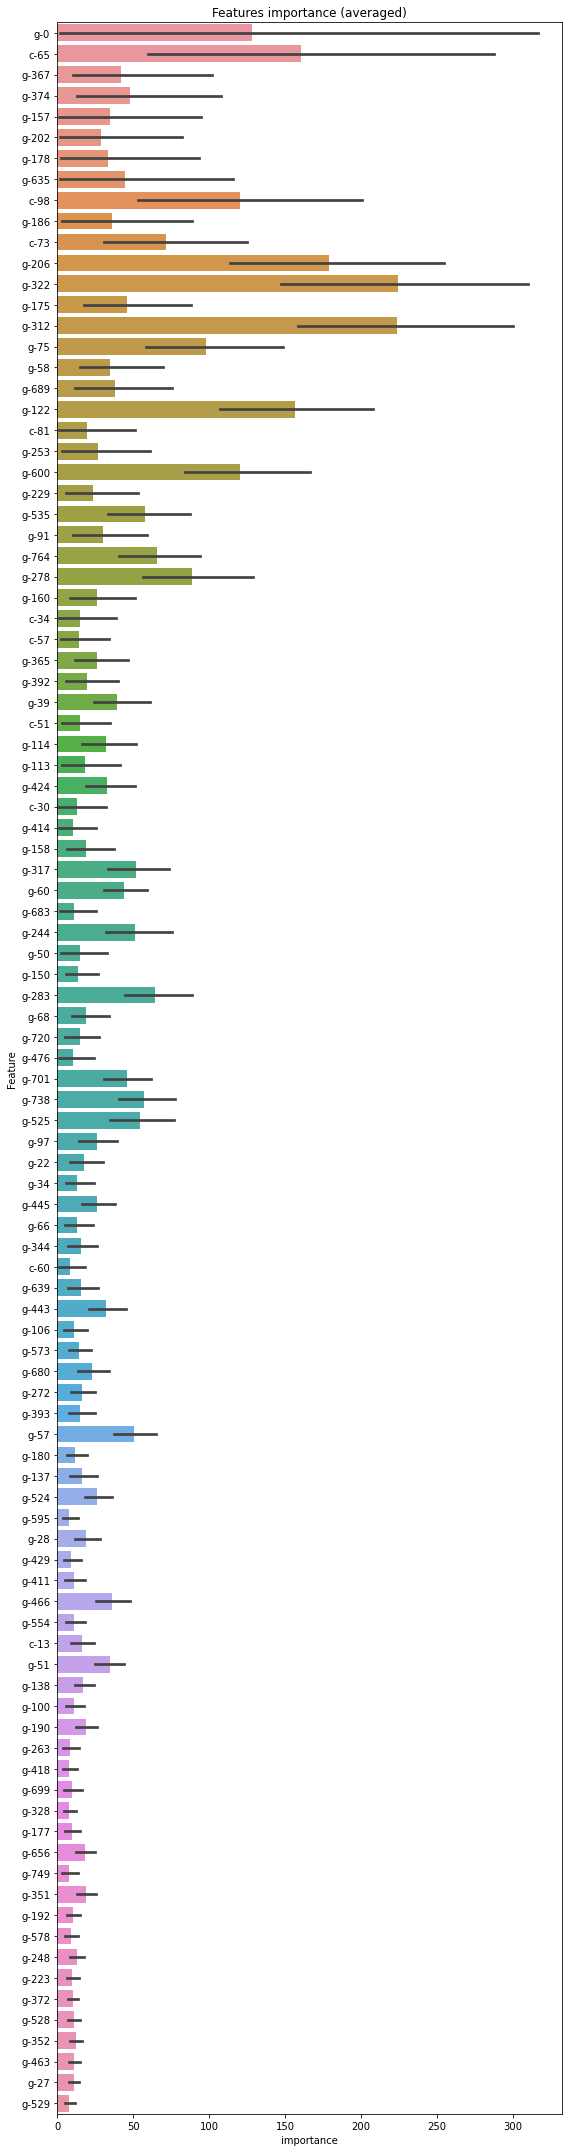

In [22]:
show_feature_importance(feature_importance_df)